# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Libraries

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CV/Project/Code')
from models import GbcNet

import random
import json
import torch
import pickle
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import copy
import time
import math
import cv2
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms import Resize, ToTensor, Compose, GaussianBlur
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.nn.init as init
from torch.optim import SGD, Adam, NAdam
#from torchmetrics.detection import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import one_hot

from sklearn.metrics import roc_auc_score

from torchvision.utils import draw_bounding_boxes
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### File Paths

In [ ]:
!unzip "/content/drive/MyDrive/CV/Project/data/images.zip" -d "/content"
imgs_folder_path = "/content/images"
gold_file_path = "/content/drive/MyDrive/CV/Project/data/gold_boxes.json"
gbcnet_weight_path = "/content/drive/MyDrive/CV/Project/Code/Original Models/init_weights.pth"

### Helper Functions

In [ ]:
def read_txt(txt_path):
  ids = []
  cls = []
  with open(txt_path,"r") as f:
    for line in f.readlines():
      ids.append(line.strip().split(',')[0])
      cls.append(int(line.strip().split(',')[1]))

  return ids, cls

def read_json(json_path):
  with open(json_path, "r") as f:
    json_file = json.load(f)

  return json_file

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img, pred_bboxes=None, title=None):
    print("visualize")
    edgecolors = ["y", "r", "c"]
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the original image with bounding box
    if torch.is_tensor(img):
      ax.imshow(img.permute(1, 2, 0).numpy())
    else:
      ax.imshow(img)
    if pred_bboxes is not None:
      for i in range(len(pred_bboxes)):
        pred_bbox = pred_bboxes[i]
        rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], linewidth=2, edgecolor=edgecolors[i], facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)

    plt.show()


def gold_box_proportion(x):
  if x < 30:
    return 1
  elif 30 <= x < 35:
    return 0.75
  elif 35 <= x < 40:
    return 0.5
  elif 40 <= x < 45:
    return 0.25
  else:
    return 0

def print_status(txt, status_flag):
  if status_flag==False:
    print(txt)
  return True

def filter_background(predictions):
  # Filter out the predictions with label 0
  filtered_predictions = []
  for prediction in predictions:
      mask = prediction['labels'] != 0
      filtered_prediction = {k: v[mask] for k, v in prediction.items()}
      filtered_predictions.append(filtered_prediction)
  return filtered_predictions

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Transforms

In [ ]:
class img_bbox_transform(object):
    def __init__(self, target_width, target_height):
      self.target_width = target_width
      self.target_height = target_height
      self.transforms = Compose([Resize((self.target_width, self.target_height)),
                                ToTensor()])

    def __call__(self, image=None, bbox = None, current_width=None, current_height=None):
      transformed_image = None
      if image is not None:
        current_width, current_height = image.size
        transformed_image = self.transforms(image)
      transformed_bbox = None
      if bbox is not None:
        transformed_bbox = self.transform_bbox(bbox, current_width, current_height)
      return transformed_image, transformed_bbox

    def transform_bbox(self, bbox, current_width=None, current_height=None):
      new_x1 = bbox[0]*self.target_width/current_width
      new_y1 = bbox[1]*self.target_height/current_height
      new_x2 = bbox[2]*self.target_width/current_width
      new_y2 = bbox[3]*self.target_height/current_height
      return [round(new_x1.item()), round(new_y1.item()), round(new_x2.item()), round(new_y2.item())]


def crop_image(image, box, p):
    x1, y1, x2, y2 = box
    # Input images in CHW
    cropped_image = image[:, int((1-p)*y1):int((1+p)*y2), int((1-p)*x1):int((1+p)*x2)]
    return cropped_image

def get_train_transforms(width, height, p=None):
    return A.Compose([
        A.Rotate(limit=5, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.6, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit= 0.1, p=0.5),
        A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=5, val_shift_limit=0, p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
        A.Perspective(scale=(0.01, 0.05), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.7),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_eval_transforms(width, height):
    return A.Compose([
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

### Dataset

In [ ]:
class InputDataset(Dataset):
    def __init__(self, img_folder, id_txt, gold_json, p=0.15, width=224, height=224, img_transforms=None, do_crop=None, predicted_bboxes_json=None, to_blur=False, blur_kernel_size=(65,65), sigma=0):
        self.img_folder = img_folder
        self.id_txt = id_txt
        self.gold_json = gold_json
        self.to_blur = to_blur
        self.blur_kernel_size = blur_kernel_size
        self.sigma = sigma
        self.do_crop=do_crop
        self.p=p
        self.width=width
        self.height=height
        self.transforms = img_transforms
        self.ids, self.true_labels = read_txt(id_txt)
        self.gold_dict = read_json(gold_json)
        self.predicted_boxes = None
        if predicted_bboxes_json is not None:
          self.predicted_boxes=read_json(predicted_bboxes_json)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_label = self.true_labels[idx]
        gold_bbox = self.gold_dict[img_id]['Gold']
        img_path = f"{self.img_folder}/{img_id}"
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape
        if self.to_blur:
          img = cv2.GaussianBlur(img, self.blur_kernel_size, self.sigma)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if (self.do_crop==None) or (self.do_crop=="gold_boxes"):
          transformed_dict = self.transforms(image=img, bboxes=[gold_bbox], labels=[1])
        elif self.do_crop=="pred_boxes":
          pred_bbox = self.predicted_boxes[img_id]['Boxes']
          transformed_dict = self.transforms(image=img, bboxes=[pred_bbox], labels=[1])

        #visualize(img, pred_bboxes=[gold_bbox, pred_bbox], title=f"raw image {img_id}")
        transformed_img = transformed_dict['image'].float().div(255)
        transformed_bboxes = [round(x) for x in transformed_dict['bboxes'][0]]
        #visualize(transformed_img, [[0,0,0,0], transformed_bboxes], title=f"transformed img {img_id}")

        if self.do_crop is not None:
          transformed_bboxes_area = (transformed_bboxes[2]-transformed_bboxes[0]) * (transformed_bboxes[3]-transformed_bboxes[1])
          if transformed_bboxes_area > 0:
            transformed_img = crop_image(transformed_img, transformed_bboxes, p=self.p)
            transformed_img = F.interpolate(transformed_img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)

        #visualize(transformed_img, title=f"cropped img {img_id}")

        target = {}
        target['boxes'] = torch.tensor(transformed_bboxes).unsqueeze(0)
        target['labels'] = torch.tensor(1).unsqueeze(0)
        target['true_labels'] = torch.tensor(img_label, dtype=torch.int64)
        target['image shape'] = {'height': img_height, 'width': img_width}
        target['Gold'] = gold_bbox
        return img_id, transformed_img, target

def collate_fn(batch):
  images_ids, images, targets = zip(*batch)
  return list(images_ids), list(images), list(targets)

### Evaluation

In [ ]:
def compute_IoU(boxA, boxB):
  x1_A, y1_A, x2_A, y2_A = boxA
  x1_B, y1_B, x2_B, y2_B = boxB

  x1 = max(x1_A, x1_B)
  y1 = max(y1_A, y1_B)
  x2 = min(x2_A, x2_B)
  y2 = min(y2_A, y2_B)

  if x2 <= x1 or y2 <= y1:
    return torch.tensor(0).to(device)

  intersection_area = (x2 - x1) * (y2 - y1)
  boxA_area = (x2_A - x1_A) * (y2_A - y1_A)
  boxB_area = (x2_B - x1_B) * (y2_B - y1_B)

  iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
  return iou.float()

def center_within_gold(box, gold):
  x_center = (box[0] + box[2])/2
  y_center = (box[1] + box[3])/2
  x_min_gold, x_max_gold = gold[0], gold[2]
  y_min_gold, y_max_gold = gold[1], gold[3]
  if (x_min_gold<x_center<x_max_gold) and (y_min_gold<y_center<y_max_gold):
    return True
  else:
    return False

def compute_bbox_metrics(targets, predictions):
  tp = 0
  fp = 0
  fn = 0
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        if center_within_gold(pred_box, target_box):
          tp += 1
        else:
          fp += 1
    else:
      fn += 1
  return tp, fp, fn

def evaluate_IoUs(targets, predictions):
  IoUs = []
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        IoUs.append(compute_IoU(target_box, pred_box.squeeze(0)))
    else:
      IoUs.append(torch.tensor(0.0).to(device))
  return IoUs

# GBCRet

## Evaluation

In [ ]:
def evaluate_model(model, dataloader, return_bboxes=False):
  model.eval()
  all_IoUs = []
  #mAP_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
  y_pred = []
  y_true = []
  fnames = []
  TPs = 0
  FNs = 0
  FPs = 0
  precision = 0
  recall = 0
  all_bboxes= {}
  all_logits = [[], []]
  with torch.inference_mode():
    for i, data in enumerate(dataloader, 0):
      images_ids, inputs, targets = data[0],\
                                    [image.to(device) for image in data[1]],\
                                    [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in data[2]]

      pred_cls, pred_bboxes, logits = model(inputs, targets)

      if logits:
        logits = [x.tolist() for x in logits]
        all_logits = [a+b for a, b in zip(all_logits, logits)]
      y_true += [x['true_labels'].item() for x in targets]
      y_pred += pred_cls.tolist()
      fnames += images_ids

      IoUs = evaluate_IoUs(targets, pred_bboxes)
      all_IoUs += IoUs

      tp, fp, fn = compute_bbox_metrics(targets, pred_bboxes)
      TPs += tp
      FPs += fp
      FNs += fn

      #mAP_metric.update(pred_bboxes, targets)

      if return_bboxes:
        for i in range(len(targets)):
          fname = images_ids[i]
          target_bbox = targets[i]['boxes']
          pred_bbox = pred_bboxes[i]['boxes']
          all_bboxes[fname] = {"Boxes": pred_bbox, "Gold": target_bbox}

  mIoU = torch.stack(all_IoUs).mean()
  medIoU = torch.stack(all_IoUs).median()
  #mAP_dict = mAP_metric.compute()
  #mAP = mAP_dict['map']
  print(f"mIoU = {mIoU}, median IoU: {medIoU}") # mAP = {round(mAP_dict['map'].item(),3)}, mAP_50 = {round(mAP_dict['map_50'].item(),3)}, mAP_75 = {round(mAP_dict['map_75'].item(),3)}")

  if (TPs + FPs) != 0:
    precision = TPs / (TPs + FPs)
  if (TPs + FNs) != 0:
    recall = TPs / (TPs + FNs)
  print(f"TP: {TPs}, FN: {FNs}, FP: {FPs}")
  print("Precision: {}\nRecall: {}".format(precision, recall))

  acc = accuracy_score(y_true, y_pred)
  cfm = confusion_matrix(y_true, y_pred)
  spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
  sens = cfm[2][2]/np.sum(cfm[2])
  n_nn_acc = (cfm[0,0] + np.sum(cfm[1:,1:]))/np.sum(cfm)
  b_m_acc = (cfm[1,1] + cfm[2,2])/np.sum(cfm[1:,1:])
  print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}\nNormal vs Not Noraml Acc: {:.4f} Benign vs Malignant Acc: {:.4f}'.format(acc, spec, sens, n_nn_acc, b_m_acc))

  return acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits

## Model

### Attention

In [ ]:
class FeatureMapAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, feature_map):
    # feature map shape: [batch_size, 256, H, W]
    # Reshape to: [batch_size, H*W, 256]
    x = feature_map.reshape(feature_map.size(0), -1, 256)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x,x,x)
    # Reshape back to original shape: [batch_size, 256, H, W]
    return attn_output.reshape(*feature_map.shape)

class VectorAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, x):
    # x shape: [batch_size, 256 + 2048]
    # Reshape to: [batch_size, 1, 256 + 2048]
    x = x.unsqueeze(1)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x, x, x)
    # Remove the extra dimension: [batch_size, 256 + 2048]
    return attn_output.squeeze(1)


### Main model

In [ ]:
class GBCRet_combined(nn.Module):
  def __init__(self, combined="None", continue_training=False, criterion=None, gbcnet_weight_path=None, retinanet_weight_path=None,
               do_hierarchical_cls=False, retinanet_backbone="resnet50-coco", gold_curriculum=False, p=0.15, width=224, height=224,
               attn_num_heads=4, no_attn=True, train_gold_bbox=True, min_size=800, max_size=1333, dropout=0.4, detections_per_img=1,
               regression_loss=None, rn_trainable_layers=None, gbcnet_va_curriculum=False, load_pretrained_retinanet=False,
               loss_weights = {"n_nn_loss_weight": 1.0, "b_m_loss_weight": 1.0, "classification_loss_weight": 1.0, "retinanet_loss_weight": 1.0},
               nnn_fc_layers="1", bm_fc_layers="1", return_logits=False):
    super(GBCRet_combined, self).__init__()
    # Settings
    self.return_logits=return_logits
    self.loss_weights=loss_weights
    self.load_pretrained_retinanet=load_pretrained_retinanet
    self.gbcnet_va_curriculum=gbcnet_va_curriculum
    self.rn_trainable_layers=rn_trainable_layers
    self.retinanet_backbone=retinanet_backbone
    self.combined=combined
    self.no_attn = no_attn
    self.do_hierarchical_cls=do_hierarchical_cls
    self.continue_training=continue_training
    self.detections_per_img=detections_per_img
    self.p = p
    self.width = width
    self.height = height
    self.min_size = min_size
    self.max_size = max_size
    self.criterion = criterion
    self.train_gold_bbox = train_gold_bbox
    self.gold_curriculum = gold_curriculum
    self.regression_loss = regression_loss
    self.current_epoch = -1
    if isinstance(dropout, dict):
      n_nn_dropout=dropout['n_nn_dropout']
      b_m_dropout=dropout['b_m_dropout']
      dropout=0
      print(f"n_nn_dropout: {n_nn_dropout}, b_m_dropout: {b_m_dropout}")
    else:
      n_nn_dropout=dropout
      b_m_dropout=dropout
    # Status Flags
    self.gbcnet_va_curriculum_flag=False
    self.combined_status_flag=False
    self.no_attn_status_flag=False
    self.train_gold_box_status_flag=False
    self.gold_curriculum_status_flag=False
    self.num_gold_boxes_status_flag=False
    self.hierarchical_classification_status_flag=False
    # Loading models
    self.retinanet = self.load_retinanet(retinanet_weight_path)
    self.gbcnet = self.load_gbcnet(gbcnet_weight_path)
    # Hooks
    self.retinanet_features = None
    self.gbcnet_features = None
    self.resnet_layer1_features = None
    self.resnet_layer2_features = None
    self.resnet_layer3_features = None
    self.resnet_layer4_features = None
    self.gbcnet.net.layer4.register_forward_hook(self._get_gbcnet_features_hook)
    self.retinanet.backbone.register_forward_hook(self._get_retinanet_features_hook)
    self.retinanet.backbone.body.layer1.register_forward_hook(self._get_resnet_layer1_features_hook)
    self.retinanet.backbone.body.layer2.register_forward_hook(self._get_resnet_layer2_features_hook)
    self.retinanet.backbone.body.layer3.register_forward_hook(self._get_resnet_layer3_features_hook)
    self.retinanet.backbone.body.layer4.register_forward_hook(self._get_resnet_layer4_features_hook)
    # Layers
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.feature_map_attn = FeatureMapAttention(embed_dim=256, num_heads=attn_num_heads)
    self.combined_attn_layer = VectorAttention(embed_dim= 2048 + 256, num_heads=attn_num_heads)

    self.fc = nn.Sequential(
                  nn.Linear((2048 + 256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.FPN_linear = nn.Linear(5*256, 256)
    self.Layer2_linear = nn.Linear(512, 256)
    self.Layer3_linear = nn.Linear(1024, 256)
    self.Layer4_linear = nn.Linear(2048, 256)
    self.compress_combined_featuers_linear = nn.Linear((2048 + 256), 2048)

    self.fc2 = nn.Sequential(
                  nn.Linear((5*256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.meta_learner = nn.Linear(6,3)

    if nnn_fc_layers=="1":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(256,2)
                                          )
    elif nnn_fc_layers=="3":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(512,2)
                                          )
    if bm_fc_layers == "1":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256,2)
                                          )
    elif bm_fc_layers == "2":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(dropout),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256, 2)
                                          )
    elif bm_fc_layers == "3":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(512,2)
                                          )
    elif bm_fc_layers == "4":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 1024),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(1024,2)
                                          )

  def load_retinanet(self, retinanet_weight_path):
    if self.retinanet_backbone=="resnet50-gbusv":
      # No weights -> by default trainable_layers = 5 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
      retinanet = retinanet_resnet50_fpn_v2(num_classes=2, detections_per_img = self.detections_per_img, score_thresh=0.05,
                                            nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      if not self.continue_training:
        retinanet.load_state_dict(torch.load(retinanet_weight_path, map_location=device))
        print(f"Retinanet's GBUSV pre-trained weights are loaded from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet50-coco":
      if self.rn_trainable_layers == None:
        # Defined weights -> by default trainable layers = 3 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      else:
        print(f"Retinanet's Trainable Backbone Layers: {self.rn_trainable_layers}")
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size,
                                              trainable_backbone_layers=self.rn_trainable_layers).to(device)
      print("Retinanet's COCO pre-trained weights are loaded.")
      num_classes=2
      num_anchors = retinanet.head.classification_head.num_anchors
      in_channels = retinanet.head.classification_head.cls_logits.in_channels
      new_cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1).to(device)
      torch.nn.init.normal_(new_cls_logits.weight, std=0.01)
      torch.nn.init.constant_(new_cls_logits.bias, -math.log((1 - 0.01) / 0.01))
      retinanet.head.classification_head.cls_logits = new_cls_logits
      retinanet.head.classification_head.num_classes = num_classes
      if self.load_pretrained_retinanet:
        checkpoint = torch.load(retinanet_weight_path, map_location=device)
        retinanet.load_state_dict(checkpoint['model_state_dict'])
        print(f"Retinanet's {checkpoint['epoch']} epoch Pretrained Weights from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet34" or self.retinanet_backbone=="resnet18":
      # Create the backbone using ResNet34 with FPN
      backbone = resnet_fpn_backbone(backbone_name=self.retinanet_backbone, trainable_layers=3, weights="IMAGENET1K_V1").to(device)
      # Create the RetinaNet model
      retinanet = RetinaNet(backbone, num_classes=2, detections_per_img=self.detections_per_img, score_thresh=0.05, nms_thresh=0.5,
                            min_size=self.min_size, max_size=self.max_size).to(device)
      if self.regression_loss == 'giou':
        retinanet.head.regression_head._loss_type = "giou"
      return retinanet

  def load_gbcnet(self, gbcnet_weight_path):
    gbcnet = GbcNet(num_cls=3, pretrain=False, att_mode= "1")
    if not self.continue_training:
      gbcnet.load_state_dict(torch.load(gbcnet_weight_path, map_location=device))
      print(f"GBCNet's pretrained weights are loaded from: {gbcnet_weight_path}")
    gbcnet.net = gbcnet.net.float().to(device)
    return gbcnet

  def _get_retinanet_features_hook(self, module, input, output):
    self.retinanet_features = output

  def _get_gbcnet_features_hook(self, module, input, output):
    self.gbcnet_features = output

  def _get_resnet_layer1_features_hook(self, module, input, output):
    self.resnet_layer1_features = output

  def _get_resnet_layer2_features_hook(self, module, input, output):
    self.resnet_layer2_features = output

  def _get_resnet_layer3_features_hook(self, module, input, output):
    self.resnet_layer3_features = output

  def _get_resnet_layer4_features_hook(self, module, input, output):
    self.resnet_layer4_features = output

  def forward(self, inputs, targets, epoch=None):
    # Training mode
    if self.training:
      retinanet_loss_dict = self.retinanet(inputs, targets)
      retinanet_loss = sum(loss for loss in retinanet_loss_dict.values())
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features

      if self.gold_curriculum==False:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Deactivated.", self.gold_curriculum_status_flag)
        if self.train_gold_bbox:
          self.train_gold_box_status_flag = print_status("Training only with gold boxes.", self.train_gold_box_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets, epoch)
        else:
          self.train_gold_box_status_flag = print_status("Training only with predicted boxes.", self.train_gold_box_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)

      else:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Activated.", self.gold_curriculum_status_flag)
        if self.current_epoch != epoch:
          self.num_gold_boxes_status_flag=False
        self.current_epoch=epoch
        if gold_box_proportion(epoch) == 1:
          self.num_gold_boxes_status_flag = print_status("All Gold Boxes are using.", self.num_gold_boxes_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets)
        else:
          num_gold_boxes = int(gold_box_proportion(epoch)*len(targets))
          self.num_gold_boxes_status_flag = print_status(f"{num_gold_boxes} Gold Boxes, and {len(targets)-num_gold_boxes} Predicted Boxes are using.", self.num_gold_boxes_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          selected_bboxes = targets[:num_gold_boxes]
          selected_bboxes += pred_bboxes[num_gold_boxes:]
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, selected_bboxes, targets)

      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        self.combined_status_flag = print_status("Combining features of Retinanet and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer1":
        self.combined_status_flag = print_status("Combining ResNet layer1 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer2":
        self.combined_status_flag = print_status("Combining ResNet layer2 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer3":
        self.combined_status_flag = print_status("Combining ResNet layer3 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer4":
        self.combined_status_flag = print_status("Combining ResNet layer4 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
          classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          classification_loss = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=="classification":
        self.combined_status_flag = print_status("Combining classifications of Retinanet and GBCNet backbones.", self.combined_status_flag)
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        classification_loss = self.criterion(combined_cls_logits.to(device), true_labels.to(device))
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          self.combined_status_flag = print_status("Classification only using GBCNet.", self.combined_status_flag)
          classification_loss = self.criterion(gbcnet_cls_logits.to(device), true_labels.to(device))
        else:
          self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          classification_loss = self.hierarchical_cls(gbcnet_features, true_labels)

      total_loss = self.loss_weights["retinanet_loss_weight"] * retinanet_loss + self.loss_weights["classification_loss_weight"] * classification_loss
      return total_loss

    # Inference mode
    else:
      pred_bboxes = self.predict_bboxes(inputs)
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features
      gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)
      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer1":
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer2":
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer3":
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer4":
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          final_h_preds, cls_output = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=='classification':
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        cls_output = combined_cls_logits
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          cls_output = gbcnet_cls_logits
        else:
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          final_h_preds, cls_output = self.hierarchical_cls(gbcnet_features, true_labels)

      if not self.do_hierarchical_cls:
        _, cls_pred = torch.max(cls_output, dim=1)
      else:
        cls_pred = final_h_preds

      if self.return_logits == False:
        return cls_pred, pred_bboxes
      else:
        return cls_pred, pred_bboxes, cls_output

  def hierarchical_cls(self, features, true_labels):
    # Training mode
    if self.training:
      self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)

      # Normal vs Non-Normal classification
      n_nn_output = self.normal_notnormal_fc(features)
      n_nn_true_labels = torch.tensor([0 if x == 0 else 1 for x in true_labels]) # Normal-> 0, Non-Normal -> 1

      if isinstance(self.criterion, nn.BCEWithLogitsLoss):
        n_nn_true_labels = one_hot(n_nn_true_labels, num_classes=2).float()
      n_nn_loss = self.criterion(n_nn_output.to(device), n_nn_true_labels.to(device))

      not_normal_indices = (true_labels != 0)
      if not (not_normal_indices==False).all():
        # Benign vs Malignant classification
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        b_m_true_labels = true_labels[not_normal_indices]
        b_m_true_labels = torch.tensor([0 if x==1 else 1 for x in b_m_true_labels]) # Benign -> 0, Malignant -> 1

        if isinstance(self.criterion, nn.BCEWithLogitsLoss):
          b_m_true_labels = one_hot(b_m_true_labels, num_classes=2).float()
        b_m_loss = self.criterion(b_m_output.to(device), b_m_true_labels.to(device))
      else:
        b_m_loss = 0
      loss = self.loss_weights["n_nn_loss_weight"] * n_nn_loss + self.loss_weights["b_m_loss_weight"] * b_m_loss
      return loss

    # Inference mode
    else:
      n_nn_output = self.normal_notnormal_fc(features)
      _, n_nn_cls_pred = torch.max(n_nn_output, dim=1)
      final_h_preds = torch.zeros_like(n_nn_cls_pred)
      not_normal_indices = (n_nn_cls_pred != 0)
      if not (not_normal_indices==False).all():
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        _, b_m_cls_pred = torch.max(b_m_output, dim=1)
        b_m_cls_pred += 1
        final_h_preds[not_normal_indices] = b_m_cls_pred
      return final_h_preds, [n_nn_output, b_m_output]


  def predict_bboxes(self, inputs):
    self.retinanet.eval()
    with torch.inference_mode():
      predictions = self.retinanet(inputs)
      foreground_preds = filter_background(predictions)
    if self.training:
      self.retinanet.train()
    return foreground_preds

  def va_blur(self, img, epoch):
    self.gbcnet_va_curriculum_flag = print_status("GBCNet VA Curriculum Activated.", self.gbcnet_va_curriculum_flag)
    if epoch <= 10:
      gaussian_blur = GaussianBlur((17,17), 8)
      img = gaussian_blur(img)
    elif epoch > 10 and epoch <= 15:
      gaussian_blur = GaussianBlur((9,9), 4)
      img = gaussian_blur(img)
    elif epoch > 15 and epoch <= 20:
      gaussian_blur = GaussianBlur((5,5), 2)
      img = gaussian_blur(img)
    elif epoch > 20 and epoch <= 25:
      gaussian_blur = GaussianBlur((3,3), 1)
      img = gaussian_blur(img)
    elif epoch > 25 and epoch <= 30:
      gaussian_blur = GaussianBlur((1,1), 0.5)
      img = gaussian_blur(img)
    else:
      return img
    return img

  def prepare_gbcnet_inputs(self, inputs, predictions, targets, epoch=None):
    true_labels = []
    gbcnet_inputs = []
    for i in range(len(inputs)):
      img = inputs[i]
      if (self.gbcnet_va_curriculum) and (epoch is not None):
        img = self.va_blur(img, epoch)
      true_labels.append(targets[i]['true_labels'])
      pred_bboxes = predictions[i]['boxes']
      #visualize(img)
      if len(pred_bboxes) > 0:
        for pred_bbox in pred_bboxes:
          pred_bbox_area = (int(pred_bbox[2])-int(pred_bbox[0])) * (int(pred_bbox[3])-int(pred_bbox[1]))
          if pred_bbox_area > 0:
            img = crop_image(img, pred_bbox, self.p)
            img = F.interpolate(img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)
      gbcnet_inputs.append(img)
    return torch.stack(gbcnet_inputs), torch.stack(true_labels)

  def concat_feature_maps(self, rn_fms, gb_fm=None):
    if self.combined=='resnet-fpn':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      rn_rms = torch.stack(rn_fms)
      rn_fms = torch.cat(rn_fms, dim=-1)
      rn_fms = self.FPN_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.view(gb_fm.size(0), -1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim = 1)
    elif self.combined in ["resnet_layer1", "resnet_layer2", "resnet_layer3", "resnet_layer4"]:
      rn_fms = self.avgpool(rn_fms)
      rn_fms = rn_fms.reshape(rn_fms.size(0), -1)
      if self.combined=="resnet_layer2":
        rn_fms = self.Layer2_linear(rn_fms)
      elif self.combined=="resnet_layer3":
        rn_fms = self.Layer3_linear(rn_fms)
      elif self.combined=="resnet_layer4":
        rn_fms = self.Layer4_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.reshape(gb_fm.size(0),-1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim=1)
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention is applied on combined features.", self.no_attn_status_flag)
        concatenated_features = self.combined_attn_layer(concatenated_features)
    elif self.combined=='classification':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      concatenated_features = torch.cat(rn_fms, dim = 1)
    return concatenated_features


# Calibration Codes
Adapted from: https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
        self.loss=[]
        self.ece=[]
        self.min_ece = None
        self.best_temperature = torch.ones(1)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits, t=None):
        """
        Perform temperature scaling on logits
        """
        # Use self.temperature if no external temperature is provided
        if t is None:
          t = self.temperature

        # Expand temperature to match the size of logits
        temperature = t.unsqueeze(1).expand(logits.size(0), logits.size(1)).to(device)
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader, cls_type=None):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.to(device)
        nll_criterion = nn.CrossEntropyLoss().to(device)
        ece_criterion = _ECELoss().to(device)

        # First: collect all the logits and labels for the validation set
        all_logits = [[], []]
        y_pred = []
        y_true = []
        with torch.no_grad():
            for i, data in enumerate(valid_loader, 0):
              images_ids, inputs, targets = data[0],\
                                            [image.to(device) for image in data[1]],\
                                            [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in data[2]]

              pred_cls, pred_bboxes, logits = self.model(inputs, targets)

              logits = [x.tolist() for x in logits]
              all_logits = [a+b for a, b in zip(all_logits, logits)]
              y_true += [x['true_labels'].item() for x in targets]
              y_pred += pred_cls.tolist()

            if cls_type == "n_nn":
              labels = torch.tensor([0 if x==0 else 1 for x in y_true]).to(device)
              logits = torch.tensor(all_logits[0]).to(device)
            elif cls_type == "b_m":
              # Find the indices of instances predicted as non-noraml
              nn_pred_indices = [i for i,p in enumerate(y_pred) if p!=0]
              # Find the true labels of instances predicted as non-normal
              filtered_y_true = [y_true[i] for i in nn_pred_indices]
              # Find indices of truly non-normal instances from the true labels
              nn_true_pred_indices = [i for i,y in enumerate(filtered_y_true) if y!=0]

              labels = torch.tensor([filtered_y_true[i]-1 for i in nn_true_pred_indices]).to(device)
              logits = torch.tensor([all_logits[1][i] for i in nn_true_pred_indices]).to(device)

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        self.min_ece = before_temperature_ece
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=500)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            ece = ece_criterion(self.temperature_scale(logits), labels)
            self.loss.append(loss.item())
            self.ece.append(ece.item())
            loss.backward()

            if ece.item() < self.min_ece:
              self.min_ece = ece.item()
              self.best_temperature = self.temperature.clone()

            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        after_temperature_nll = nll_criterion(self.temperature_scale(logits, self.best_temperature), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits, self.best_temperature), labels).item()
        print('Best Optimal temperature: %.3f' % self.best_temperature.item())
        print('After best temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

# ECE calculation

In [ ]:
def eval_cal(checkpoint_path, val_txt_path, task="eval"):
  width = 224
  height = 224
  min_size = 224
  max_size = 224
  gold_curriculum = False
  no_attn = True # No attention
  combined="resnet_layer4"
  retinanet_backbone="resnet50-coco"
  do_hierarchical_cls=True
  bm_fc_layers="3"

  gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                          width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                          do_hierarchical_cls=do_hierarchical_cls, bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

  checkpoint = torch.load(checkpoint_path, map_location=device)
  gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
  gbcret.eval()

  eval_transform = get_eval_transforms(width, height)

  val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
  val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

  def plot_nll(model):
    plt.plot(model.loss)
    plt.xlabel('Iteration')
    plt.ylabel('NLL')
    plt.title('NLL during temperature scaling')
    plt.show()

  def plot_ece(model):
    plt.plot(model.ece)
    plt.xlabel('Iteration')
    plt.ylabel('ECE')
    plt.title('ECE during temperature scaling')
    plt.show()


  if task== "eval":
    return evaluate_model(gbcret, val_loader, return_bboxes=True)
  elif task == "calibrate n_nn":
    scaled_model = ModelWithTemperature(gbcret)
    scaled_model.set_temperature(val_loader, cls_type="n_nn")
    plot_nll(scaled_model)
    plot_ece(scaled_model)
    return scaled_model.best_temperature.item()
  elif task == "calibrate b_m":
    scaled_model = ModelWithTemperature(gbcret)
    scaled_model.set_temperature(val_loader, cls_type="b_m")
    plot_nll(scaled_model)
    plot_ece(scaled_model)
    return scaled_model.best_temperature.item()

# Plot

In [ ]:
def plot_probs(y_true, y_pred, all_logits):
  import torch
  from torch import nn

  softmax_layer=nn.Softmax(dim=1)

  n_nn_probs = softmax_layer(torch.tensor(all_logits[0]))
  b_m_probs = softmax_layer(torch.tensor(all_logits[1]))

  n_nn_y_true = [x if x==0 else 1 for x in y_true]
  n_nn_y_pred = [x if x==0 else 1 for x in y_pred]

  b_m_cases = [True if x!=0 else False for x in y_pred]
  b_m_fnames = [item for bool_val, item in zip(b_m_cases, fnames) if bool_val]
  b_m_y_true = [item for bool_val, item in zip(b_m_cases, y_true) if bool_val]
  b_m_y_pred = [item for bool_val, item in zip(b_m_cases, y_pred) if bool_val]

  n_correct = []
  nn_correct = []
  n_wrong = []
  nn_wrong = []

  for i in range(len(fnames)):
    if (n_nn_y_true[i]==0) and (n_nn_y_pred[i]==0):
      n_correct.append(n_nn_probs[i][0])
    elif (n_nn_y_true[i]==0) and (n_nn_y_pred[i]==1):
      nn_wrong.append(n_nn_probs[i][1])
    elif (n_nn_y_true[i]==1) and (n_nn_y_pred[i]==0):
      n_wrong.append(n_nn_probs[i][0])
    elif (n_nn_y_true[i]==1) and (n_nn_y_pred[i]==1):
      nn_correct.append(n_nn_probs[i][1])

  b_correct = []
  m_correct = []
  b_wrong = []
  m_wrong = []

  for i in range(len(b_m_y_true)):
    if (b_m_y_true[i]==1) and (b_m_y_pred[i]==1):
      b_correct.append(b_m_probs[i][0])
    elif (b_m_y_true[i]==1) and (b_m_y_pred[i]==2):
      m_wrong.append(b_m_probs[i][1])
    elif (b_m_y_true[i]==2) and (b_m_y_pred[i]==1):
      b_wrong.append(b_m_probs[i][0])
    elif (b_m_y_true[i]==2) and (b_m_y_pred[i]==2):
      m_correct.append(b_m_probs[i][1])

  import matplotlib.pyplot as plt
  import numpy as np

  def plot_histograms(fig, ax, data, colors, titles):
      bins = np.arange(0.5, 1.01, 0.1)
      bins[-1] = 1.01

      axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

      for i in range(4):
          counts, _, patches = axes[i].hist(data[i], bins=bins, color=colors[i])
          axes[i].set_title(titles[i])

          # Add labels
          for count, patch in zip(counts, patches):
              axes[i].annotate(f'{int(count)}', (patch.get_x()+patch.get_width()/2, patch.get_height()),
                              ha='center', va='bottom')

      for item in ax.flat:
          item.set_xticks(np.arange(0.5, 1.01, 0.1))

      plt.tight_layout()
      plt.show()

  fig, ax = plt.subplots(2,2, figsize=(10,10))
  data = [n_correct, n_wrong, nn_correct, nn_wrong]
  colors = ['blue', 'red', 'lightblue', 'pink']
  titles = ["Normal Probs\nCorrectly Classified", "Normal Probs\nMissclassified",
            "Not Normal Probs\nCorrectly Classified", "Not Normal Probs\nMissclassified"]
  plot_histograms(fig, ax, data, colors, titles)

  fig, ax = plt.subplots(2,2, figsize=(10,10))
  data = [b_correct, b_wrong, m_correct, m_wrong]
  colors = ['blue', 'red', 'lightblue', 'pink']
  titles = ["Benign Probs\nCorrectly Classified", "Benign Probs\nMissclassified",
            "Malignant Probs\nCorrectly Classified", "Malignant Probs\nMissclassified"]
  plot_histograms(fig, ax, data, colors, titles)



## Fold0

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold0: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_62.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_0_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7371808290481567, median IoU: 0.7679744362831116
TP: 201, FN: 0, FP: 3
Precision: 0.9852941176470589
Recall: 1.0
Acc: 0.8775 Spec: 1.0000 Sens: 0.7111
Normal vs Not Noraml Acc: 0.9216 Benign vs Malignant Acc: 0.8941


### Eval Results

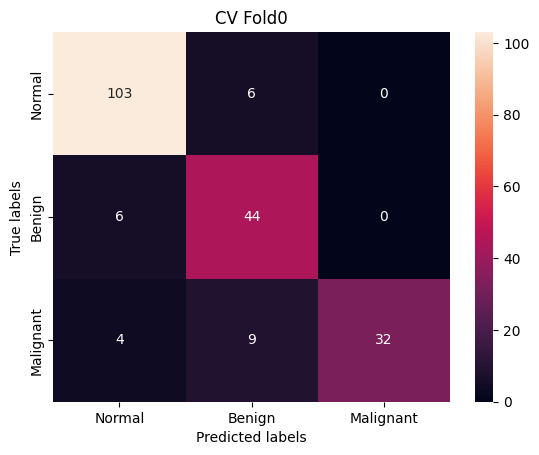

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold0')
plt.show()



---



#### Plots

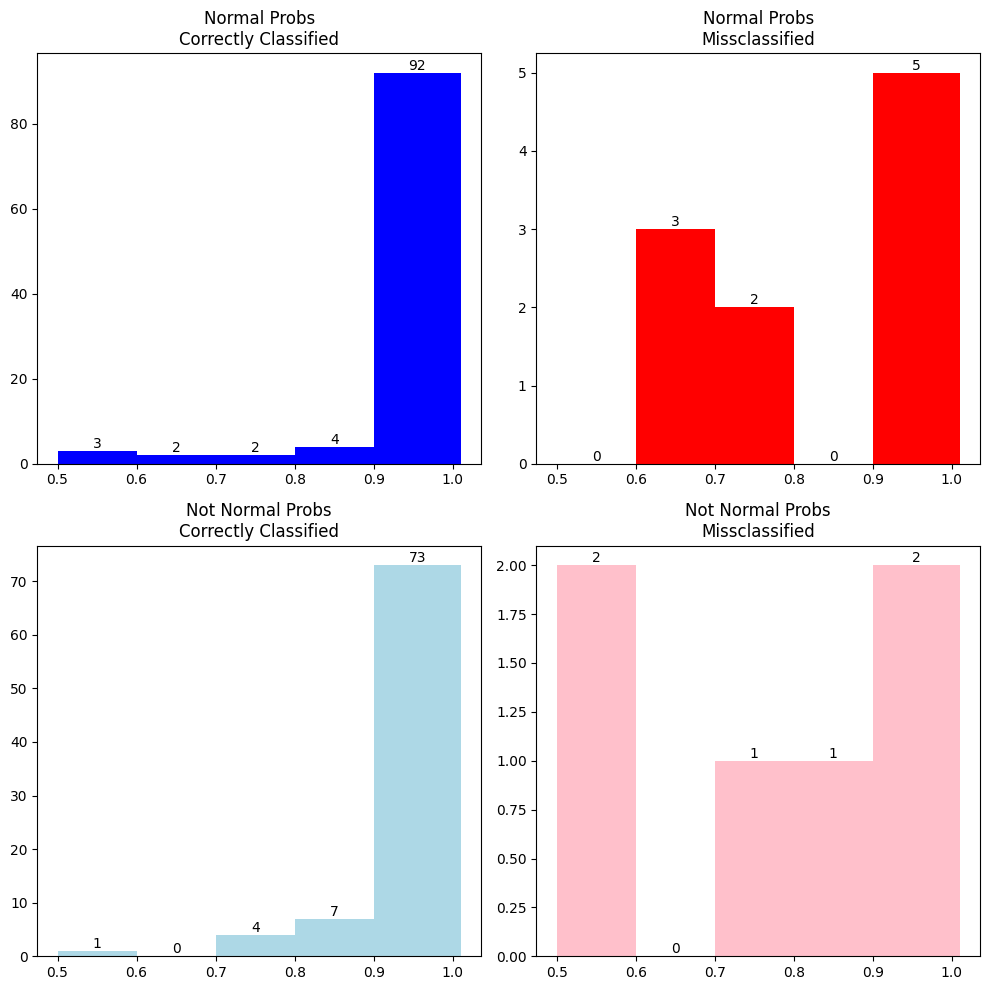

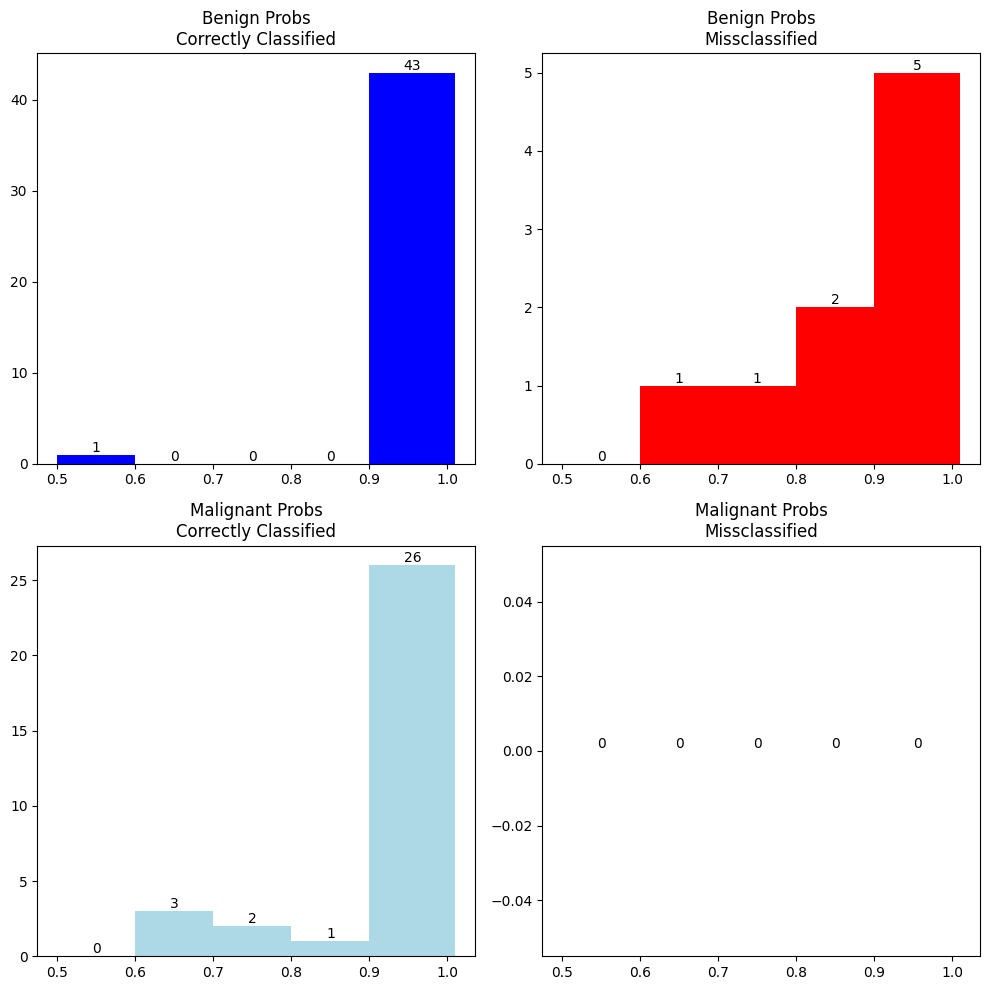

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.225, ECE: 0.052
Optimal temperature: 1.476
After temperature - NLL: 0.206, ECE: 0.022
Best Optimal temperature: 1.500
After best temperature - NLL: 0.206, ECE: 0.019


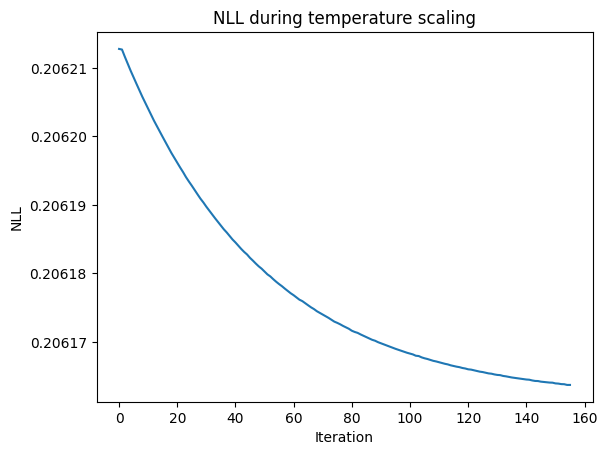

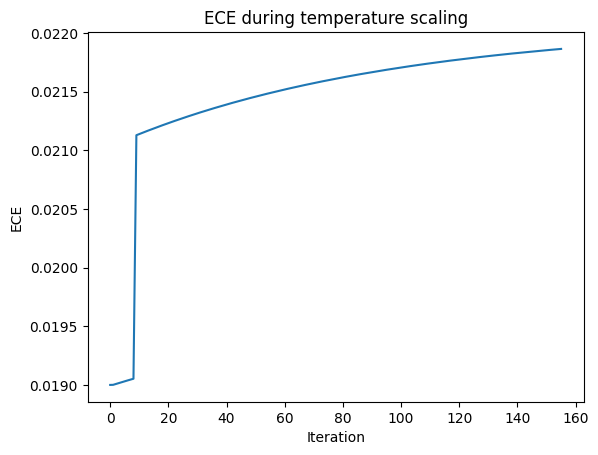

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.415, ECE: 0.091
Optimal temperature: 2.401
After temperature - NLL: 0.284, ECE: 0.050
Best Optimal temperature: 2.354
After best temperature - NLL: 0.284, ECE: 0.046


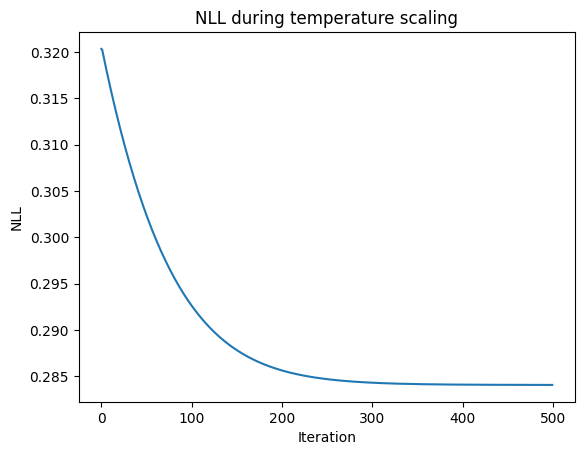

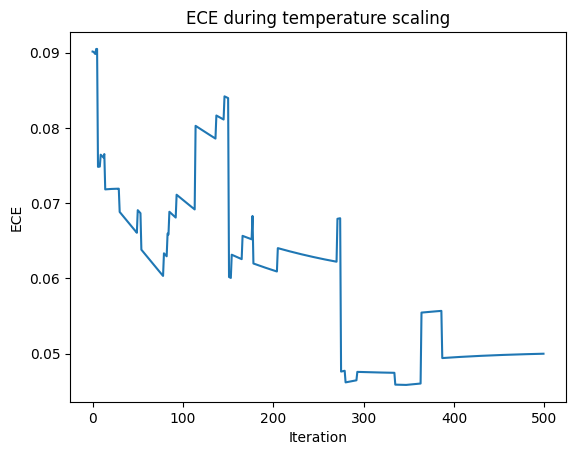

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

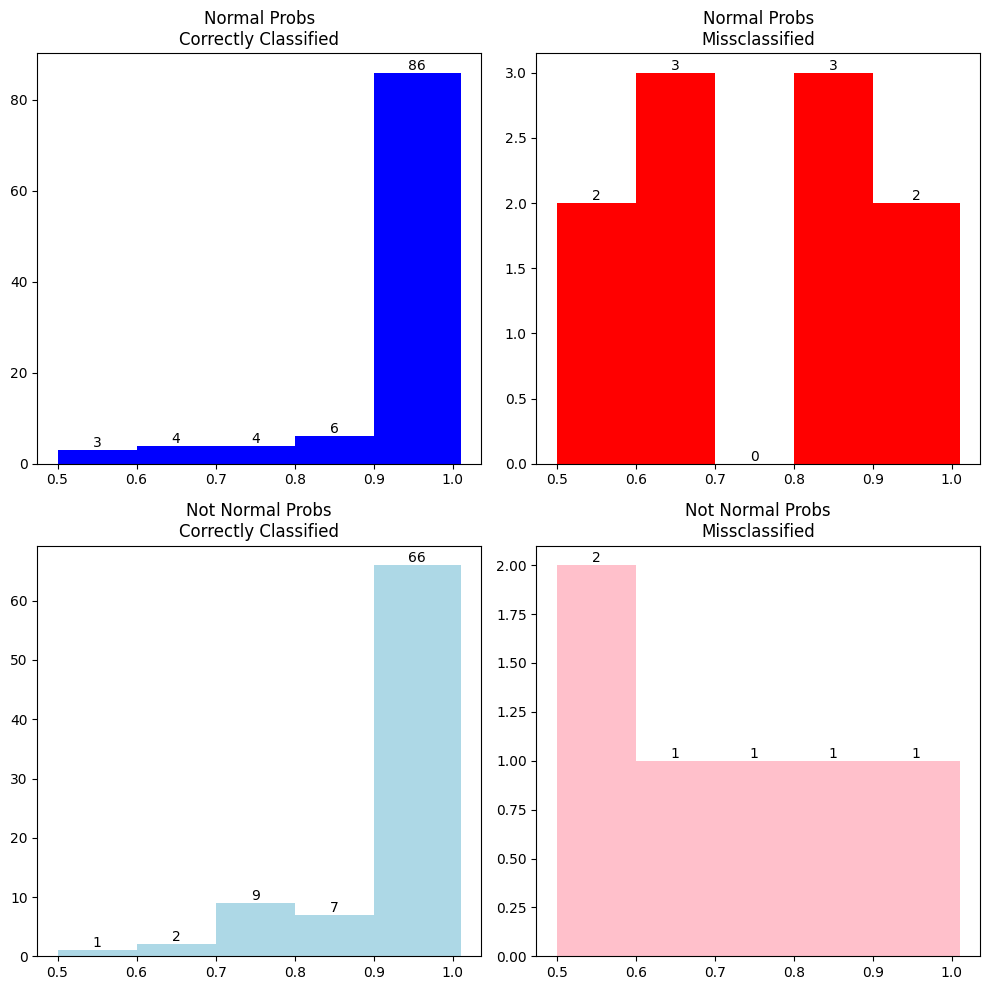

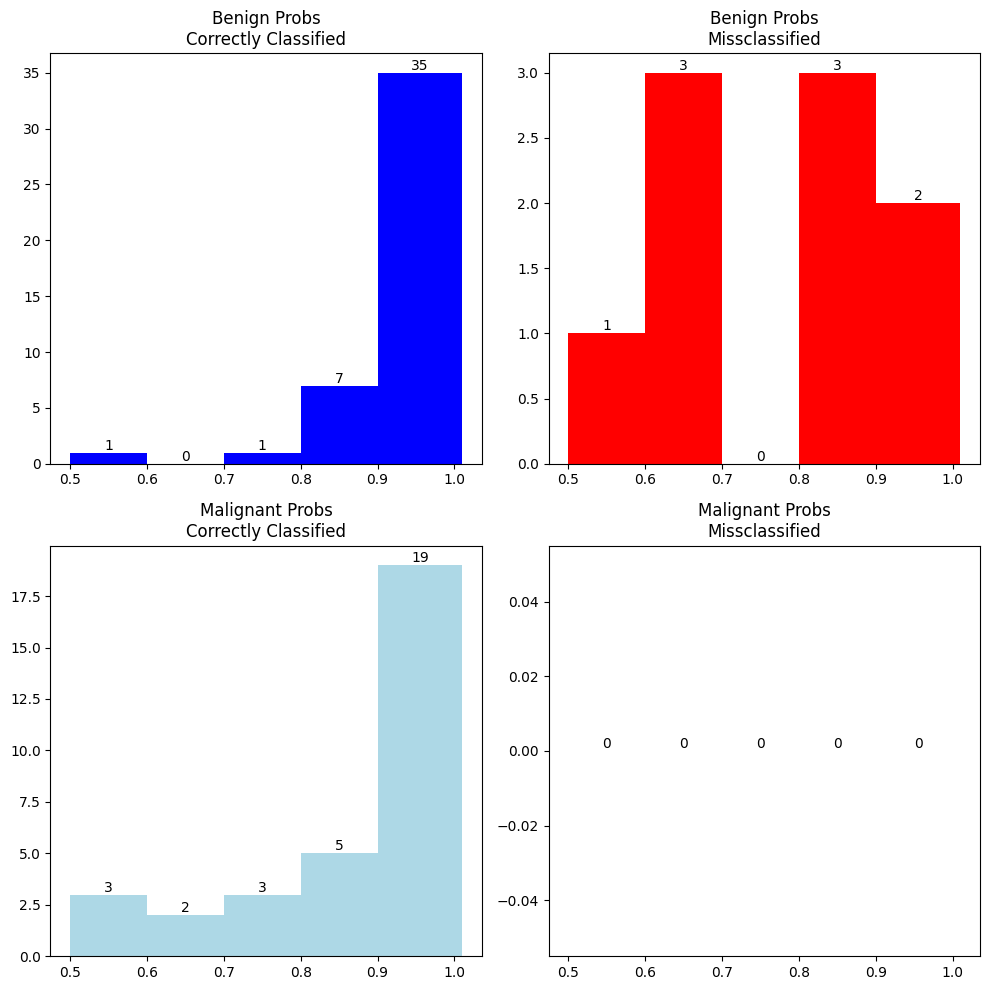

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold1

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold1: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_136.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_1_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7459772229194641, median IoU: 0.7707620859146118
TP: 203, FN: 0, FP: 1
Precision: 0.9950980392156863
Recall: 1.0
Acc: 0.9363 Spec: 0.9937 Sens: 0.9111
Normal vs Not Noraml Acc: 0.9608 Benign vs Malignant Acc: 0.9462


### Eval Results

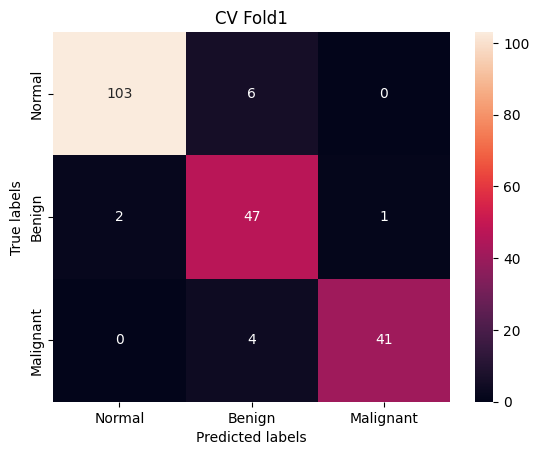

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold1')
plt.show()



---



#### Plots

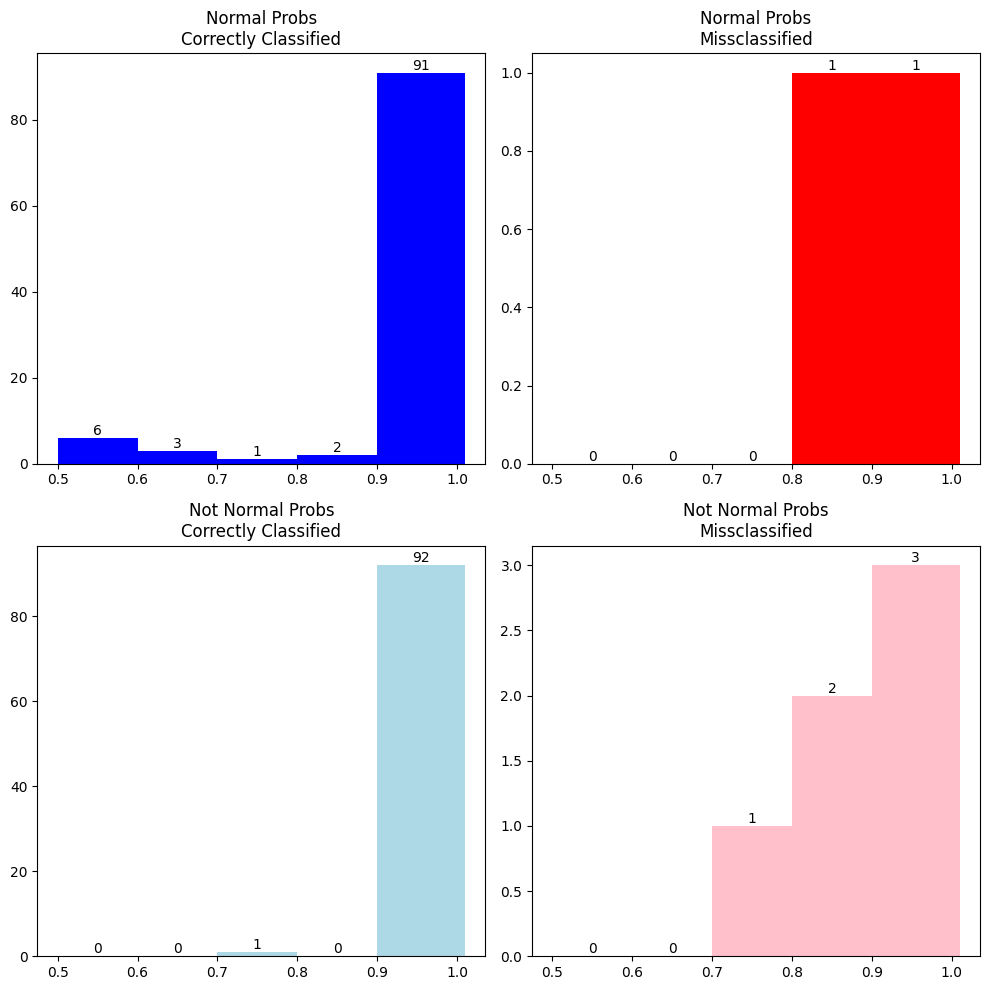

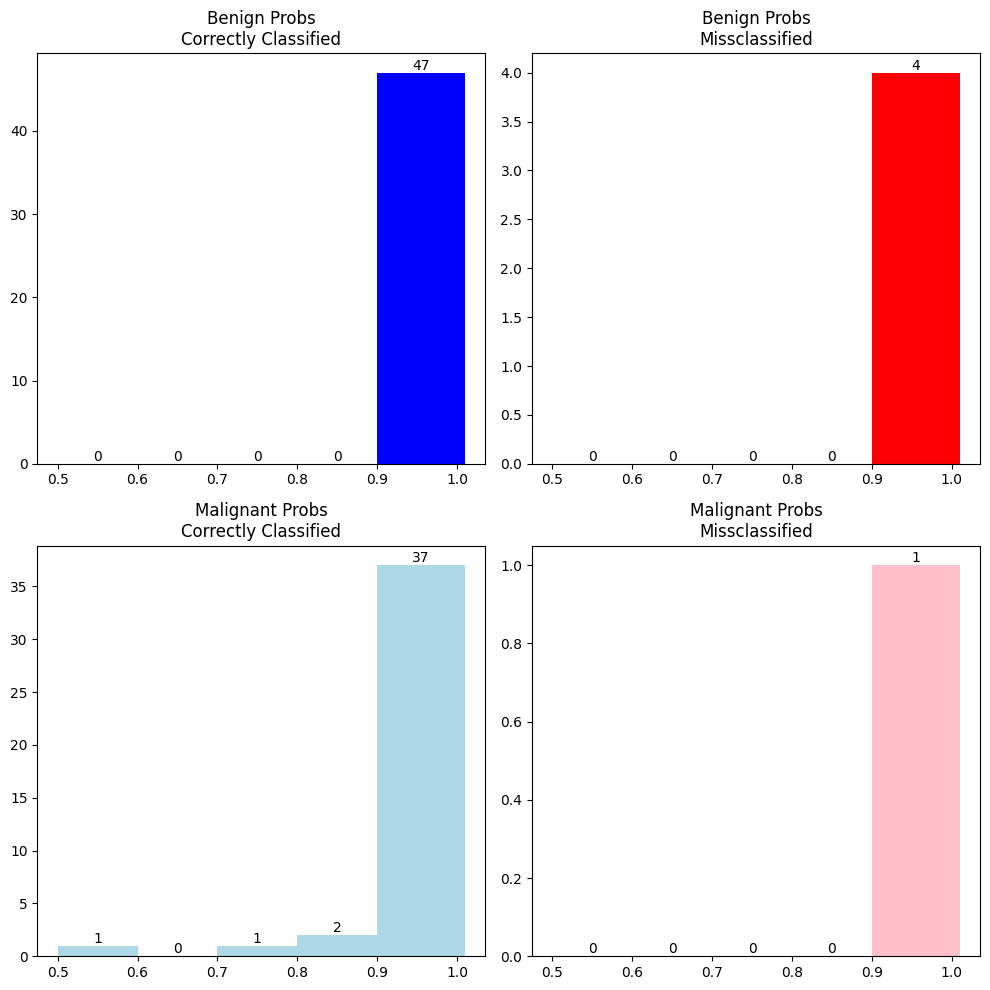

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.171, ECE: 0.047
Optimal temperature: 1.872
After temperature - NLL: 0.137, ECE: 0.040
Best Optimal temperature: 1.838
After best temperature - NLL: 0.137, ECE: 0.039


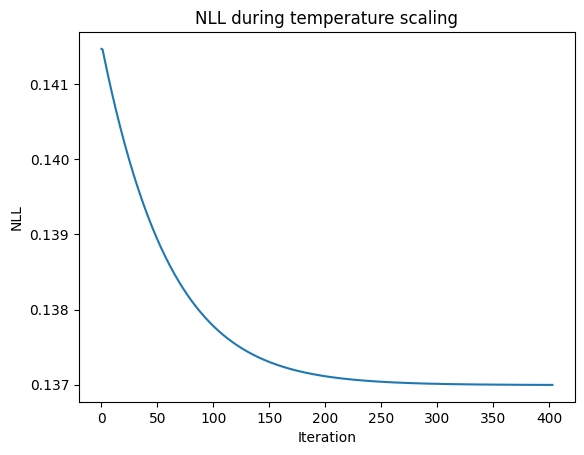

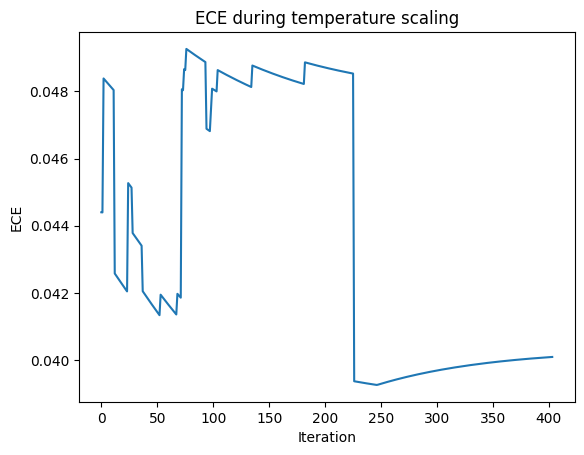

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.278, ECE: 0.055
Optimal temperature: 2.484
After temperature - NLL: 0.172, ECE: 0.033
Best Optimal temperature: 2.484
After best temperature - NLL: 0.172, ECE: 0.033


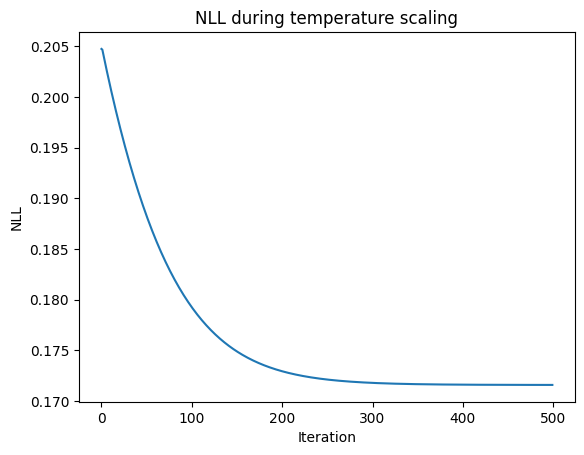

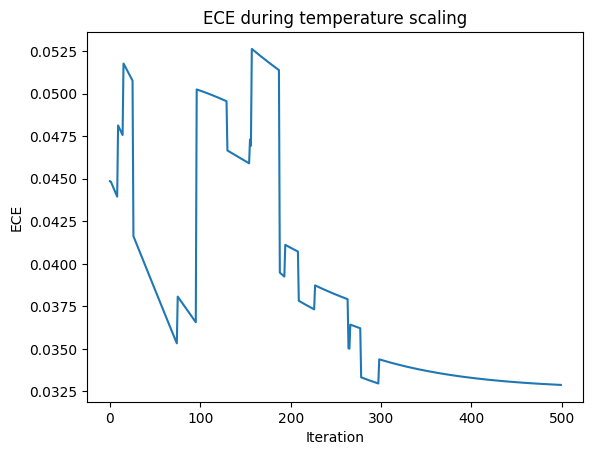

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

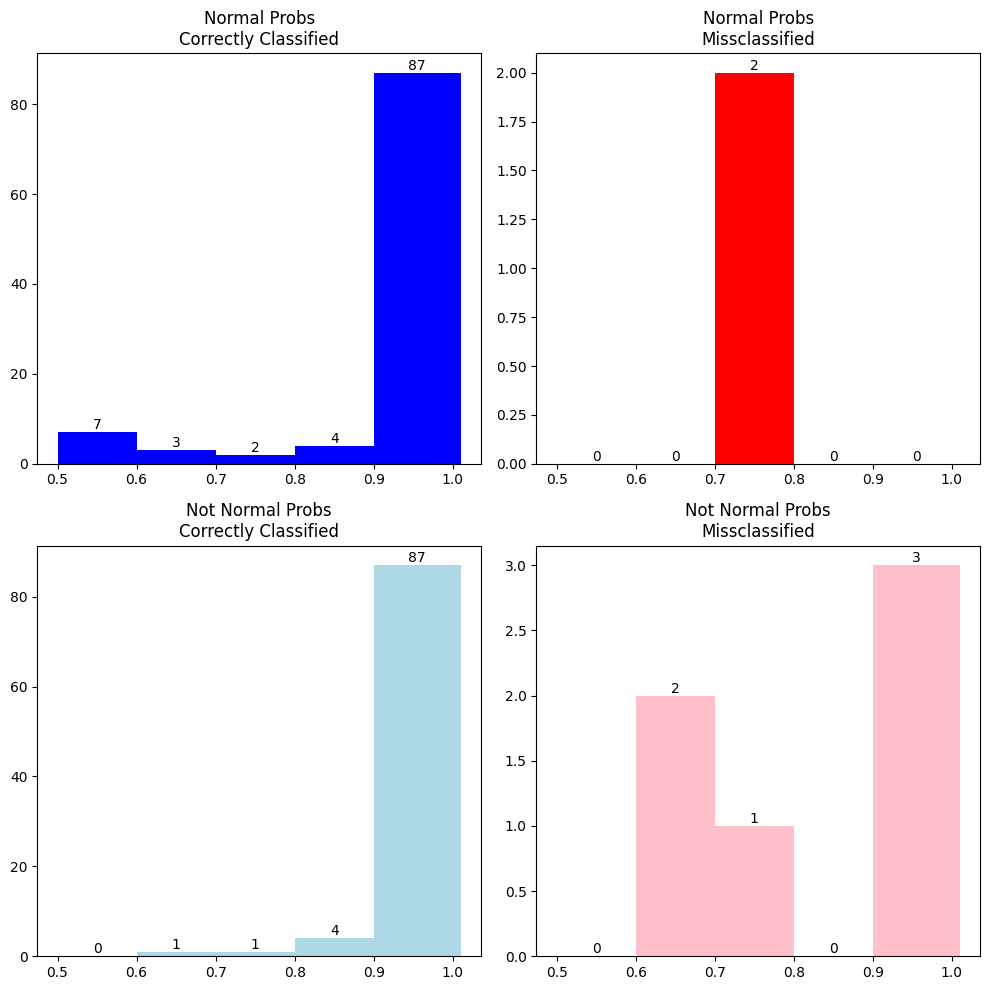

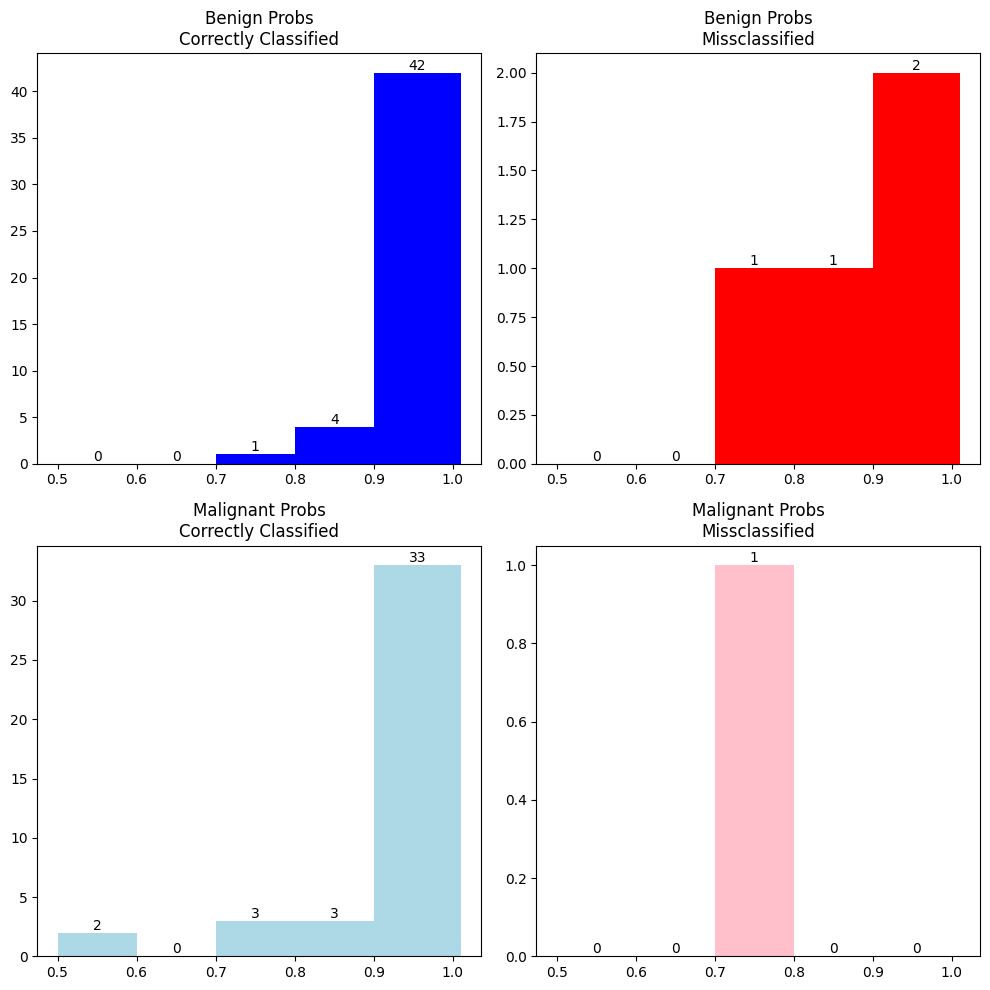

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold2

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold2: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_100.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_2_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7440788745880127, median IoU: 0.7770698666572571
TP: 202, FN: 0, FP: 2
Precision: 0.9901960784313726
Recall: 1.0
Acc: 0.9314 Spec: 1.0000 Sens: 0.9200
Normal vs Not Noraml Acc: 0.9510 Benign vs Malignant Acc: 0.9592


### Eval Results

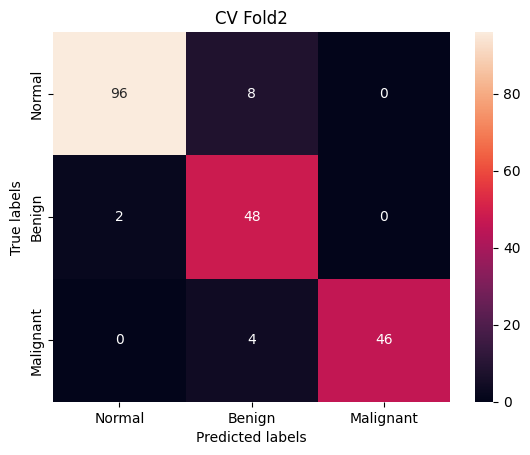

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold2')
plt.show()



---



#### Plots

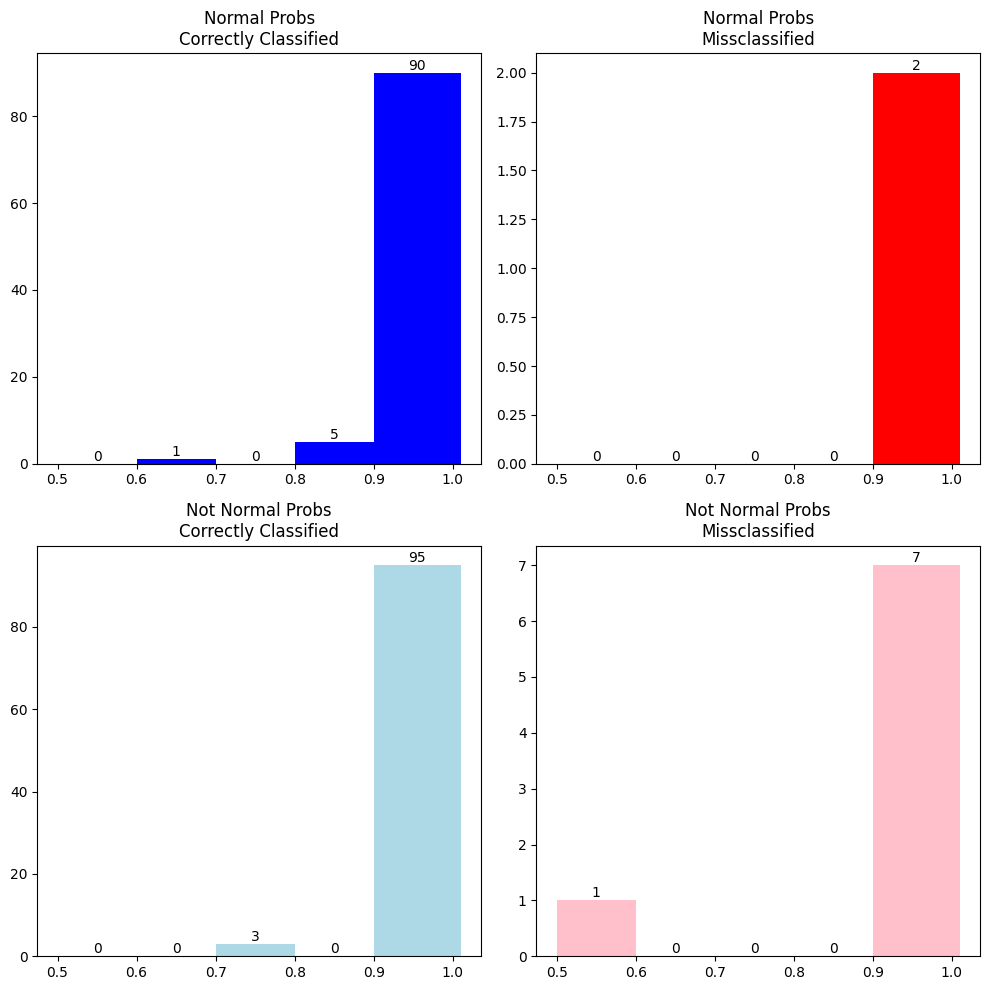

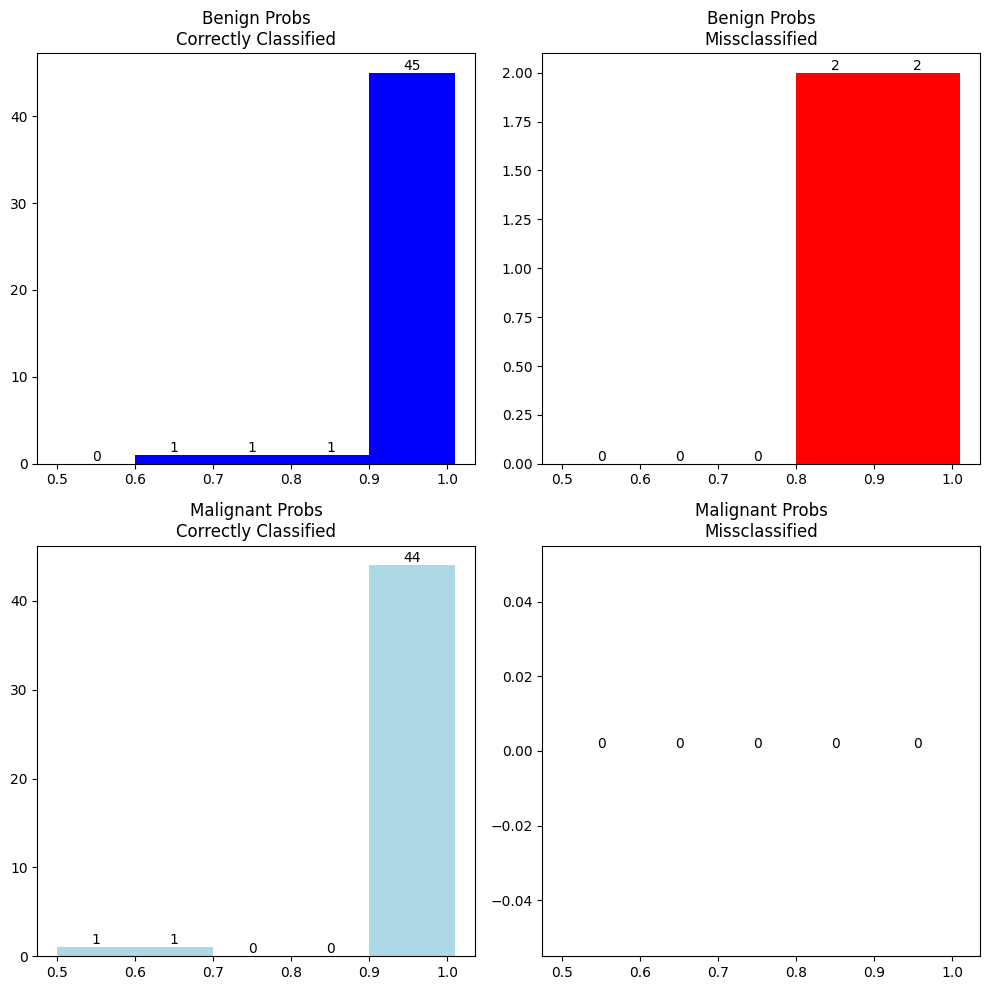

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.252, ECE: 0.054
Optimal temperature: 2.173
After temperature - NLL: 0.174, ECE: 0.026
Best Optimal temperature: 2.173
After best temperature - NLL: 0.174, ECE: 0.026


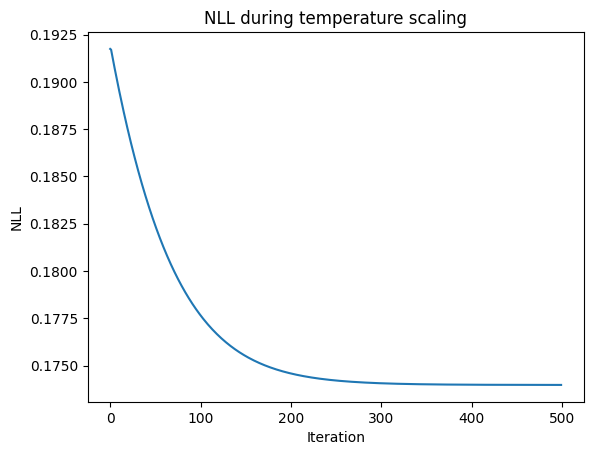

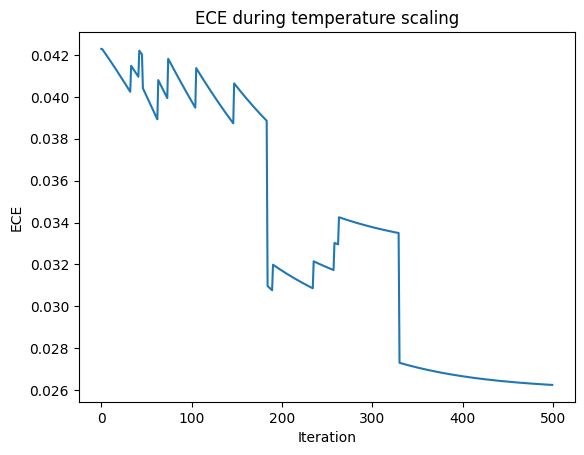

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.171, ECE: 0.048
Optimal temperature: 1.744
After temperature - NLL: 0.142, ECE: 0.040
Best Optimal temperature: 1.744
After best temperature - NLL: 0.142, ECE: 0.040


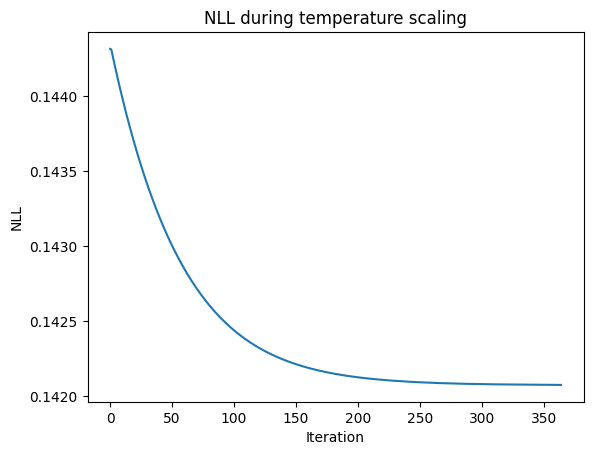

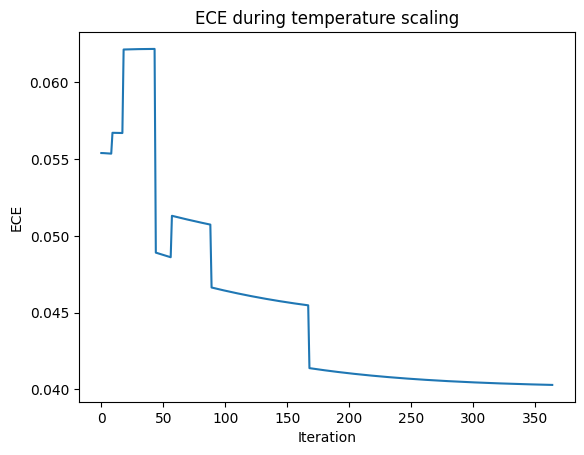

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

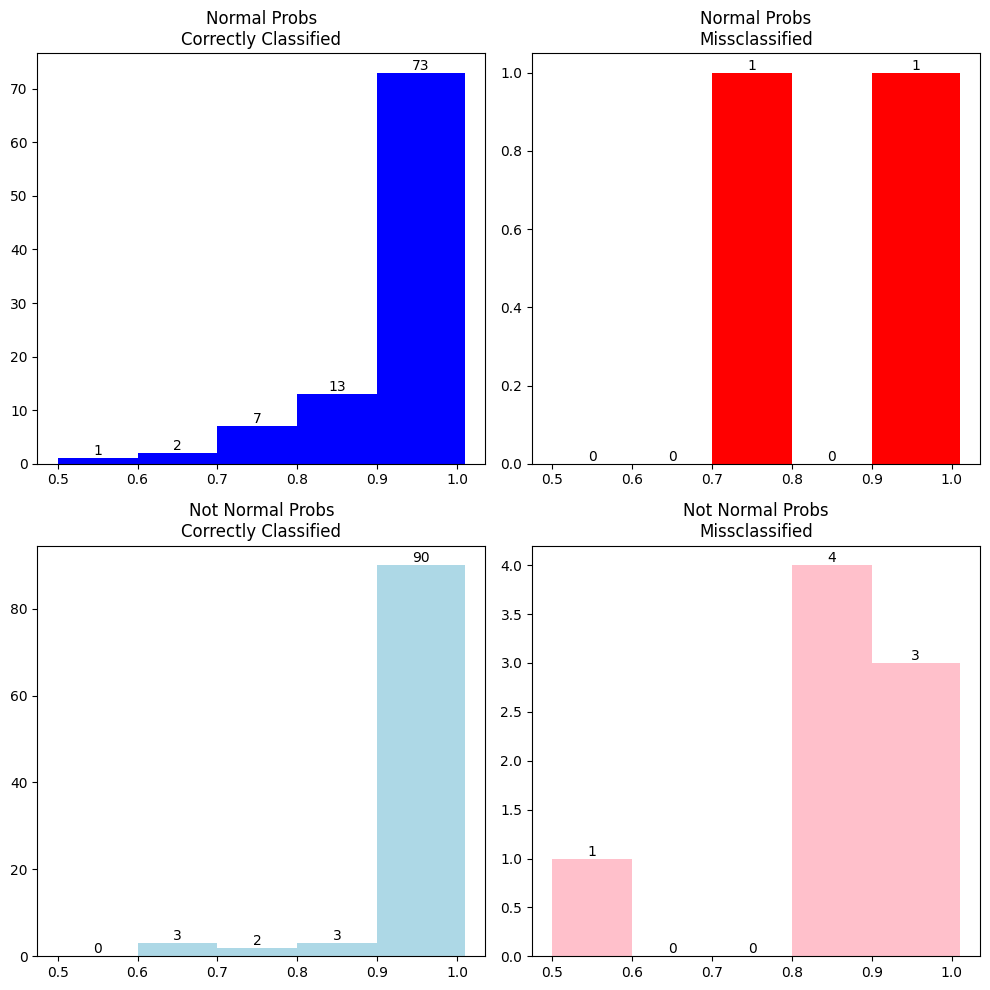

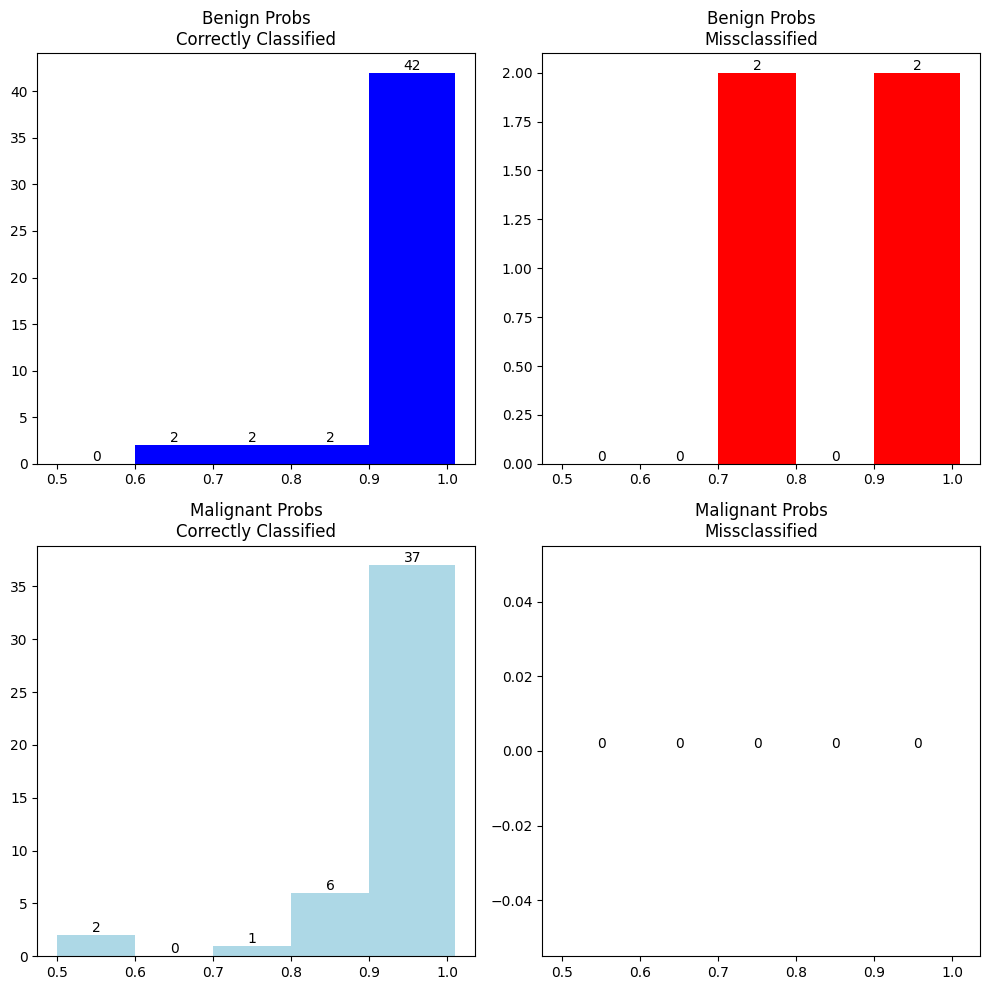

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold3

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold3: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_47.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_3_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7505821585655212, median IoU: 0.7674428820610046
TP: 202, FN: 0, FP: 2
Precision: 0.9901960784313726
Recall: 1.0
Acc: 0.9216 Spec: 0.9870 Sens: 0.9400
Normal vs Not Noraml Acc: 0.9461 Benign vs Malignant Acc: 0.9457


### Eval Results

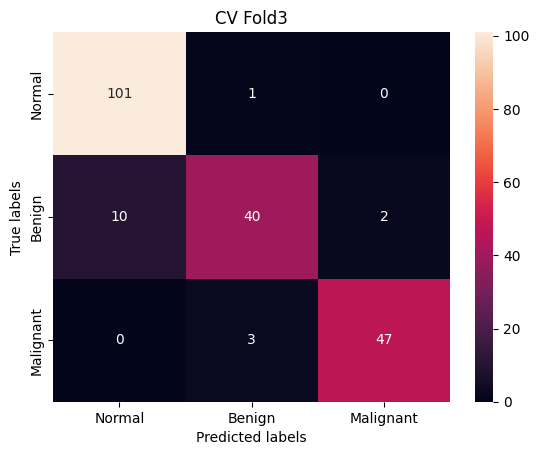

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold3')
plt.show()



---



#### Plots

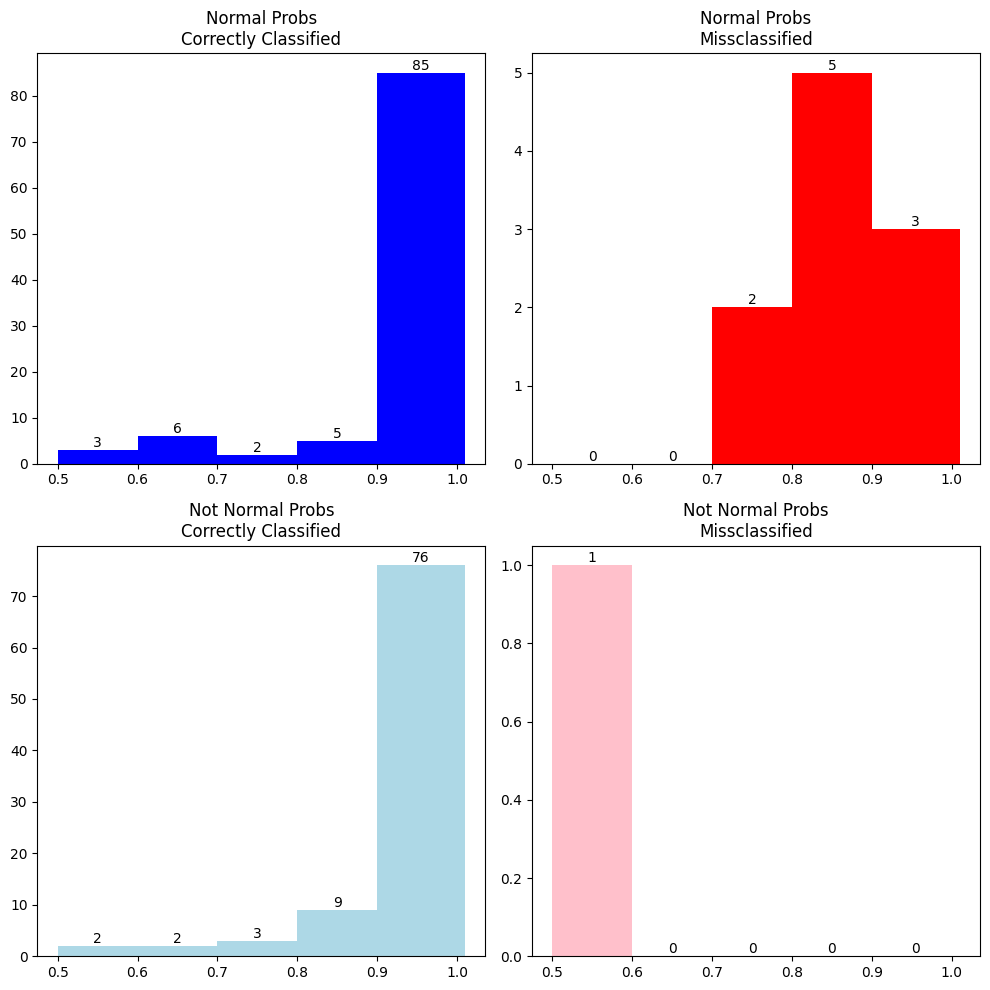

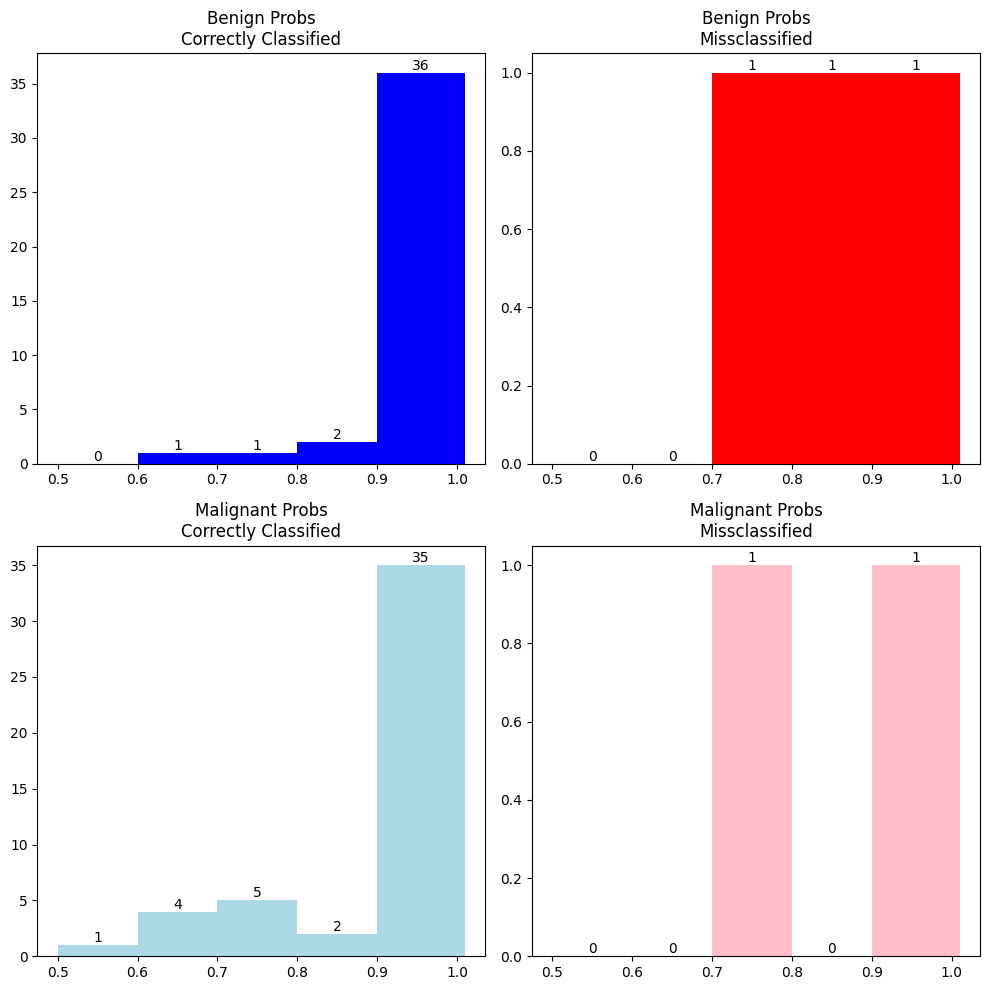

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.182, ECE: 0.039
Optimal temperature: 1.132
After temperature - NLL: 0.181, ECE: 0.037
Best Optimal temperature: 1.161
After best temperature - NLL: 0.181, ECE: 0.034


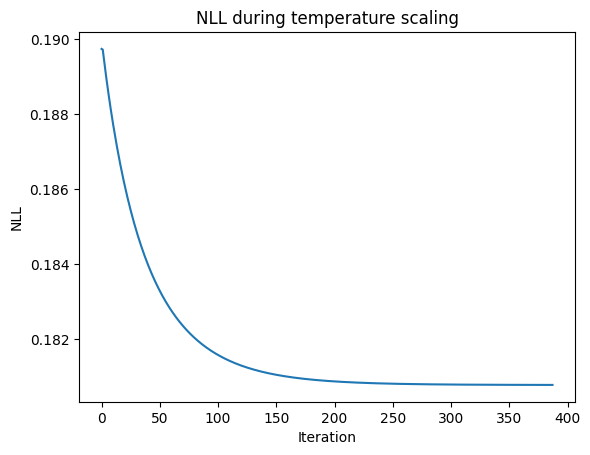

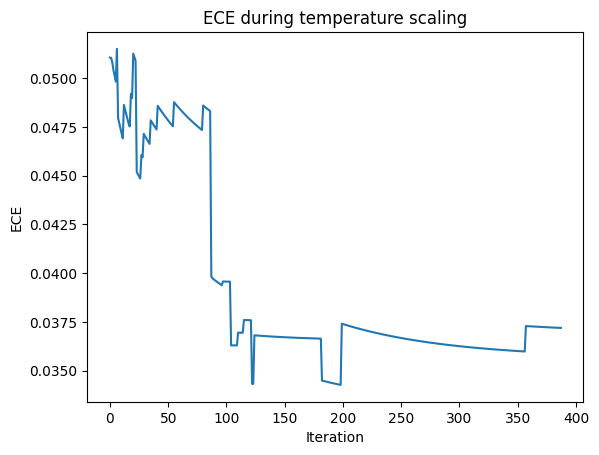

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.232, ECE: 0.060
Optimal temperature: 1.452
After temperature - NLL: 0.217, ECE: 0.049
Best Optimal temperature: 1.452
After best temperature - NLL: 0.217, ECE: 0.049


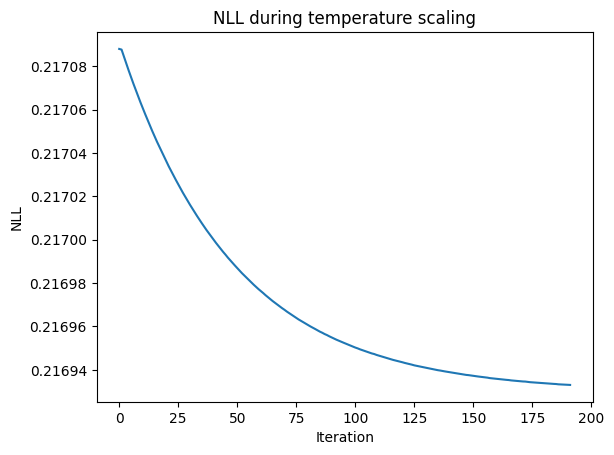

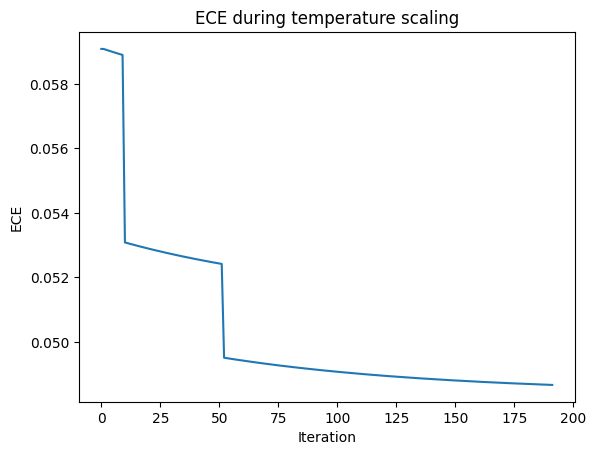

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

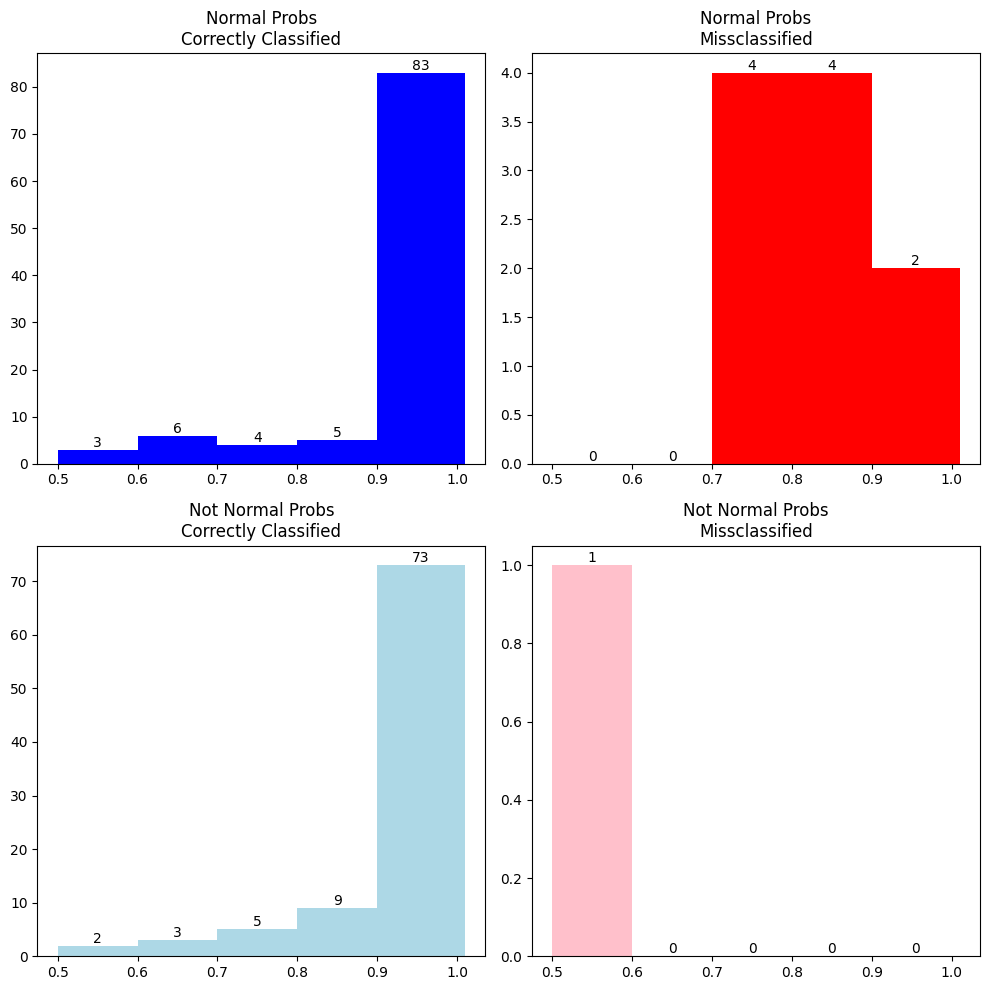

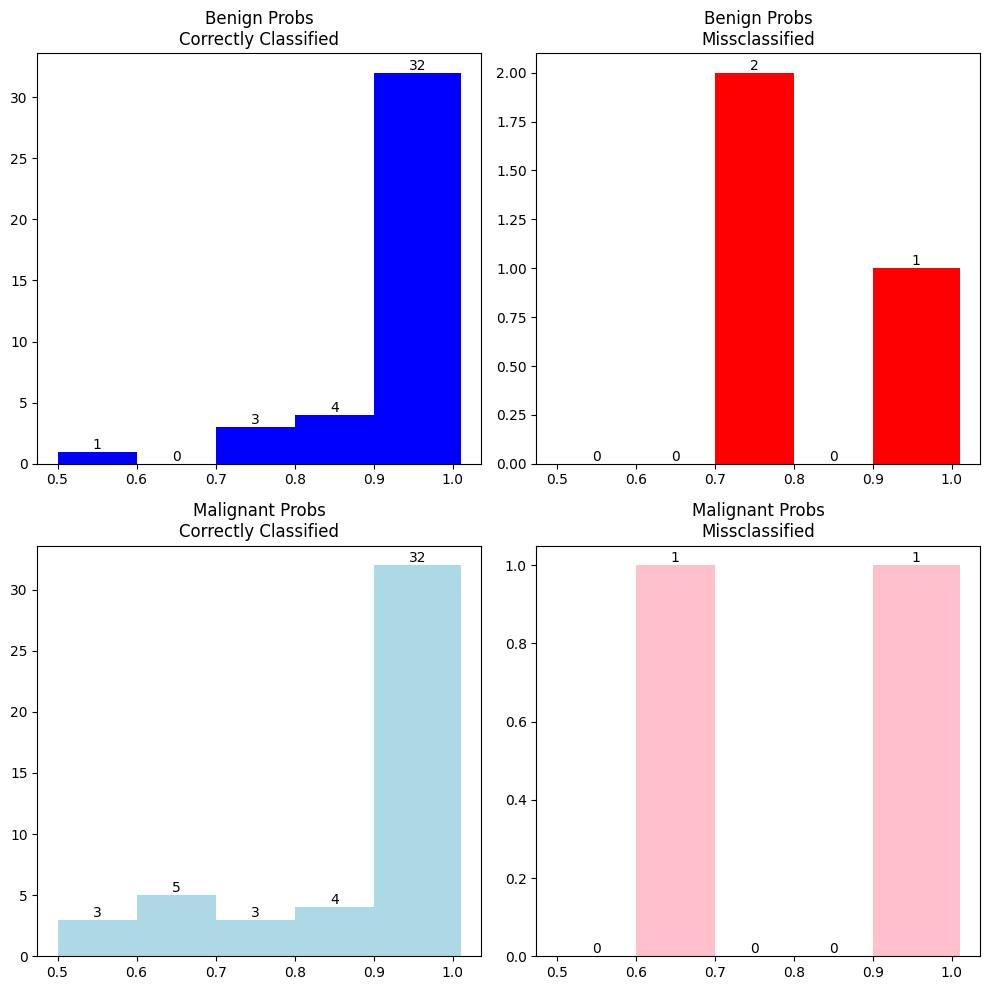

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold4

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold4: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_137.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_4_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7618073225021362, median IoU: 0.7797846794128418
TP: 204, FN: 0, FP: 0
Precision: 1.0
Recall: 1.0
Acc: 0.9559 Spec: 0.9936 Sens: 0.9583
Normal vs Not Noraml Acc: 0.9706 Benign vs Malignant Acc: 0.9694


### Eval Results

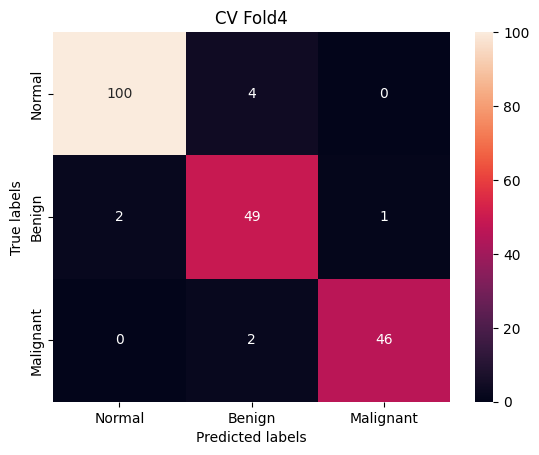

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold4')
plt.show()



---



#### Plots

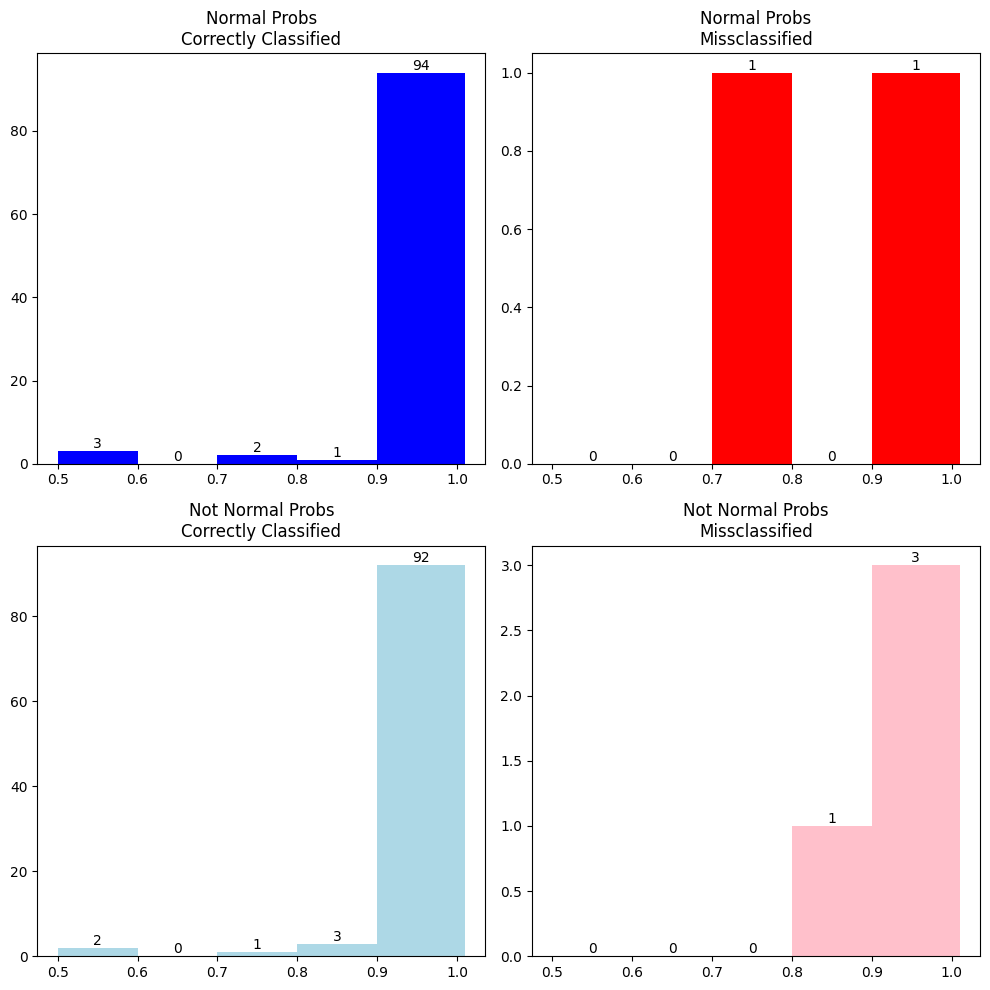

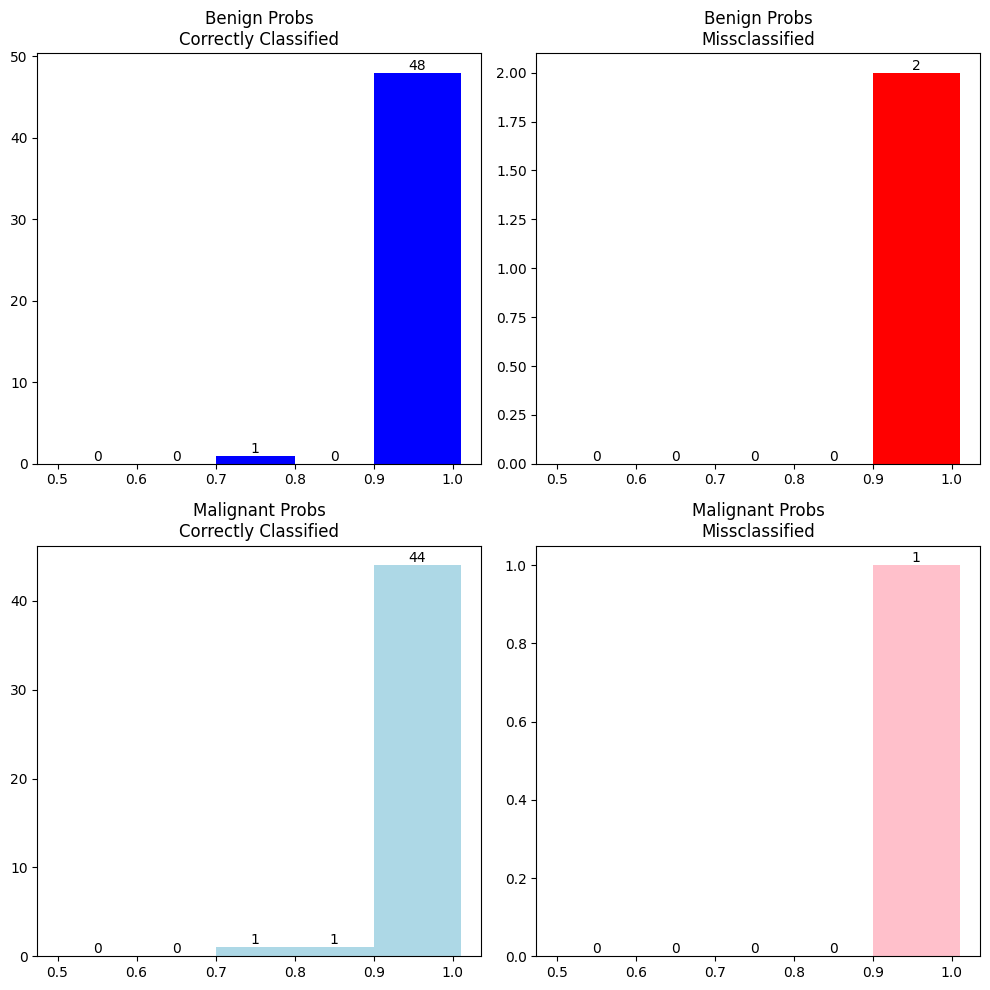

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.120, ECE: 0.034
Optimal temperature: 1.688
After temperature - NLL: 0.102, ECE: 0.024
Best Optimal temperature: 1.688
After best temperature - NLL: 0.102, ECE: 0.024


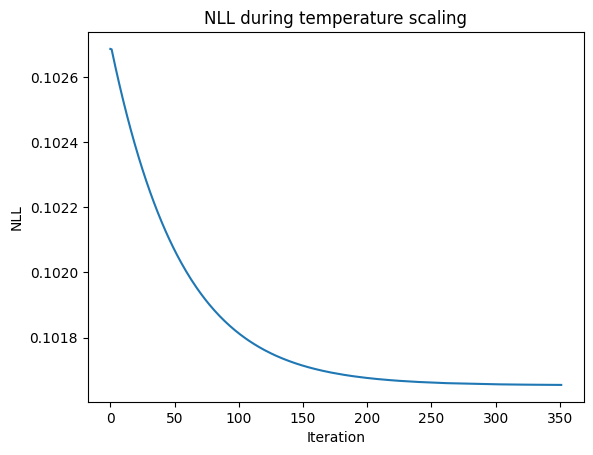

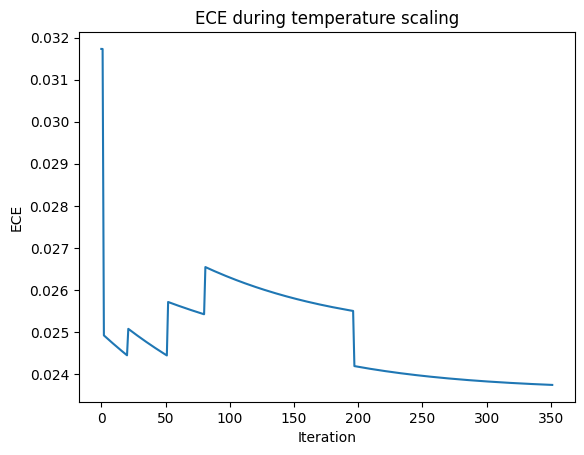

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.127, ECE: 0.030
Optimal temperature: 1.869
After temperature - NLL: 0.097, ECE: 0.021
Best Optimal temperature: 1.797
After best temperature - NLL: 0.097, ECE: 0.020


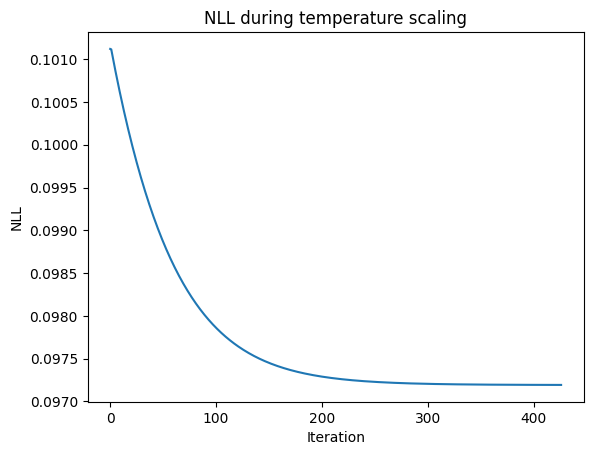

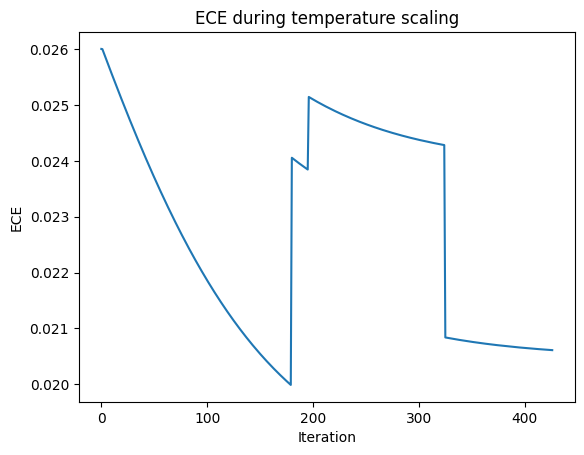

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

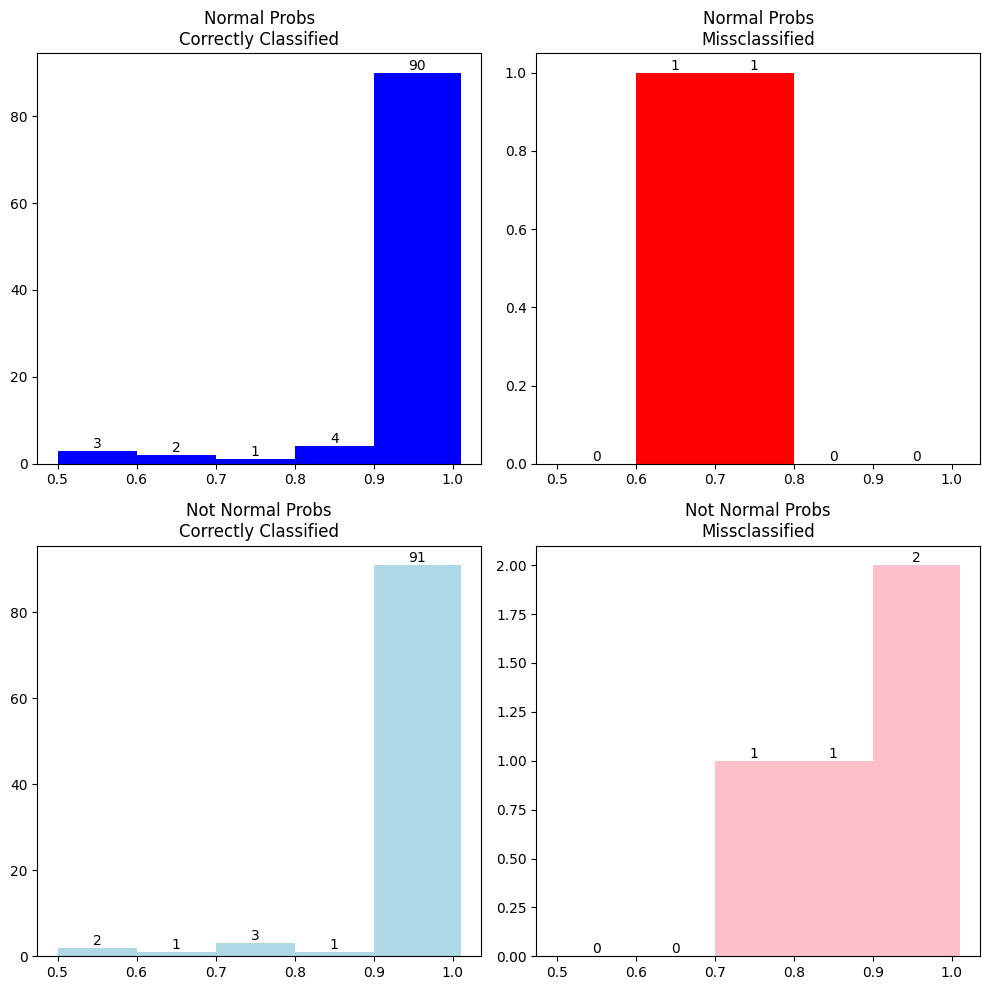

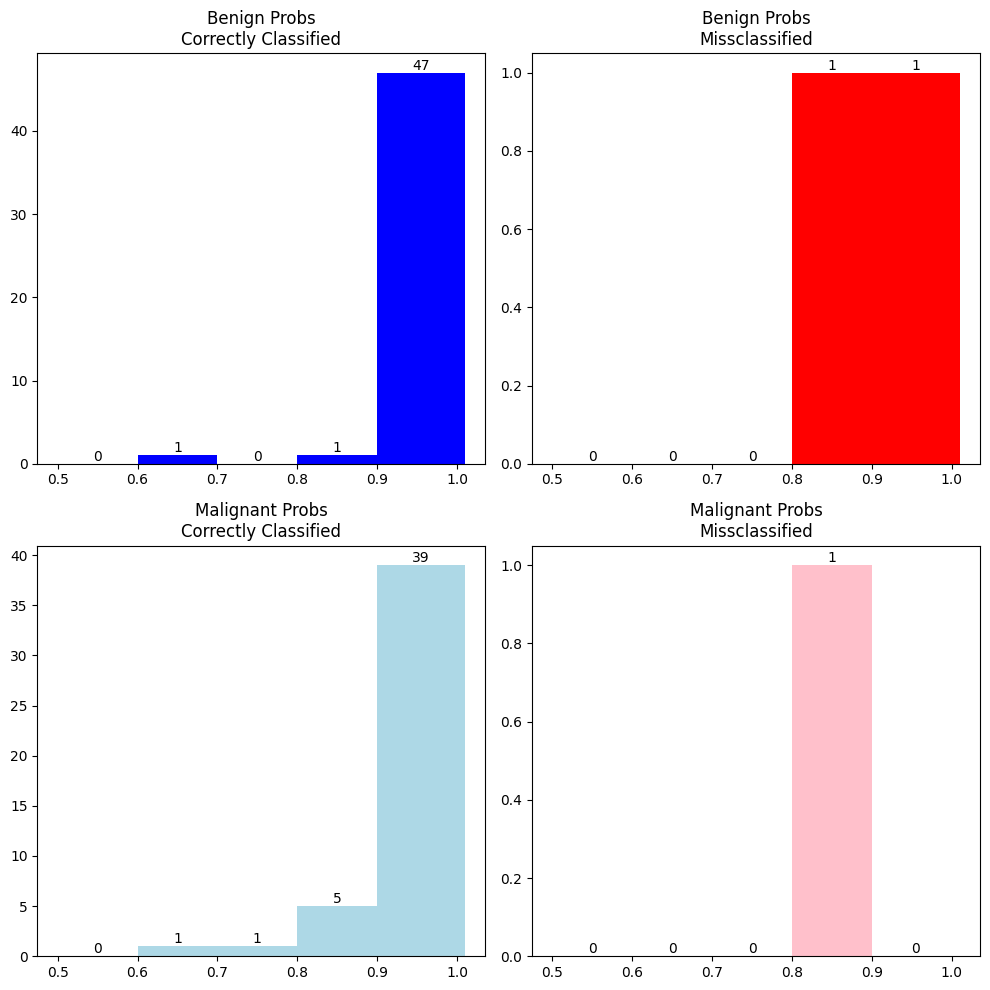

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold5

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold5: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_33.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_5_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7256550788879395, median IoU: 0.7719655632972717
TP: 199, FN: 0, FP: 5
Precision: 0.9754901960784313
Recall: 1.0
Acc: 0.8627 Spec: 0.9815 Sens: 0.8095
Normal vs Not Noraml Acc: 0.9167 Benign vs Malignant Acc: 0.8750


### Eval Results

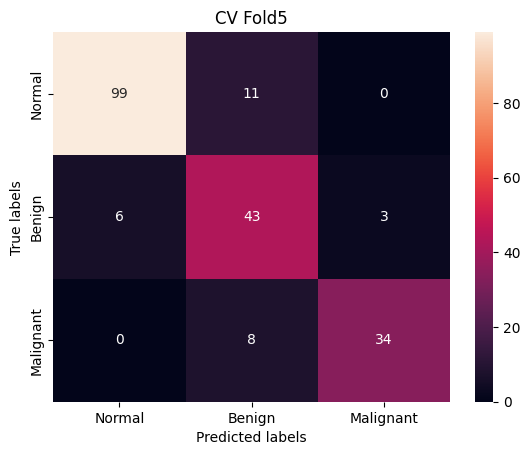

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold5')
plt.show()



---



#### Plots

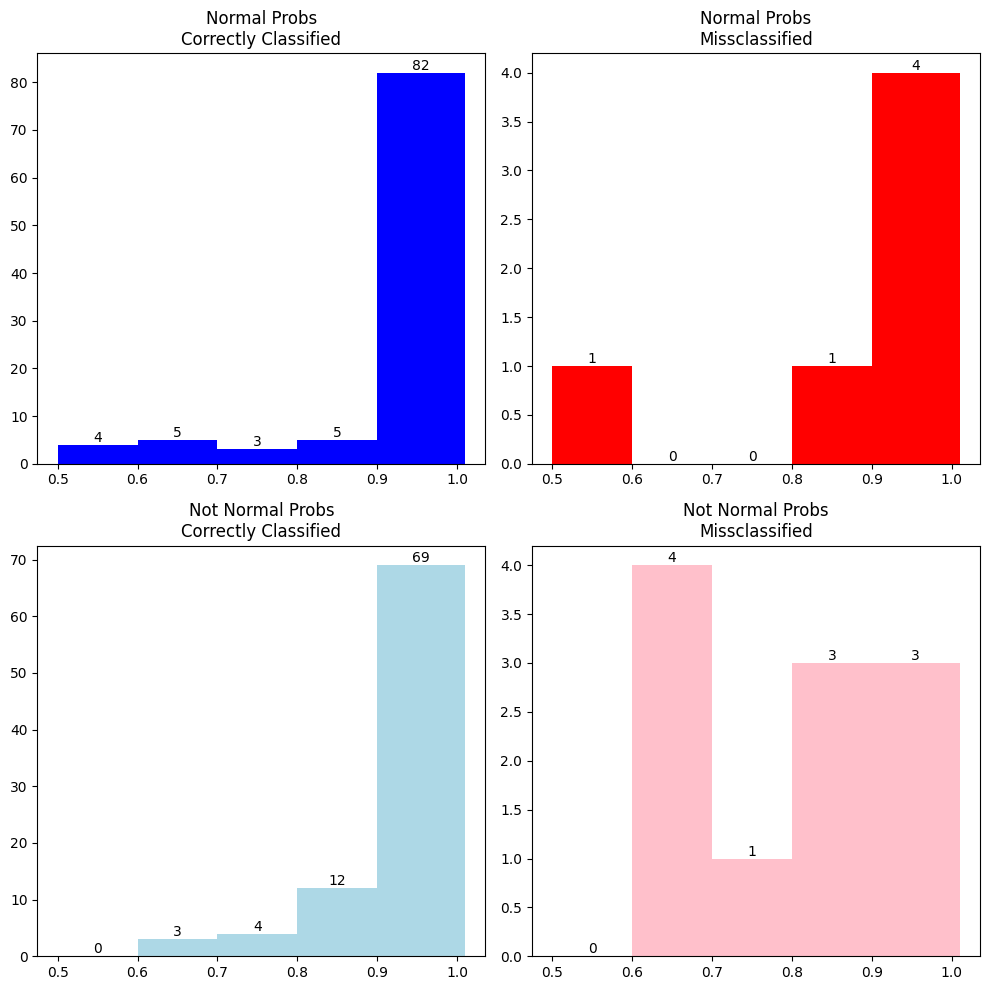

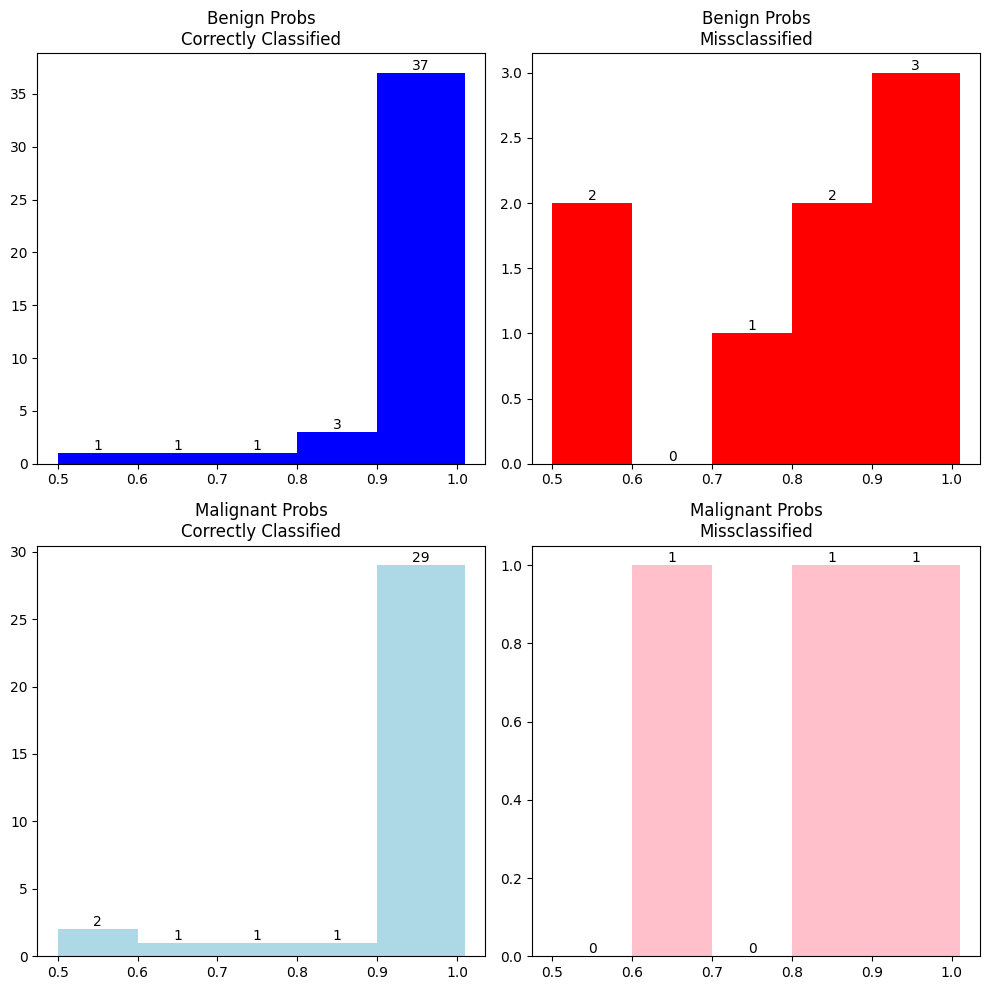

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.239, ECE: 0.033
Optimal temperature: 1.137
After temperature - NLL: 0.236, ECE: 0.056
Best Optimal temperature: 1.351
After best temperature - NLL: 0.241, ECE: 0.030


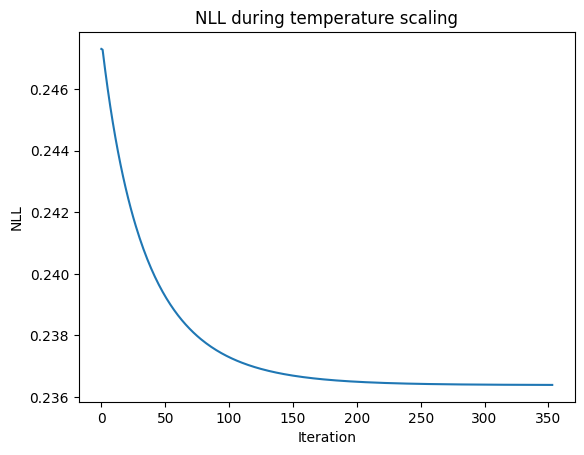

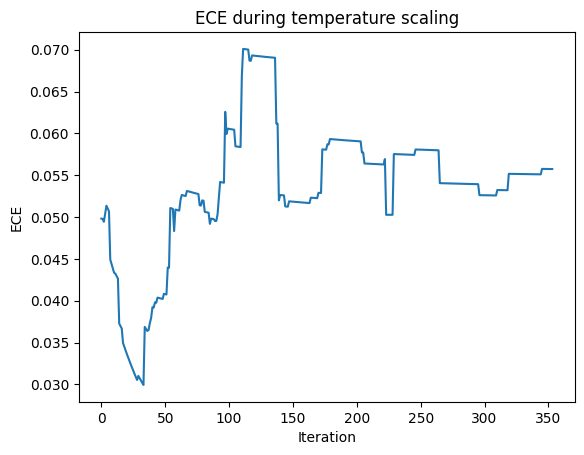

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.316, ECE: 0.100
Optimal temperature: 1.570
After temperature - NLL: 0.283, ECE: 0.058
Best Optimal temperature: 1.550
After best temperature - NLL: 0.283, ECE: 0.057


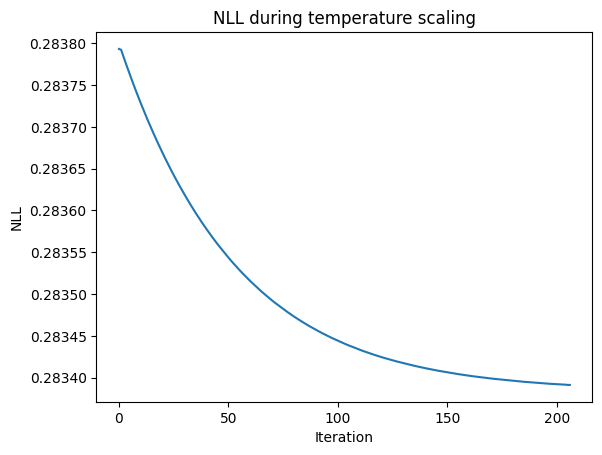

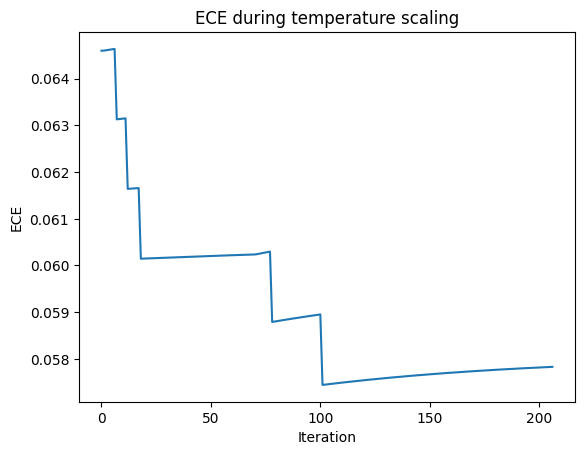

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

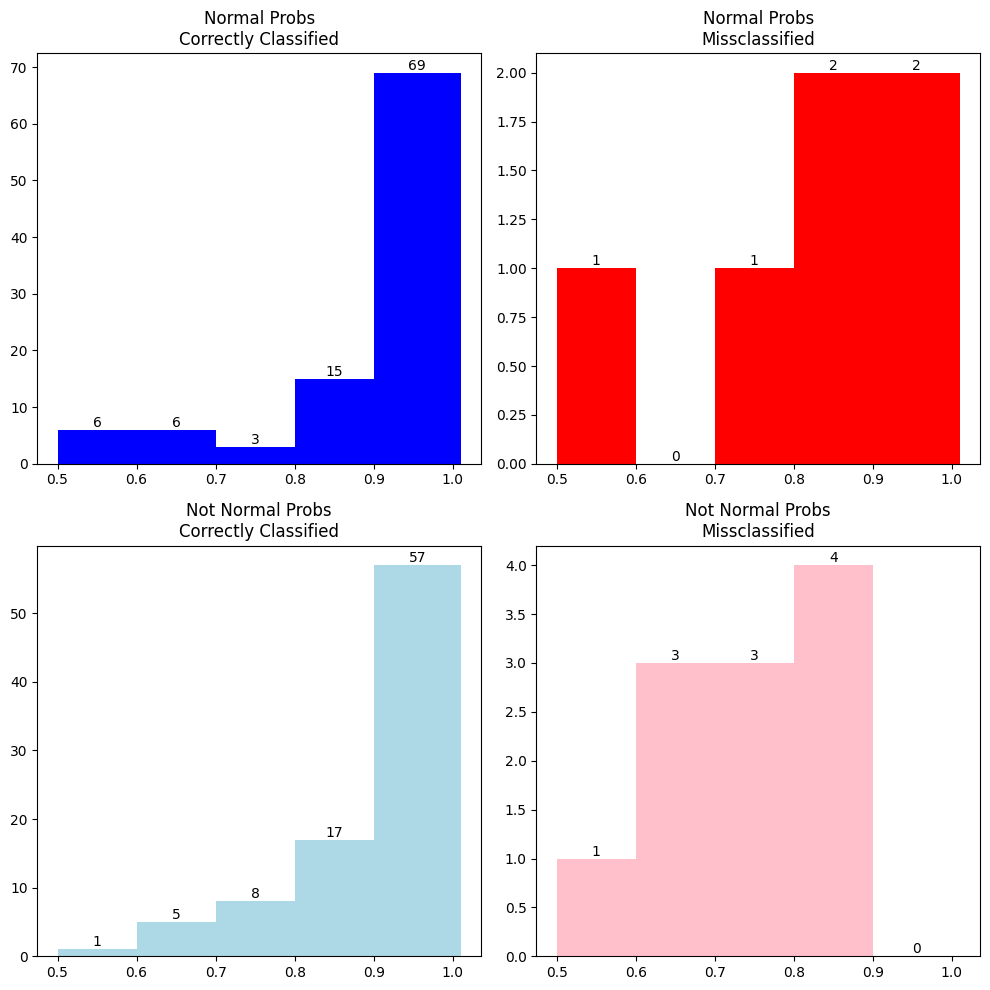

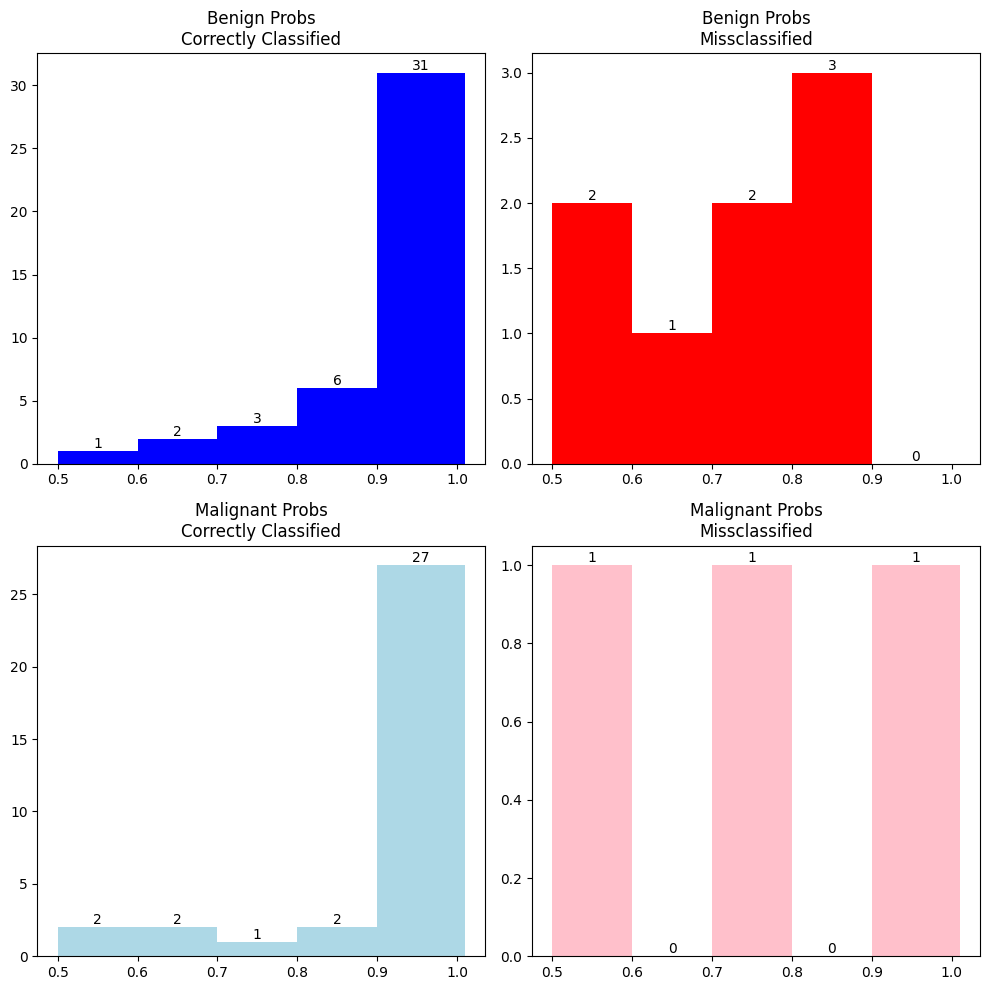

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold6

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold6: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_41.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_6_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7290292978286743, median IoU: 0.7583010792732239
TP: 200, FN: 0, FP: 3
Precision: 0.9852216748768473
Recall: 1.0
Acc: 0.9212 Spec: 0.9931 Sens: 0.8814
Normal vs Not Noraml Acc: 0.9310 Benign vs Malignant Acc: 0.9792


### Eval Results

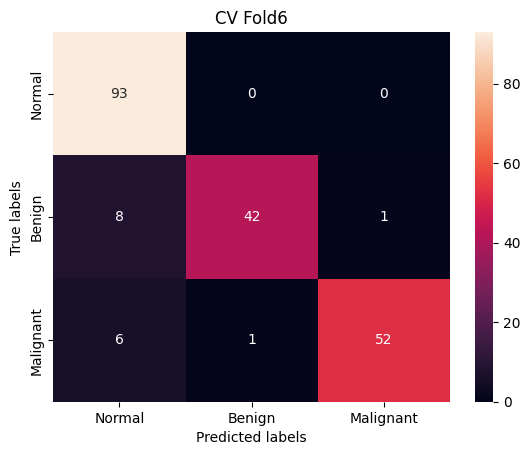

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold6')
plt.show()



---



#### Plots

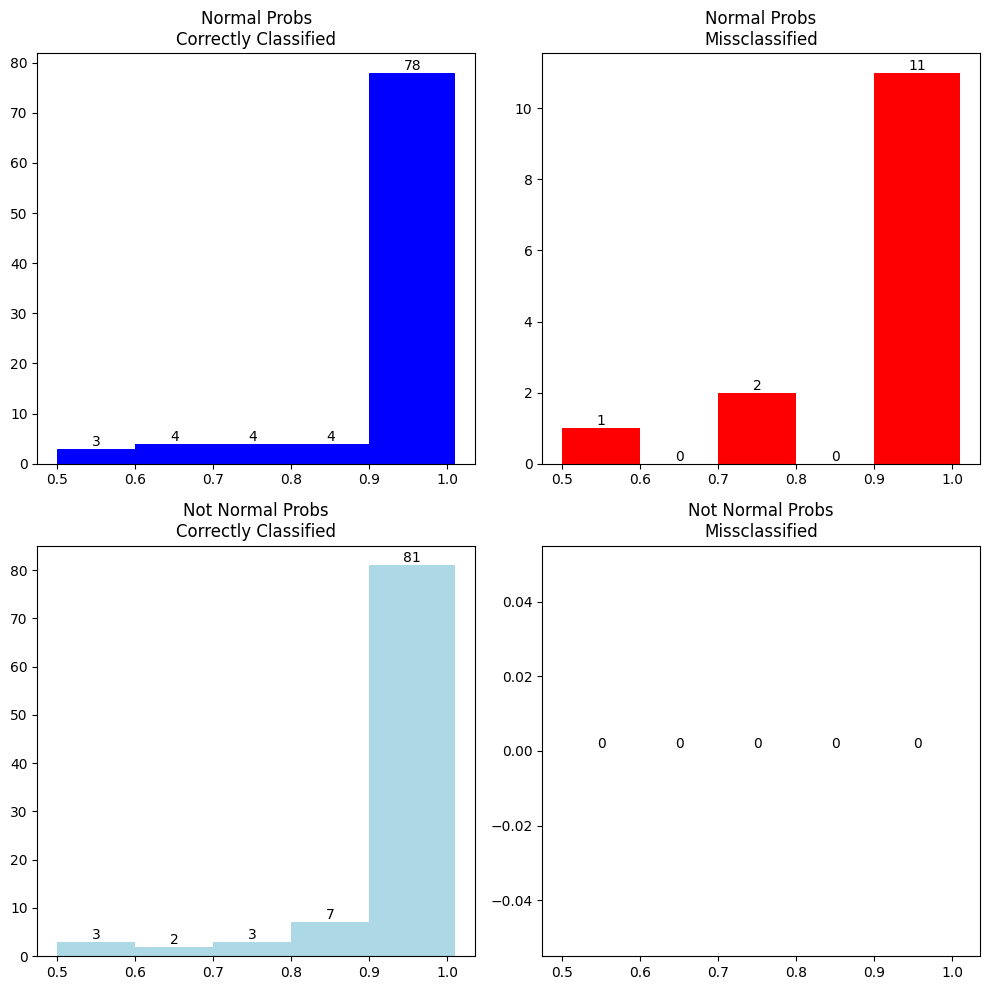

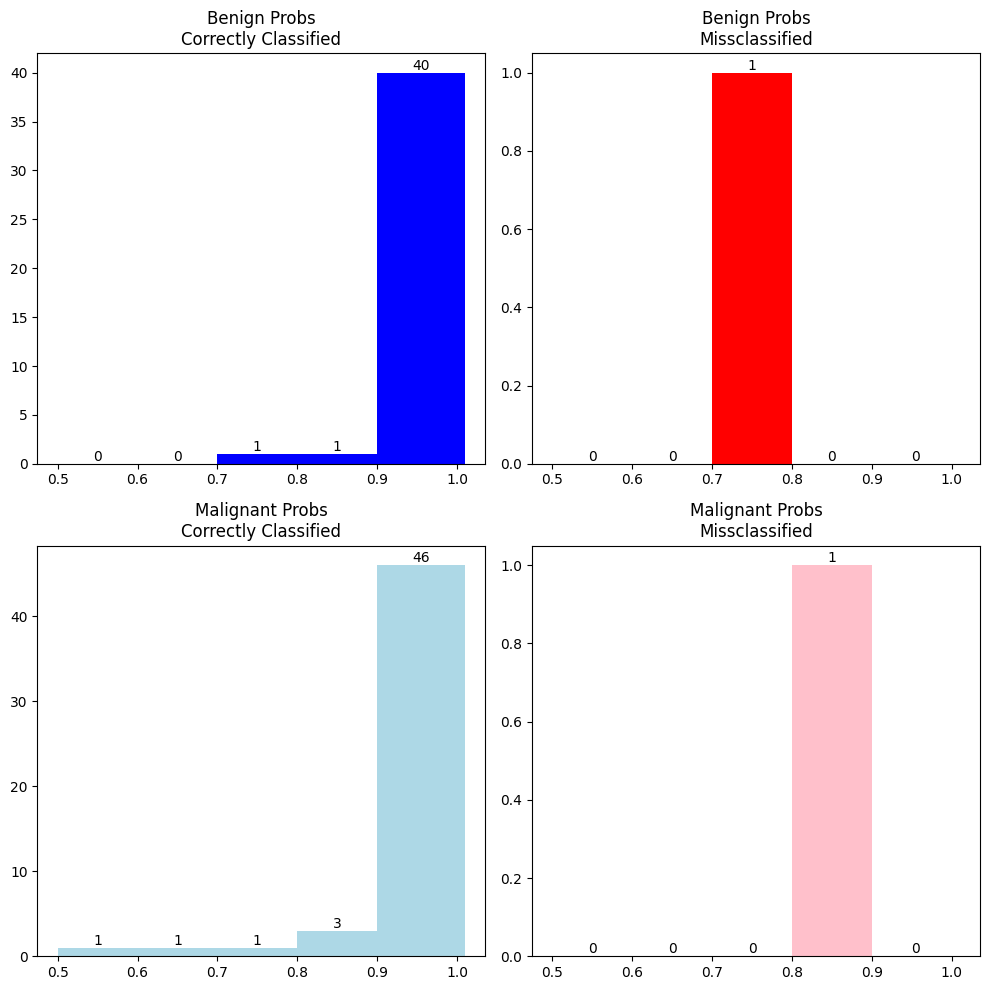

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.253, ECE: 0.074
Optimal temperature: 1.446
After temperature - NLL: 0.234, ECE: 0.062
Best Optimal temperature: 1.463
After best temperature - NLL: 0.234, ECE: 0.061


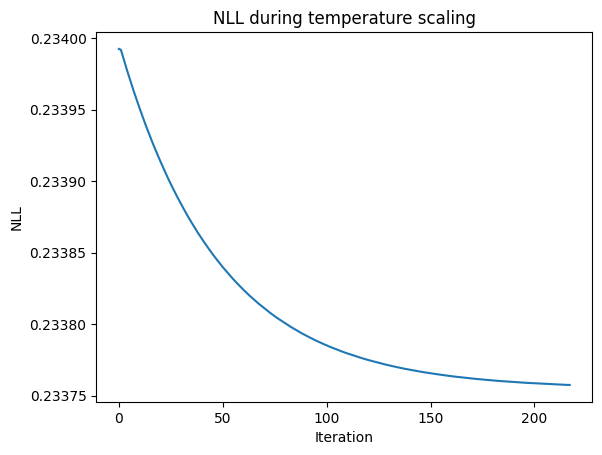

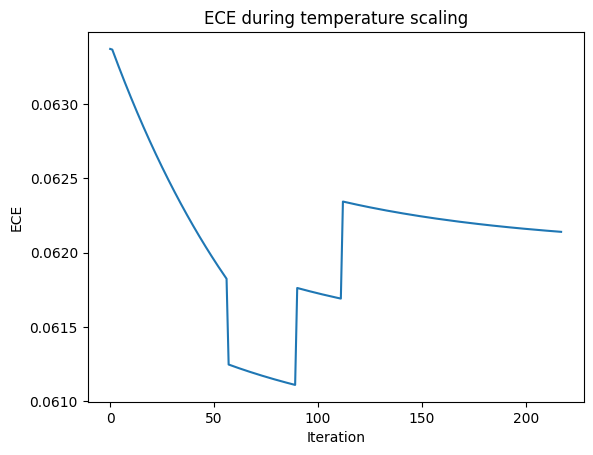

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.071, ECE: 0.044
Optimal temperature: 0.739
After temperature - NLL: 0.065, ECE: 0.029
Best Optimal temperature: 0.882
After best temperature - NLL: 0.067, ECE: 0.028


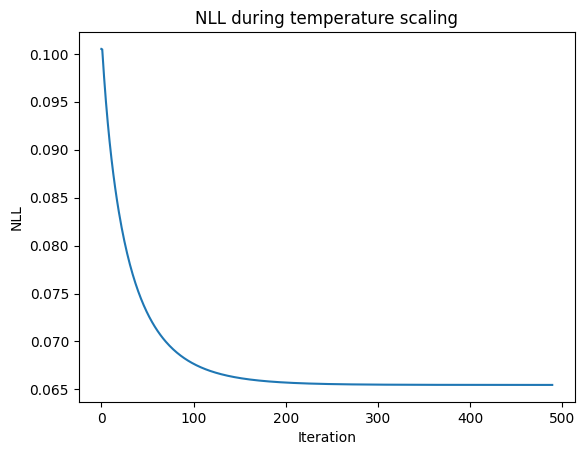

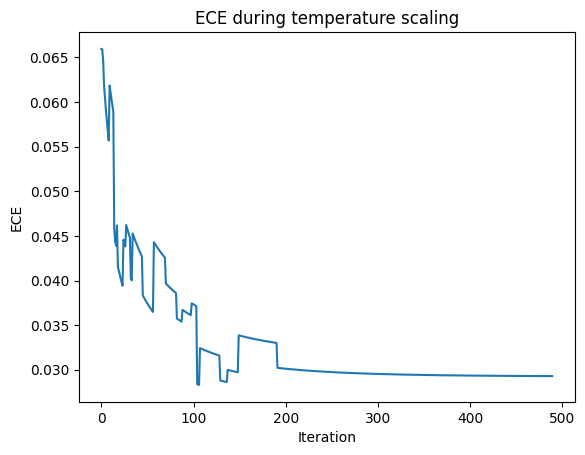

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

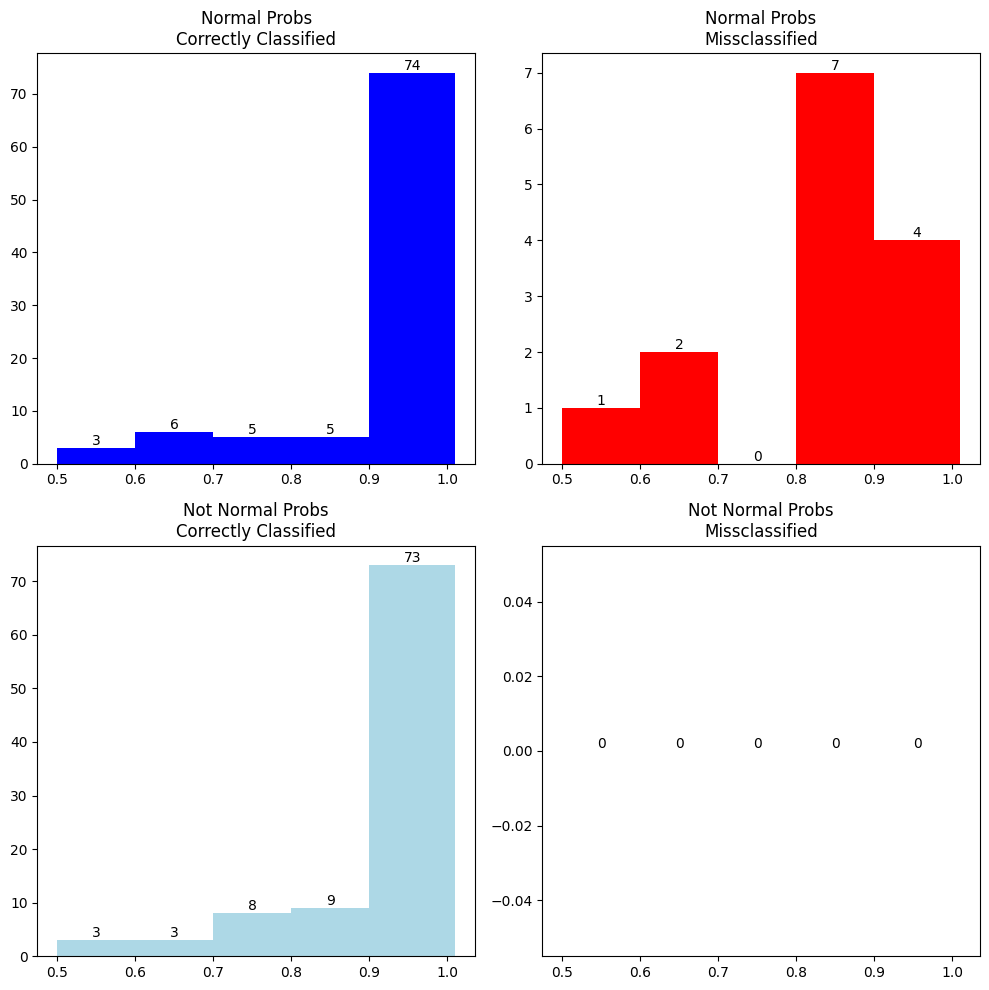

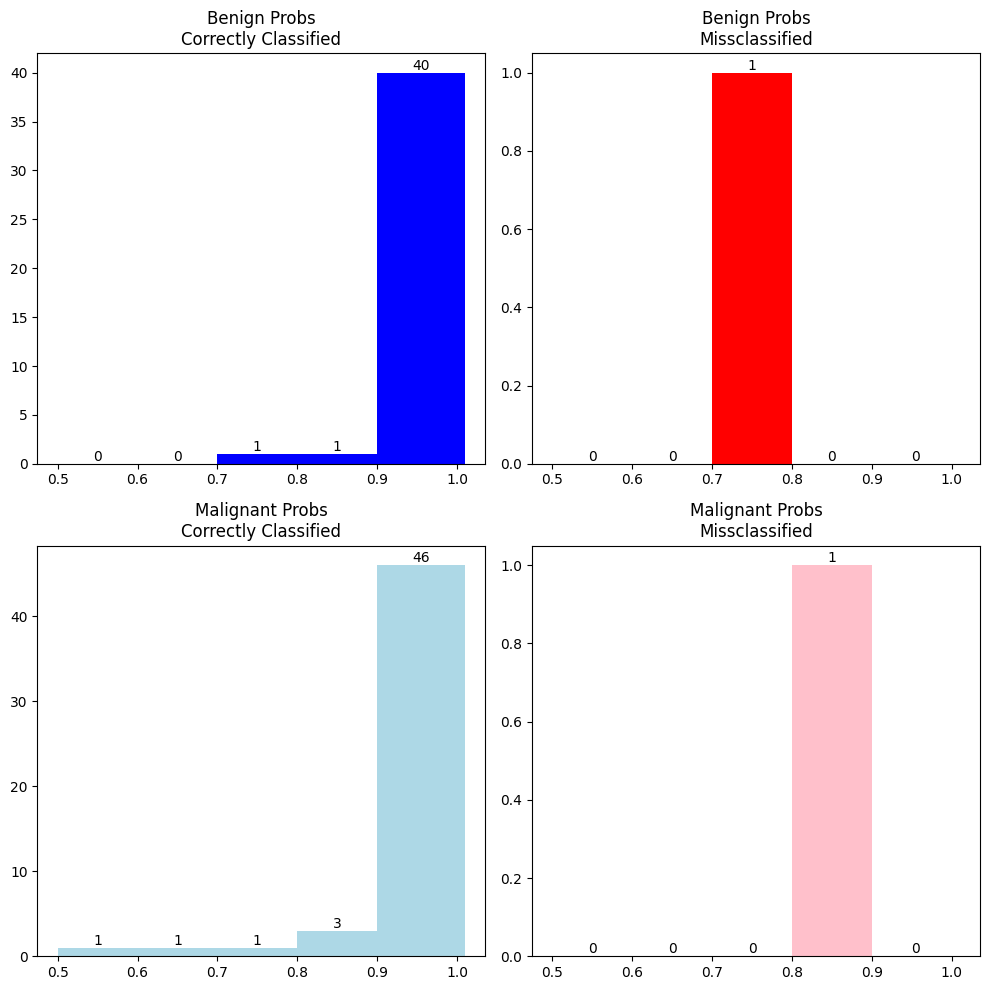

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold7

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold7: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_66.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_7_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7469058632850647, median IoU: 0.7717609405517578
TP: 202, FN: 0, FP: 1
Precision: 0.9950738916256158
Recall: 1.0
Acc: 0.9015 Spec: 1.0000 Sens: 0.8852
Normal vs Not Noraml Acc: 0.9261 Benign vs Malignant Acc: 0.9510


### Eval Results

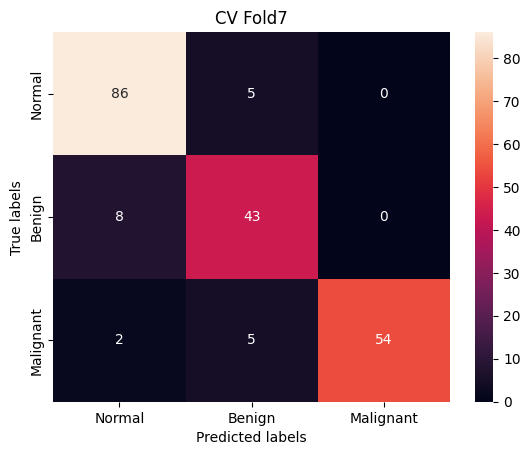

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold7')
plt.show()



---



#### Plots

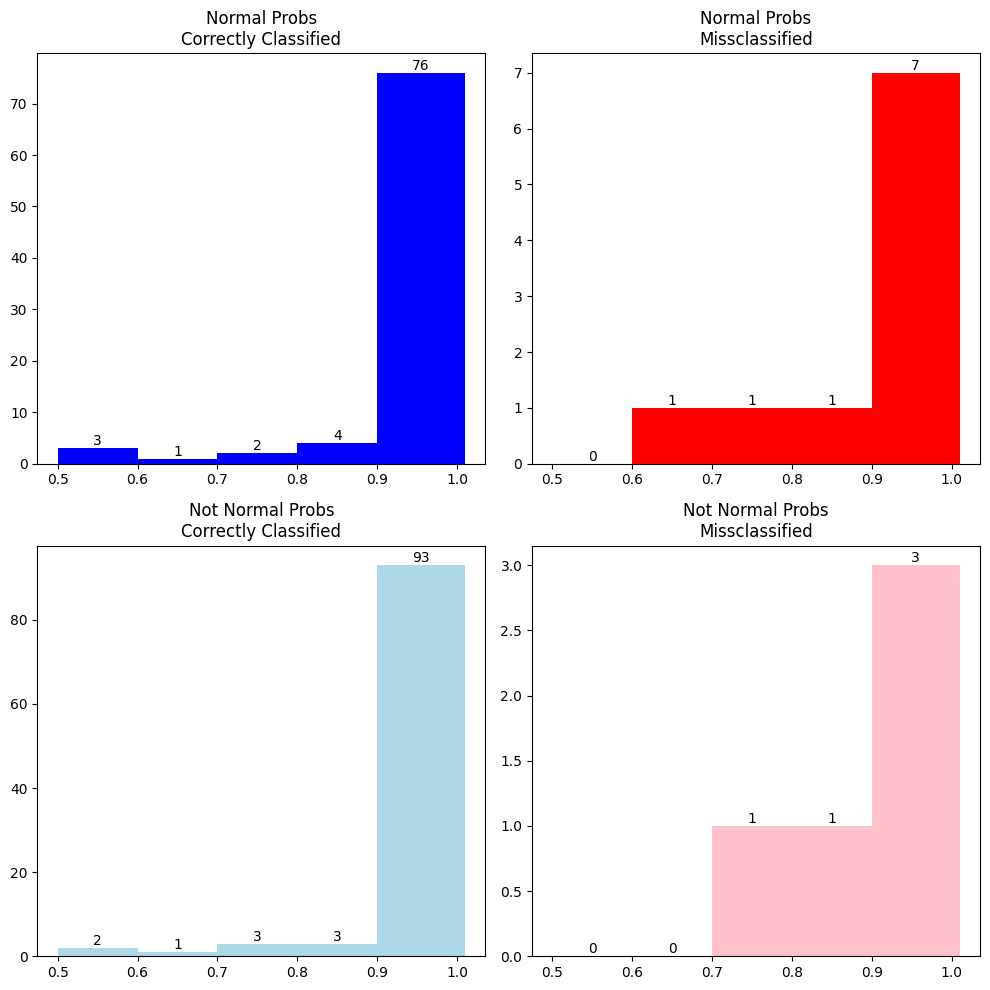

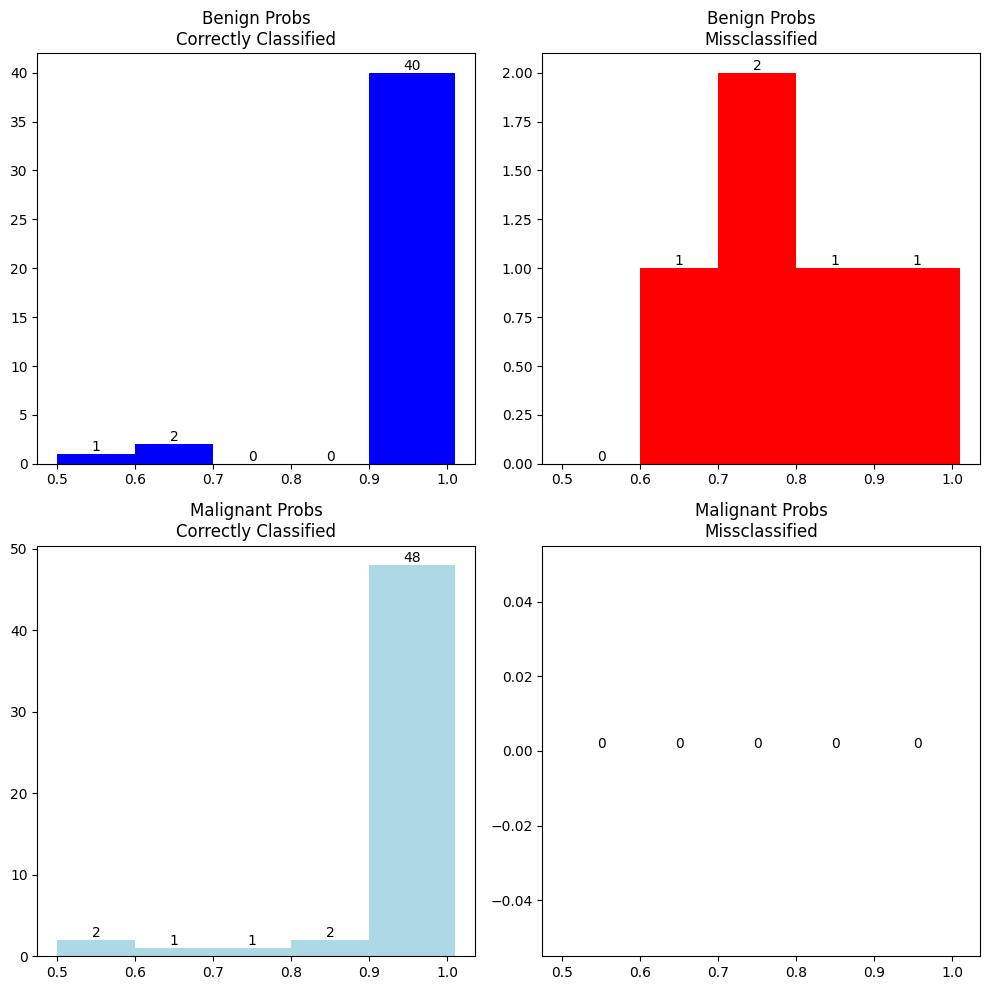

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.258, ECE: 0.061
Optimal temperature: 1.724
After temperature - NLL: 0.216, ECE: 0.048
Best Optimal temperature: 1.551
After best temperature - NLL: 0.217, ECE: 0.032


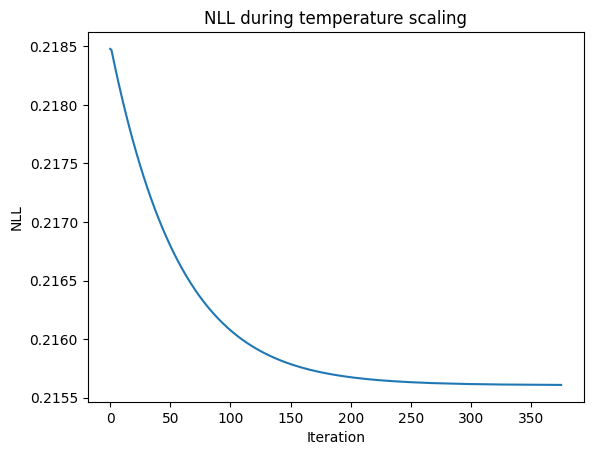

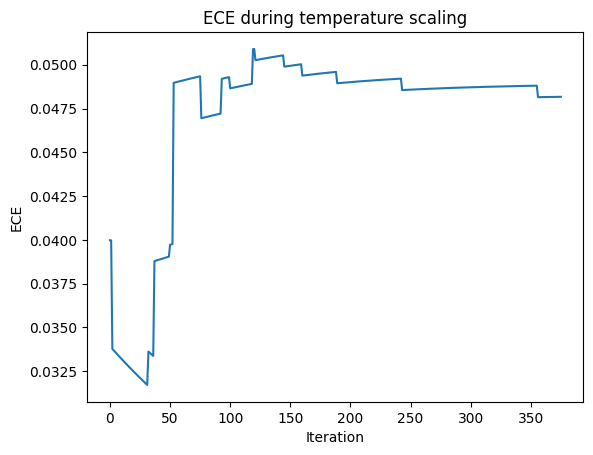

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.123, ECE: 0.049
Optimal temperature: 1.234
After temperature - NLL: 0.120, ECE: 0.044
Best Optimal temperature: 1.234
After best temperature - NLL: 0.120, ECE: 0.044


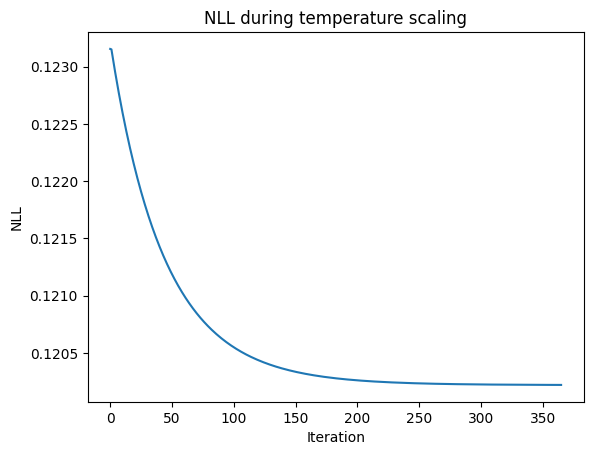

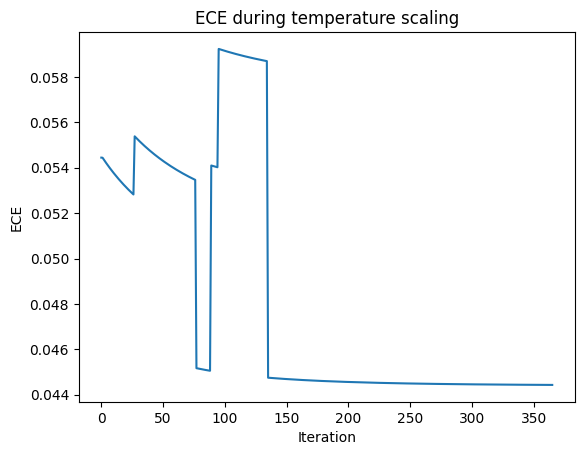

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

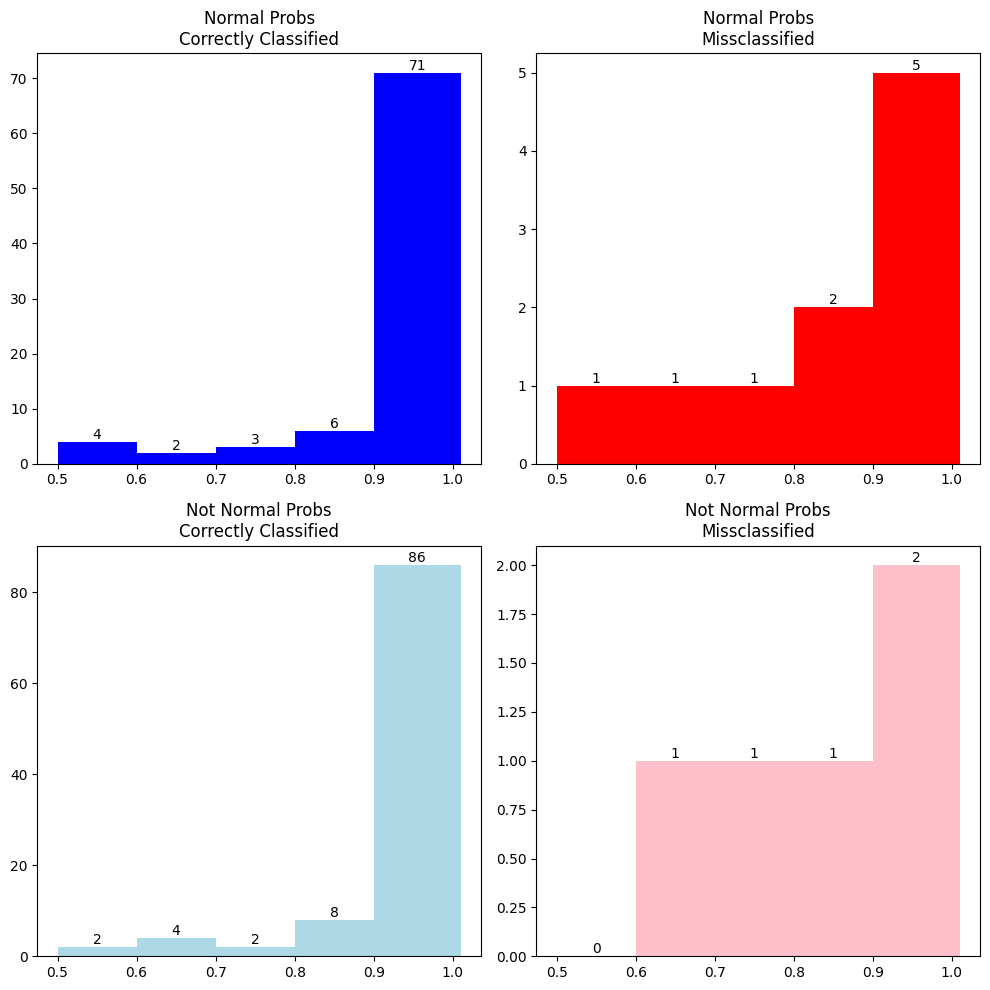

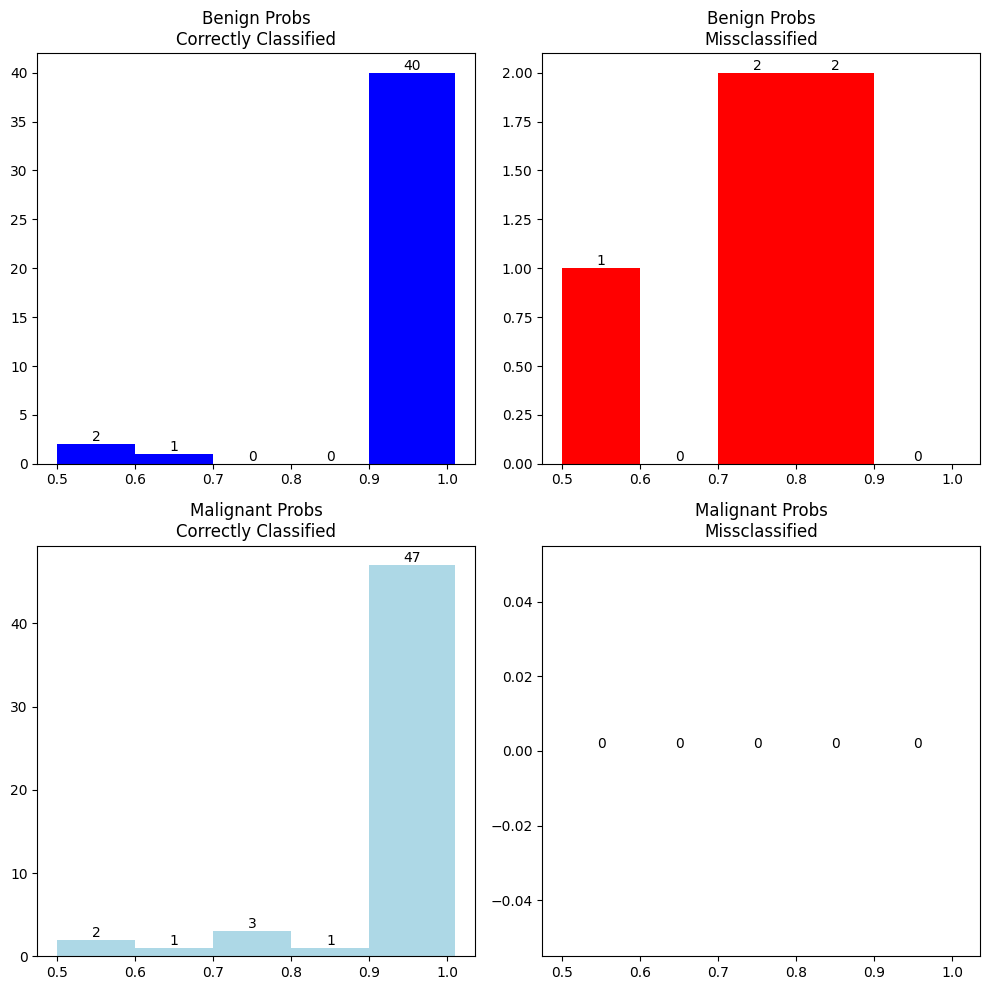

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold8

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold8: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_48.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_8_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7393278479576111, median IoU: 0.754780650138855
TP: 203, FN: 0, FP: 0
Precision: 1.0
Recall: 1.0
Acc: 0.9261 Spec: 0.9799 Sens: 0.9444
Normal vs Not Noraml Acc: 0.9557 Benign vs Malignant Acc: 0.9394


### Eval Results

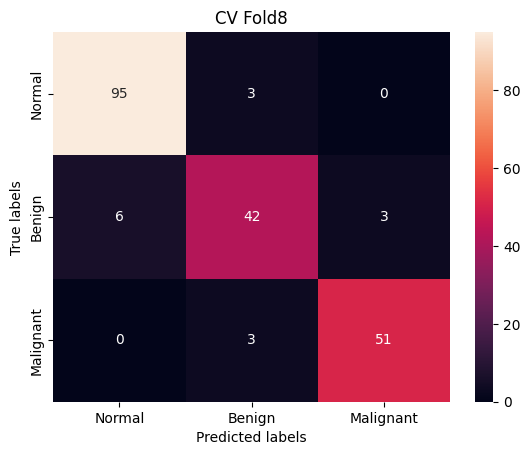

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold8')
plt.show()



---



#### Plots

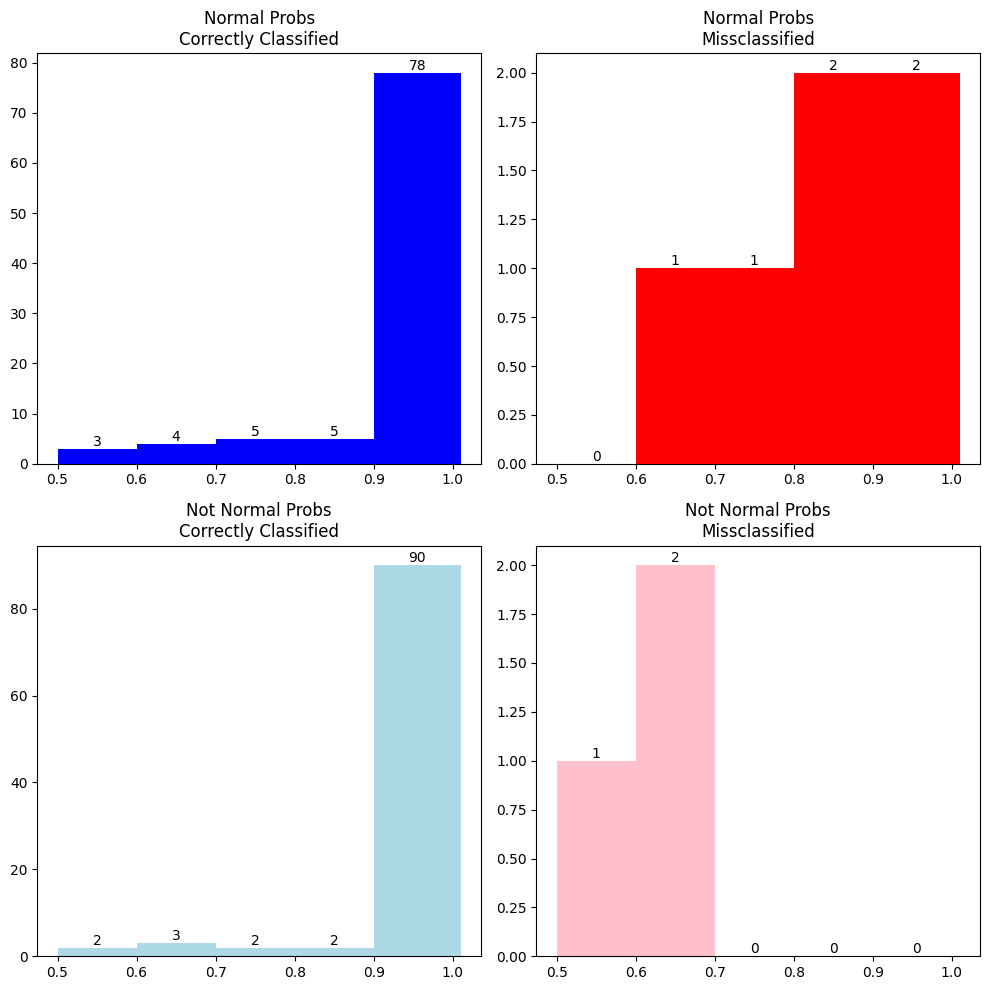

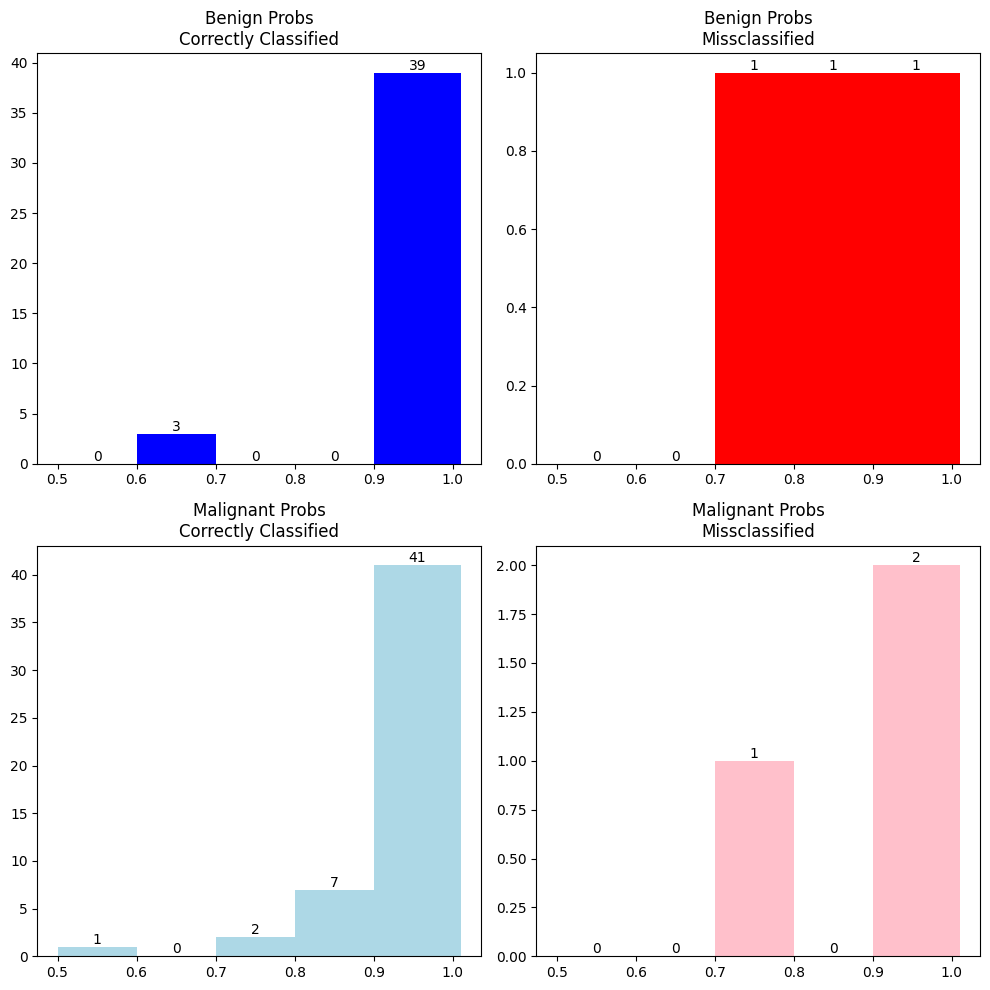

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.139, ECE: 0.024
Optimal temperature: 0.936
After temperature - NLL: 0.139, ECE: 0.024
Best Optimal temperature: 1.006
After best temperature - NLL: 0.139, ECE: 0.022


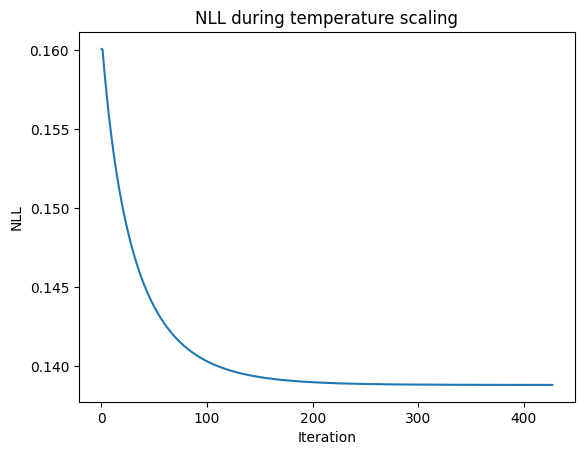

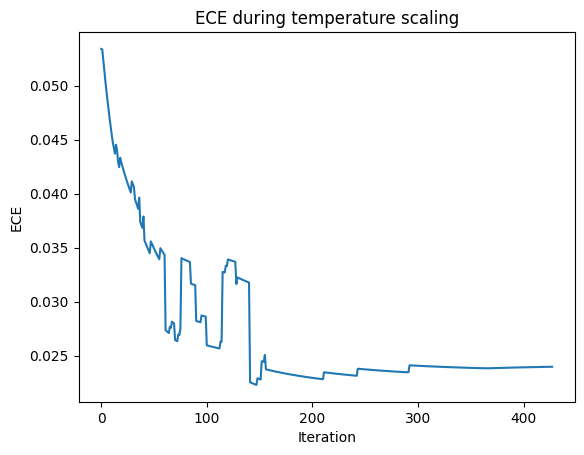

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.181, ECE: 0.055
Optimal temperature: 1.334
After temperature - NLL: 0.173, ECE: 0.039
Best Optimal temperature: 1.337
After best temperature - NLL: 0.173, ECE: 0.038


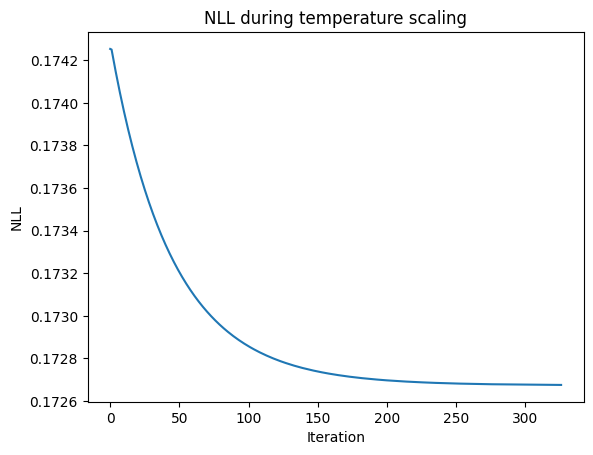

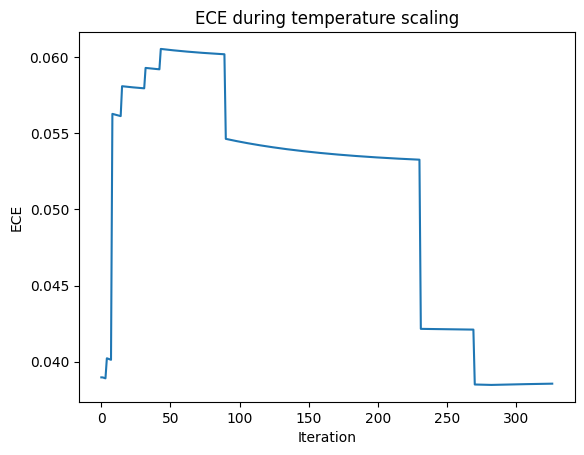

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

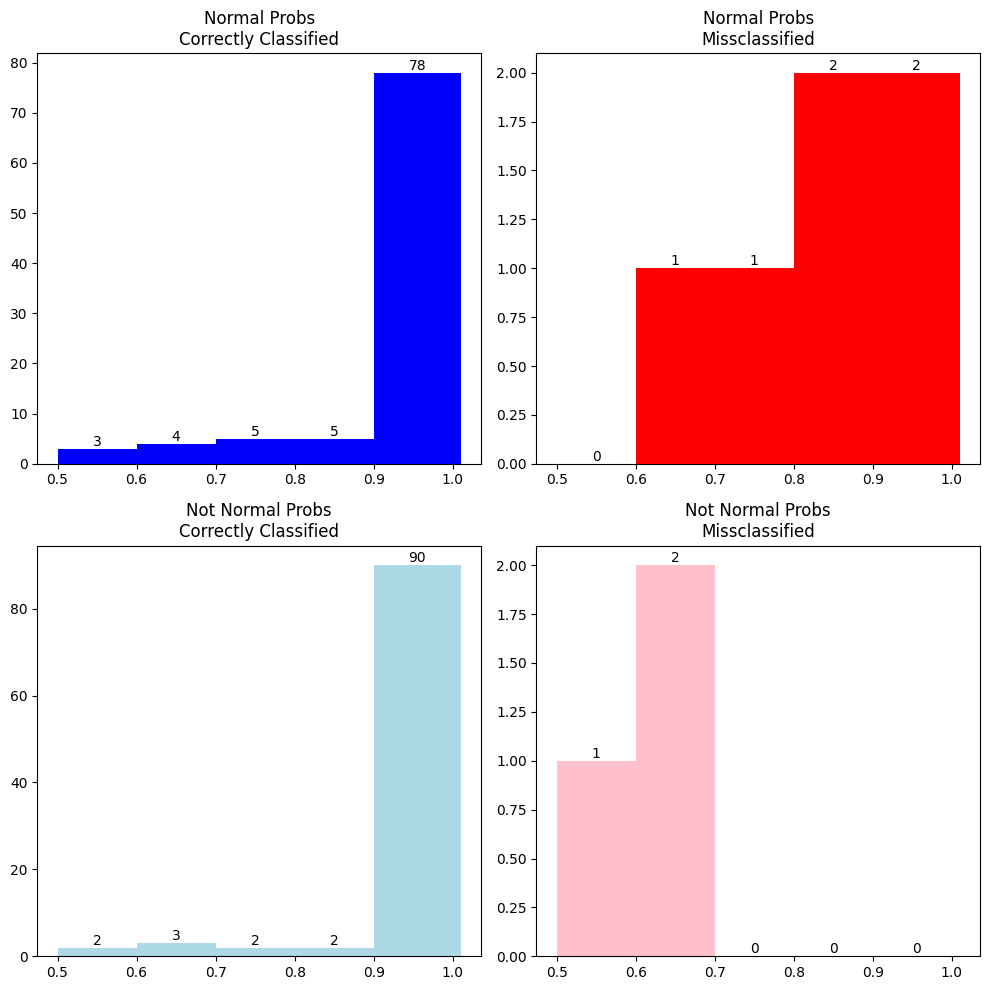

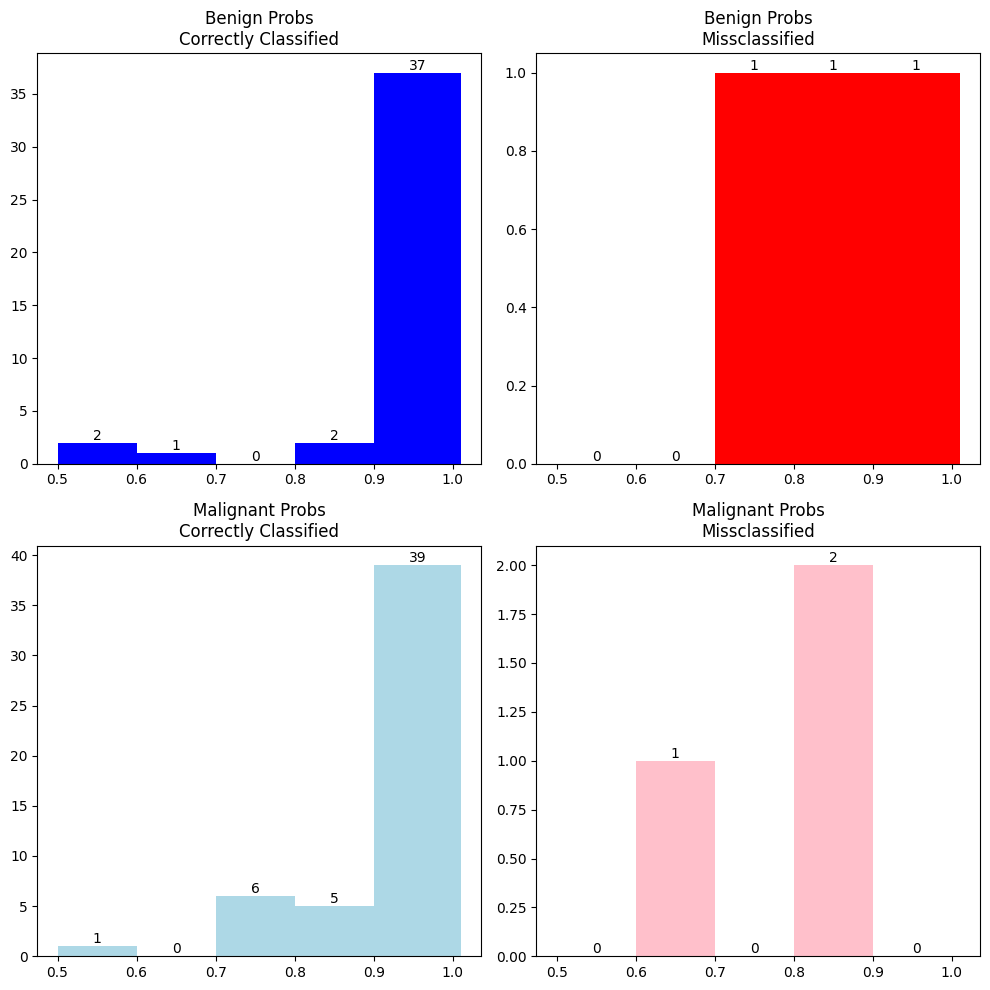

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Fold9

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/CV/Fold9: GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_42.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/CV splits/fold_9_test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.7397827506065369, median IoU: 0.7813577651977539
TP: 197, FN: 0, FP: 6
Precision: 0.9704433497536946
Recall: 1.0
Acc: 0.9557 Spec: 0.9932 Sens: 0.9273
Normal vs Not Noraml Acc: 0.9704 Benign vs Malignant Acc: 0.9703


### Eval Results

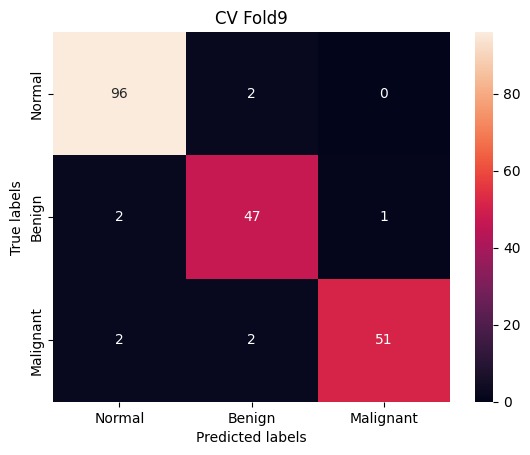

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CV Fold9')
plt.show()



---



#### Plots

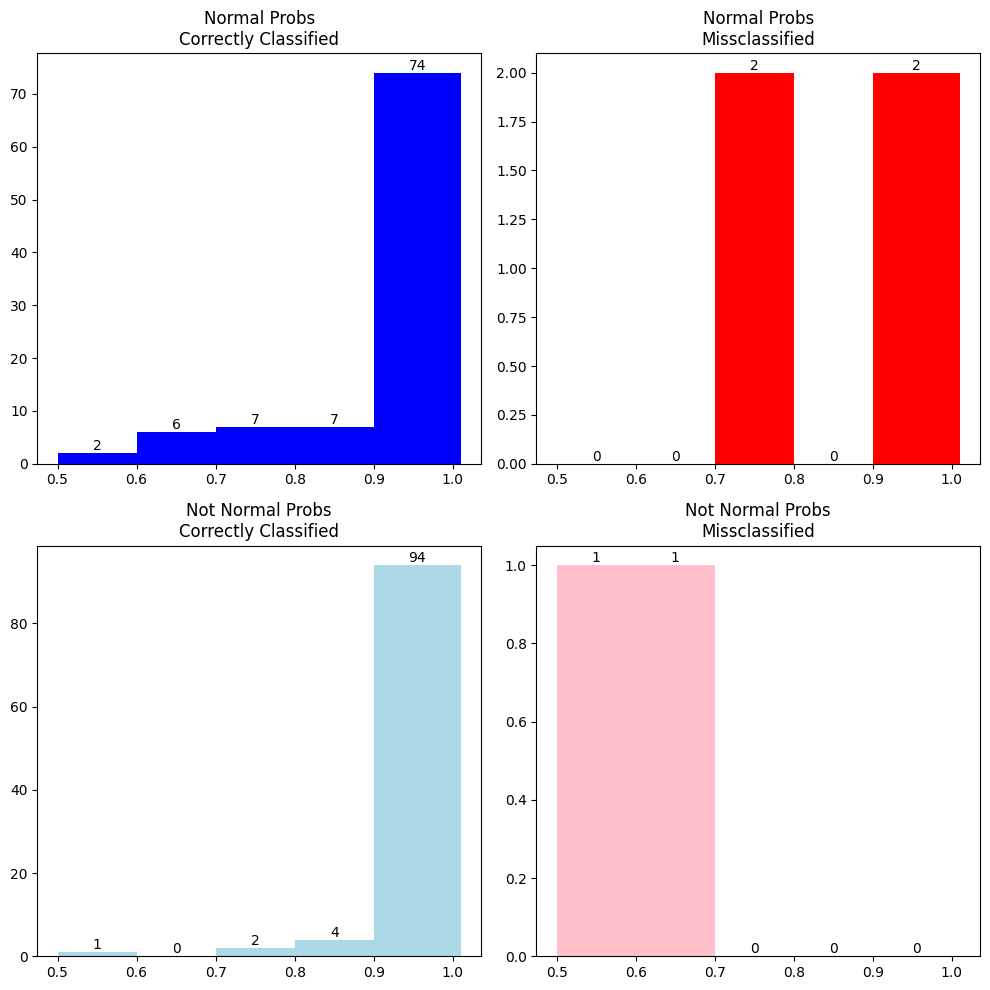

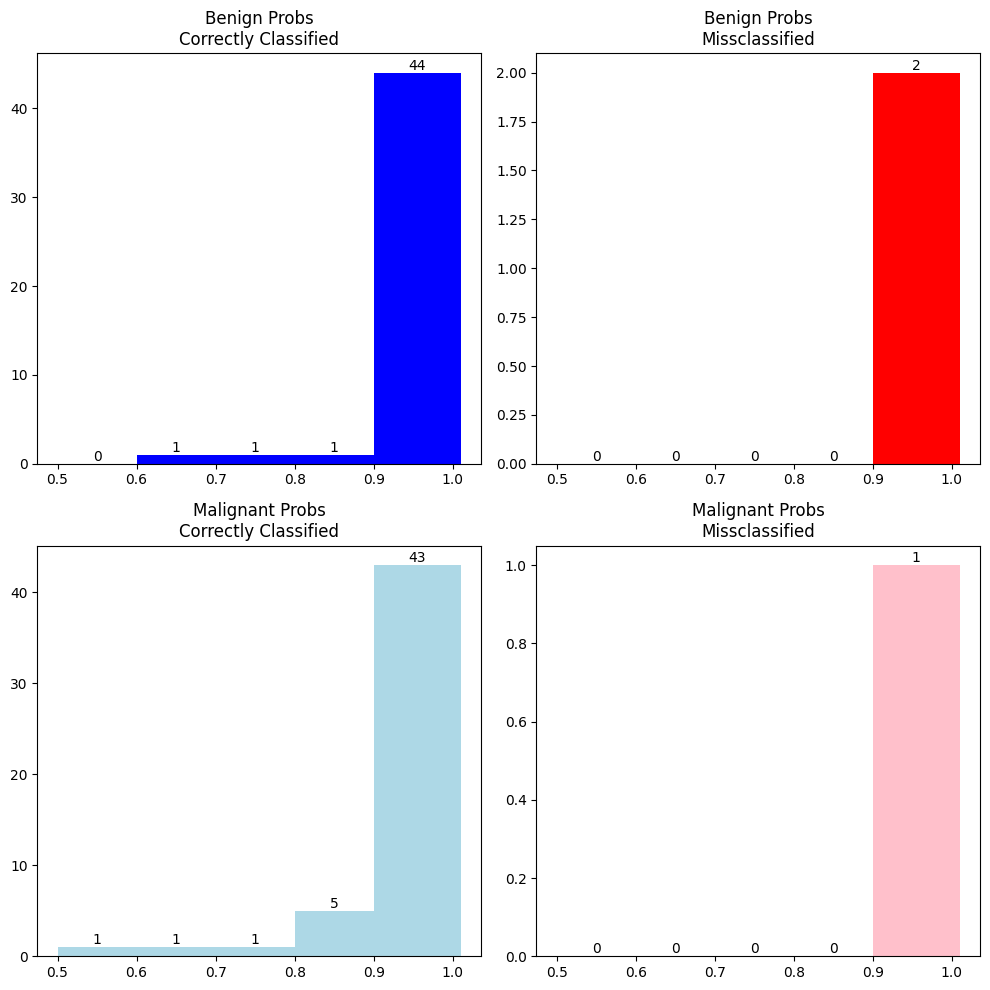

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.128, ECE: 0.033
Optimal temperature: 0.899
After temperature - NLL: 0.127, ECE: 0.026
Best Optimal temperature: 0.925
After best temperature - NLL: 0.127, ECE: 0.026


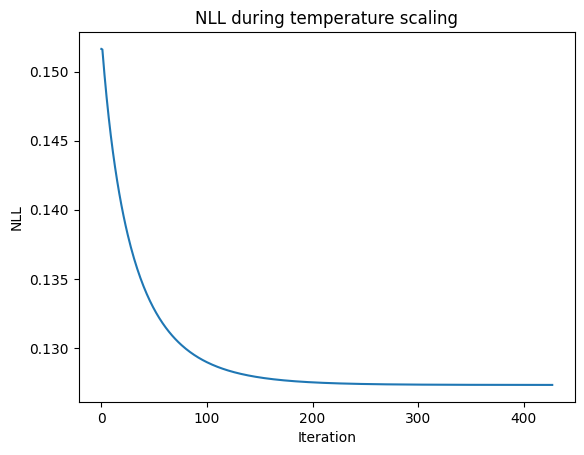

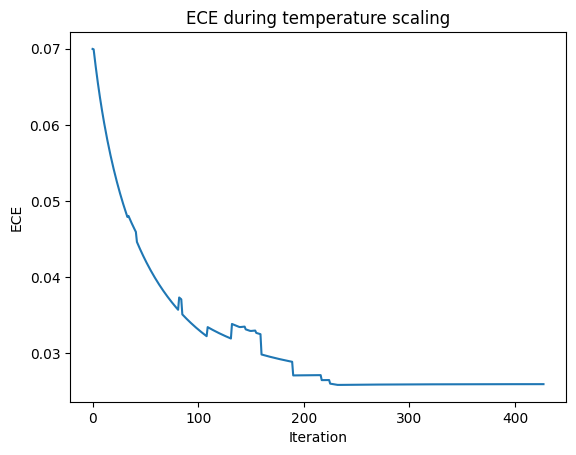

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.195, ECE: 0.050
Optimal temperature: 1.448
After temperature - NLL: 0.178, ECE: 0.063
Best Optimal temperature: 1.000
After best temperature - NLL: 0.195, ECE: 0.050


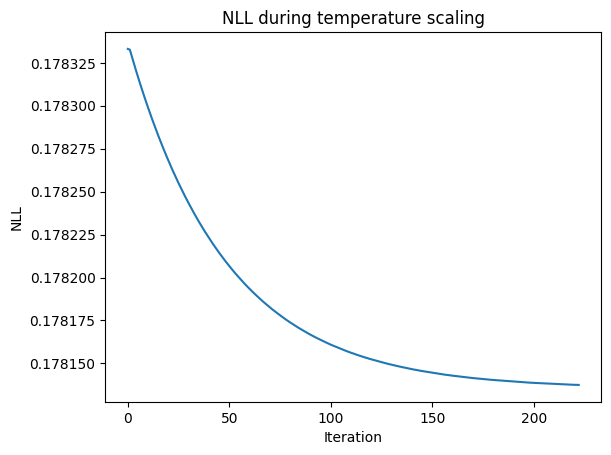

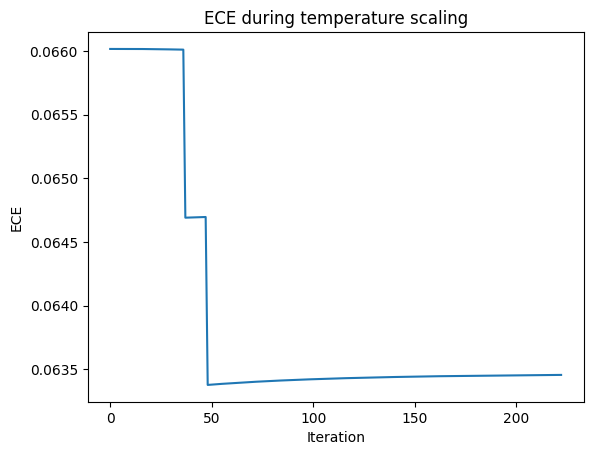

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

#### Plots

In [ ]:
n_nn_t = torch.ones(1) * n_nn_best_temperature
b_m_t = torch.ones(1) * b_m_best_temperature
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

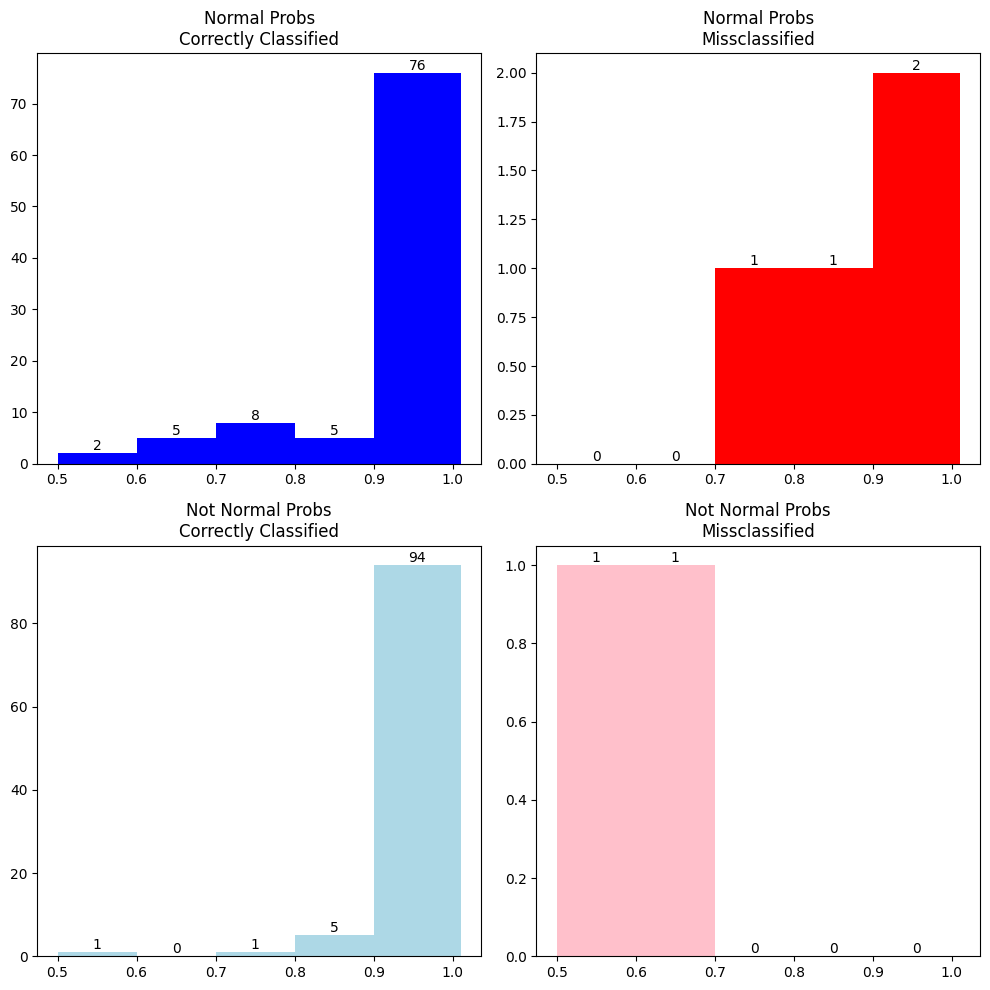

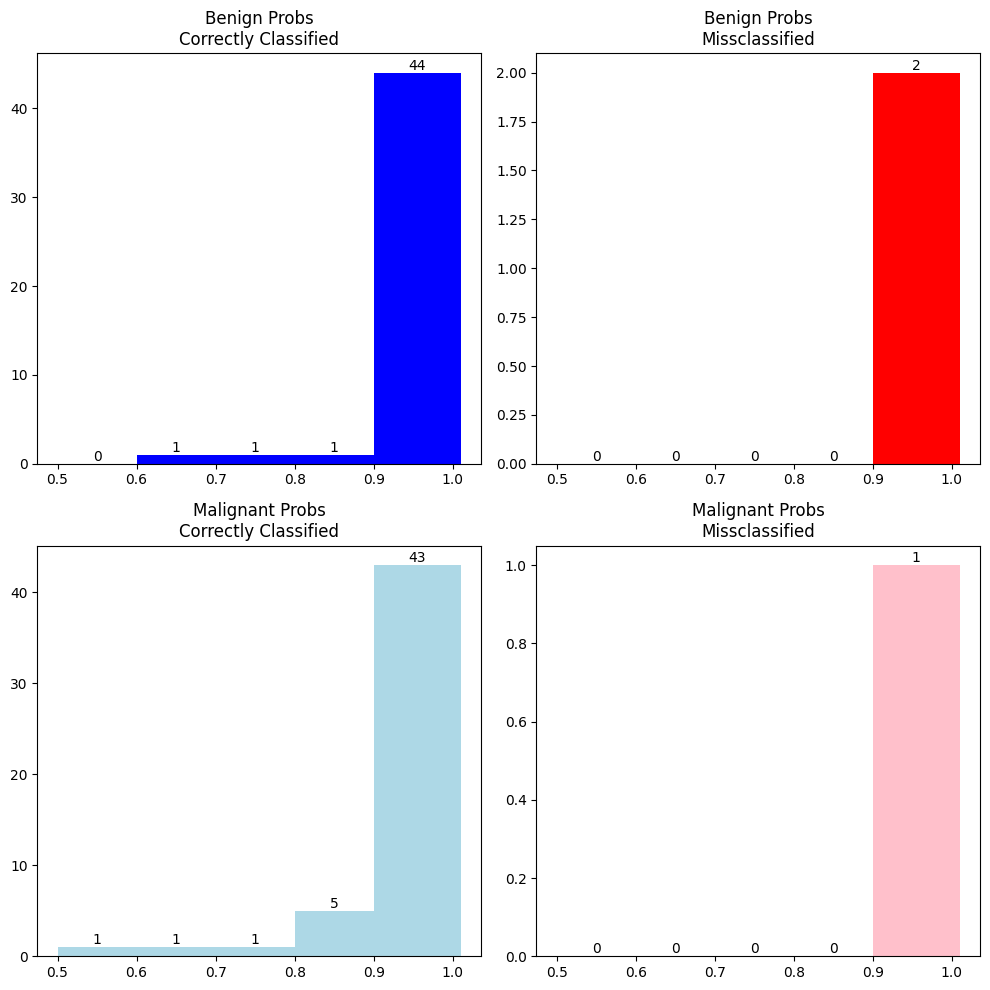

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

## Test Set

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:02<00:00, 68.9MB/s]


Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6586982607841492, median IoU: 0.6912716031074524
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222


### Eval Results

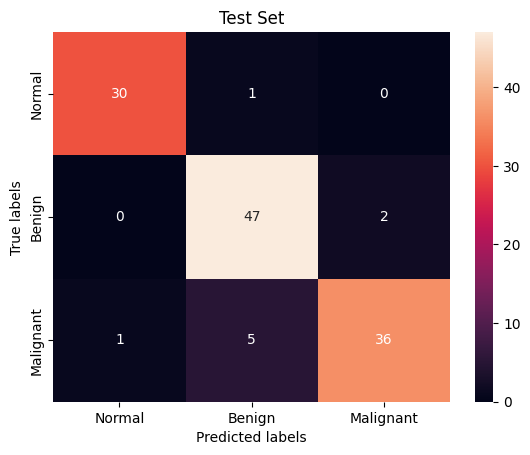

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Set')
plt.show()



---



#### Plots

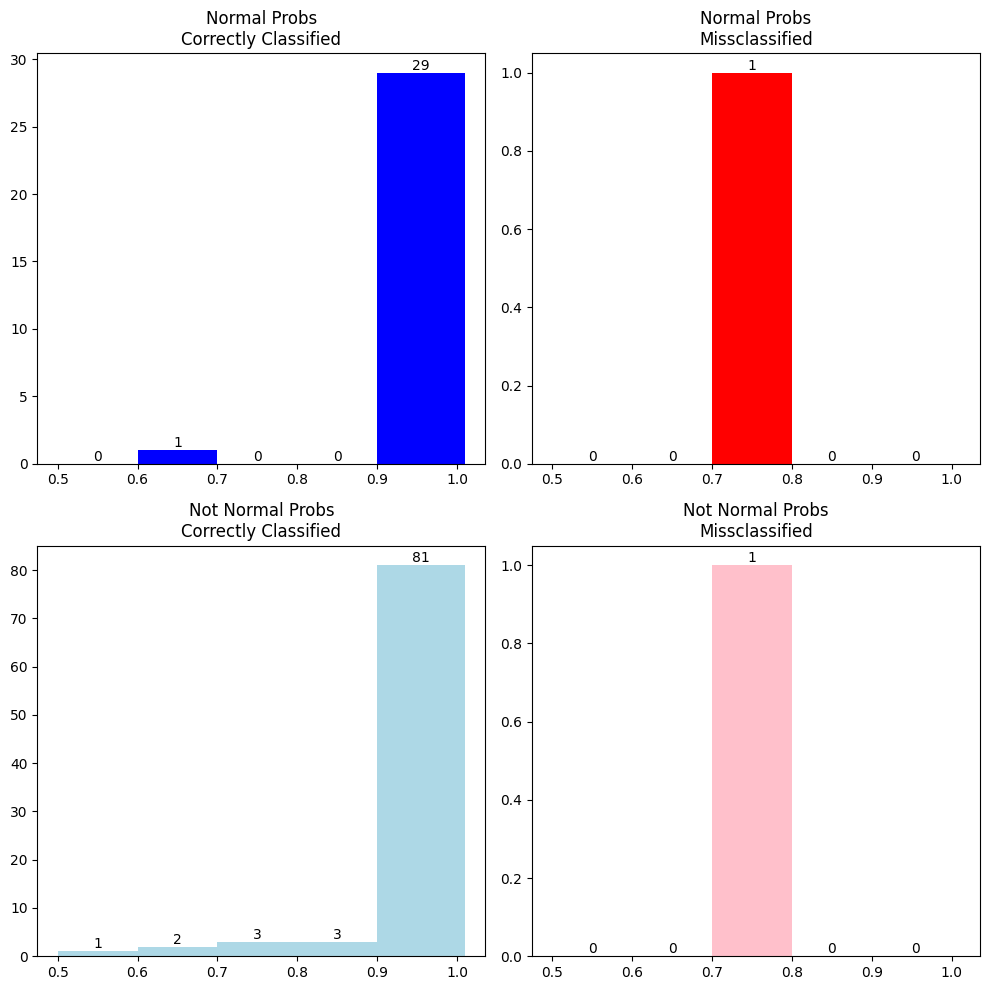

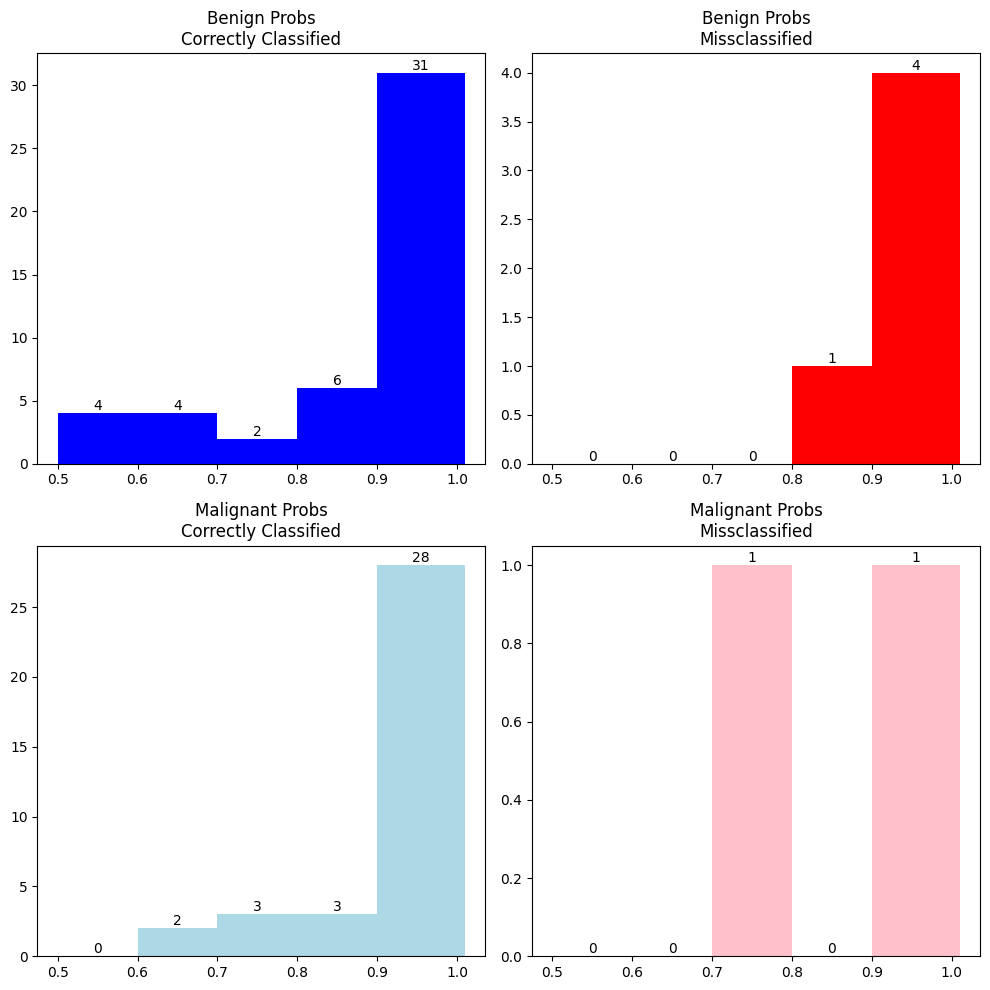

In [ ]:
plot_probs(y_true, y_pred, all_logits)

### Calibration

In [ ]:
def cal_evaluate(all_logits, y_true, y_pred, t, cls_type):
    nll_criterion = nn.CrossEntropyLoss().to(device)
    ece_criterion = _ECELoss().to(device)

    if cls_type == "n_nn":
      labels = torch.tensor([0 if x==0 else 1 for x in y_true]).to(device)
      logits = torch.tensor(all_logits[0]).to(device)
    elif cls_type == "b_m":
      # Find the indices of instances predicted as non-noraml
      nn_pred_indices = [i for i,p in enumerate(y_pred) if p!=0]
      # Find the true labels of instances predicted as non-normal
      filtered_y_true = [y_true[i] for i in nn_pred_indices]
      # Find indices of truly non-normal instances from the true labels
      nn_true_pred_indices = [i for i,y in enumerate(filtered_y_true) if y!=0]

      labels = torch.tensor([filtered_y_true[i]-1 for i in nn_true_pred_indices]).to(device)
      logits = torch.tensor([all_logits[1][i] for i in nn_true_pred_indices]).to(device)

    # Calculate NLL and ECE before temperature scaling
    before_temperature_nll = nll_criterion(logits, labels).item()
    before_temperature_ece = ece_criterion(logits, labels).item()
    print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

    t = torch.ones(1) * t
    t = t.unsqueeze(1).expand(logits.size(0), logits.size(1)).to(device)
    scaled_logits = logits / t

    after_temperature_nll = nll_criterion(scaled_logits, labels).item()
    after_temperature_ece = ece_criterion(scaled_logits, labels).item()
    print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.061, ECE: 0.029
Optimal temperature: 0.587
After temperature - NLL: 0.049, ECE: 0.025
Best Optimal temperature: 0.664
After best temperature - NLL: 0.049, ECE: 0.016


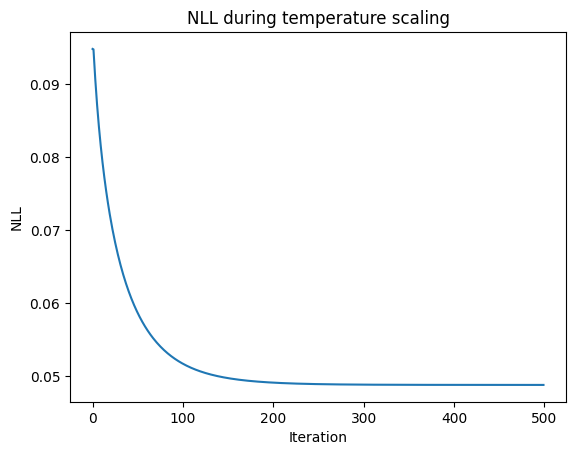

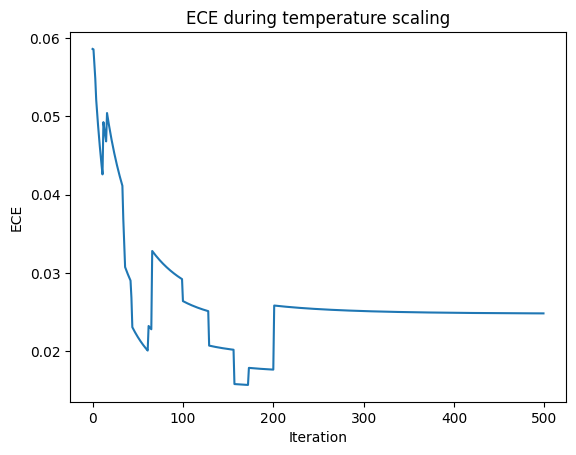

In [ ]:
n_nn_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate n_nn")

Retinanet's COCO pre-trained weights are loaded.
Before temperature - NLL: 0.346, ECE: 0.096
Optimal temperature: 1.558
After temperature - NLL: 0.316, ECE: 0.086
Best Optimal temperature: 1.558
After best temperature - NLL: 0.316, ECE: 0.086


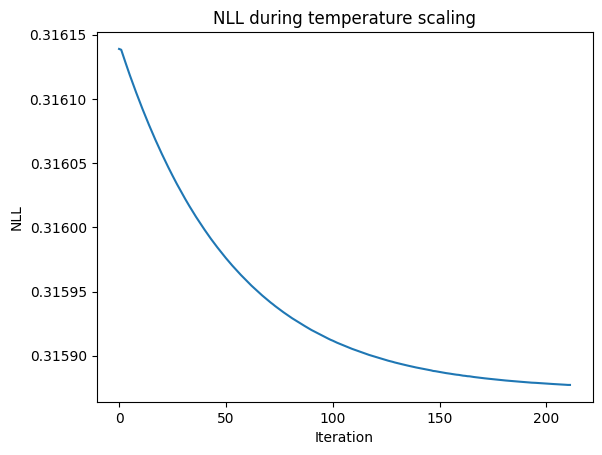

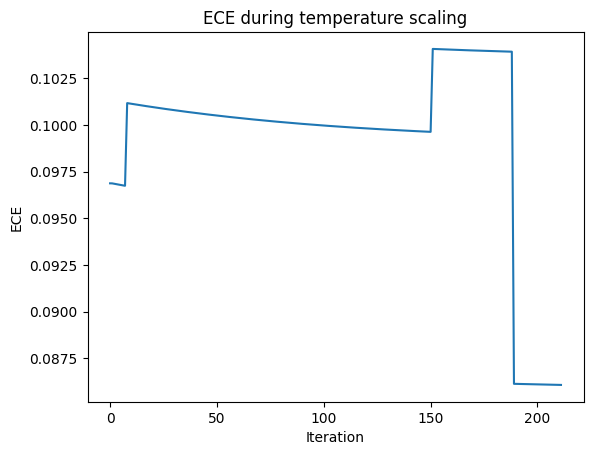

In [ ]:
b_m_best_temperature = eval_cal(checkpoint_path, val_txt_path, task="calibrate b_m")

In [ ]:
# Average of CV Optimal Temperatures
print("Normal vs. Non-Normal calibration")
cal_evaluate(all_logits=all_logits, y_true=y_true, y_pred=y_pred, t=1.4656, cls_type="n_nn")

print("\nBenign vs. Malignant calibration")
cal_evaluate(all_logits=all_logits, y_true=y_true, y_pred=y_pred, t=1.5834, cls_type="b_m")

Normal vs. Non-Normal calibration
Before temperature - NLL: 0.061, ECE: 0.029
After temperature - NLL: 0.092, ECE: 0.056

Benign vs. Malignant calibration
Before temperature - NLL: 0.346, ECE: 0.096
After temperature - NLL: 0.316, ECE: 0.085


In [ ]:
# Median of CV Optimal Temperatures
print("Normal vs. Non-Normal calibration")
cal_evaluate(all_logits=all_logits, y_true=y_true, y_pred=y_pred, t=1.4815, cls_type="n_nn")

print("\nBenign vs. Malignant calibration")
cal_evaluate(all_logits=all_logits, y_true=y_true, y_pred=y_pred, t=1.5010, cls_type="b_m")

Normal vs. Non-Normal calibration
Before temperature - NLL: 0.061, ECE: 0.029
After temperature - NLL: 0.093, ECE: 0.057

Benign vs. Malignant calibration
Before temperature - NLL: 0.346, ECE: 0.096
After temperature - NLL: 0.316, ECE: 0.097


#### Plots

In [ ]:
n_nn_t = torch.ones(1) * 1.4656
b_m_t = torch.ones(1) * 1.5834
n_nn_logits = torch.tensor(all_logits[0])
b_m_logits = torch.tensor(all_logits[1])
n_nn_t = n_nn_t.unsqueeze(1).expand(n_nn_logits.size(0), n_nn_logits.size(1))
b_m_t = b_m_t.unsqueeze(1).expand(b_m_logits.size(0), b_m_logits.size(1))
n_nn_scaled_logits = n_nn_logits / n_nn_t
b_m_scaled_logits = b_m_logits / b_m_t

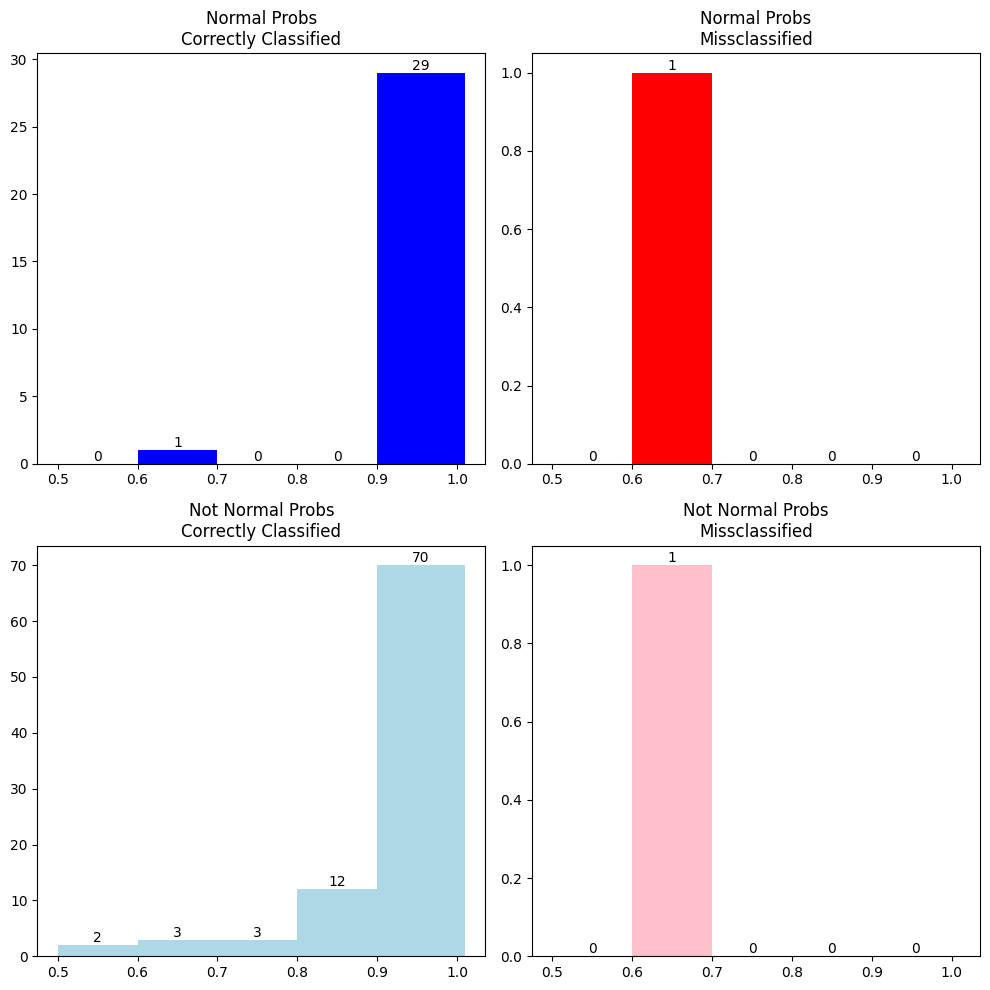

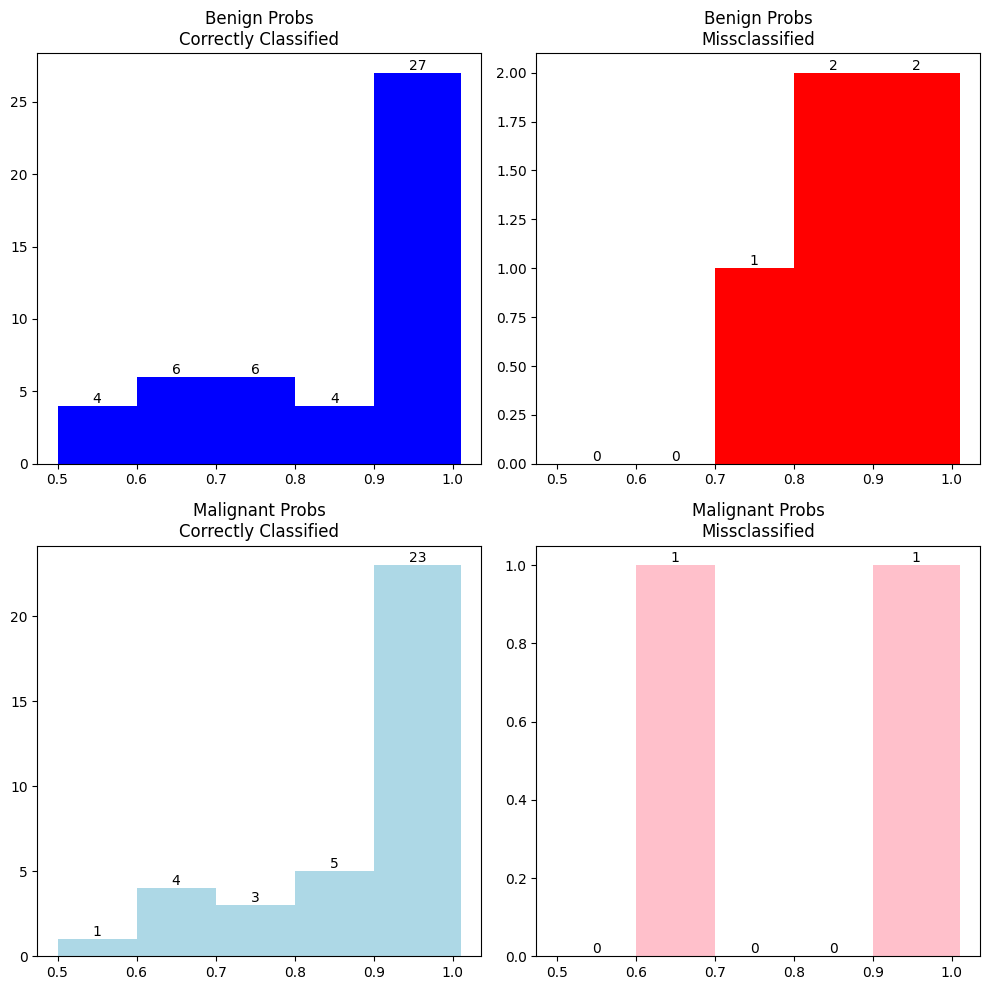

In [ ]:
plot_probs(y_true, y_pred, [n_nn_scaled_logits, b_m_scaled_logits])

# Confusion Matrix of Cross-Validation

In [ ]:
import numpy as np
cfms =np.array([[[103,6,0],
                 [2,47,1],
                 [0,4,41]],
                [[96,8,0],
                 [2,48,0],
                 [0,4,46]],
                [[101,1,0],
                 [10,40,2],
                 [0,3,47]],
                [[100,4,0],
                 [2,49,1],
                 [0,2,46]],
                [[99,11,0],
                 [6,43,3],
                 [0,8,34]],
                [[93,0,0],
                 [8,42,1],
                 [6,1,52]],
                [[86,5,0],
                 [8,43,0],
                 [2,5,54]],
                [[95,3,0],
                 [6,42,3],
                 [0,3,51]],
                [[96,2,0],
                 [2,47,1],
                 [2,2,51]],
                [[103,6,0],
                 [6,44,0],
                 [4,9,32]]])

Text(0.5, 1.0, 'Cross Validation: Mean(SD)')

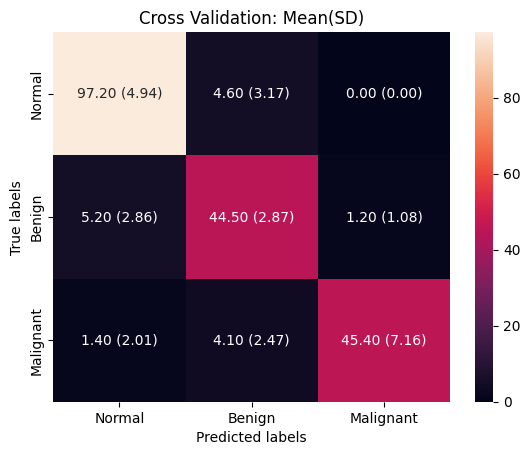

In [ ]:
mean_matrix = np.mean(cfms, axis=0)
std_matrix = np.std(cfms, axis=0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = ['Normal', 'Benign', 'Malignant']

mean_std_matrix = np.empty((mean_matrix.shape[0], mean_matrix.shape[1]), dtype=object)
for i in range(mean_matrix.shape[0]):
    for j in range(mean_matrix.shape[1]):
        mean_std_matrix[i, j] = f"{mean_matrix[i, j]:.2f} ({std_matrix[i, j]:.2f})"

ax = plt.subplot()
sns.heatmap(mean_matrix, annot=mean_std_matrix, fmt="", xticklabels=labels, yticklabels=labels)
#ax = sns.heatmap(mean_matrix, annot=mean_std_matrix, fmt="", xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Cross Validation: Mean(SD)')